## Import the API connection for the code

In [621]:
pip install fuzzywuzzy[speedup]


   ---------------------------------------- 0.0/98.5 kB ? eta -:--:--
   ---------------- ----------------------- 41.0/98.5 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 98.5/98.5 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.6 MB 2.6 MB/s eta 0:00:01
   ---- ----------------------------------- 0.2/1.6 MB 2.2 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/1.6 MB 2.0 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.6 MB 2.2 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.6 MB 2.6 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.6 MB 2.7 MB/s eta 0:00:01
   ------------------- -------------------- 0.8/1.6 MB 2.6 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.6 MB 2.8 MB/s eta 0:00:01
   ---------------------------- ----------- 1.1/1.6 MB 2.9 MB/s eta 0:00:01
   ---------------

In [725]:
pip install twilio


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.8 MB 1.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/1.8 MB 2.6 MB/s eta 0:00:01
   --------- ------------------------------ 0.5/1.8 MB 4.0 MB/s eta 0:00:01
   -------------------------------- ------- 1.5/1.8 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------  1.8/1.8 MB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 8.2 MB/s eta 0:00:00


In [625]:
import requests
from fuzzywuzzy import fuzz
#import iso8601
import pandas as pd
import numpy as np
import io
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
import matplotlib.pyplot as plt
from joypy import joyplot
import re
import json
from nba_api.stats.endpoints import commonteamroster
import math
import requests
import time
import logging

headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_0042000404.json"
response = requests.get(url=play_by_play_url, headers=headers).json()
play_by_play = response['game']['actions']
df = pd.DataFrame(play_by_play)


In [629]:
# Function to find the highest fuzzy match
def get_highest_fuzzy_match(value, df, column):
    # Compute fuzzy ratio between the given value and each entry in the specified column
    df['fuzzy_ratio'] = df[column].apply(lambda x: fuzz.ratio(value, str(x)))
    
    # Get the row with the highest fuzzy ratio
    best_match = df.loc[df['fuzzy_ratio'].idxmax(), column]
    best_ratio = df['fuzzy_ratio'].max()
    
    return best_match, best_ratio

## Define the function to grab gamelogs

In [312]:
# get game logs from the reg season
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2022-23', 
                                              league_id_nullable='00', 
                                              season_type_nullable='Regular Season')
games = gamefinder.get_data_frames()[0]
# Get a list of distinct game ids 
game_ids = games['GAME_ID'].unique().tolist()
# create function that gets pbp logs from the 2020-21 season
def get_data(game_id):
    play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
    response = requests.get(url=play_by_play_url, headers=headers).json()
    play_by_play = response['game']['actions']
    df = pd.DataFrame(play_by_play)
    df['gameid'] = game_id
    return df


## Function to get the first quarter data

In [314]:
def get_first_quarter_data(season_years):
    # get game logs from the reg season
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=f'{season_years}', 
                                              league_id_nullable='00', 
                                              season_type_nullable='Regular Season')
    games = gamefinder.get_data_frames()[0]
    
    game_ids = games['GAME_ID'].unique().tolist()
    # sort
    game_ids = sorted(game_ids)

    # create function that gets pbp logs from the 2020-21 season
    def get_data(game_id):
        play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
        response = requests.get(url=play_by_play_url, headers=headers).json()
        play_by_play = response['game']['actions']
        df = pd.DataFrame(play_by_play)
        df['gameid'] = game_id
        return df
    
    pbpdata = []
    for game_id in game_ids:
        game_data = get_data(game_id)
        game_data = game_data[game_data['period'] == 1]
        pbpdata.append(game_data)
        print(f'This is loop {game_id} of {len(game_ids)}')
    df = pd.concat(pbpdata, ignore_index=True)

    # Convert 'timeActual' to datetime format
    df['timeActual'] = pd.to_datetime(df['timeActual'], format='%Y-%m-%dT%H:%M:%S.%fZ')

    # Extract the date portion
    df['timeActual'] = df['timeActual'].dt.strftime('%Y-%m-%d')
    
    # Assuming df is your DataFrame
    df.sort_values(by='timeActual', inplace=True)
    
    # Function to convert duration string to MM:SS format
    def convert_duration(duration_str):
        # Remove "PT" at the beginning and "S" at the end
        duration_str = duration_str[2:-4]
        minutes, seconds = duration_str.split('M')
        return f"{minutes}:{seconds}"
     # Apply the function to the 'clock' column
    df['clock'] = df['clock'].apply(convert_duration)

    # Convert the "clock" column to datetime format
    df['clock'] = pd.to_datetime(df['clock'], format='%H:%M')
    
    return df

def get_game_ids(season_first_q_data):
    
    # Get a list of distinct game ids 
    game_ids = season_first_q_data['gameid'].unique().tolist()
    
    return game_ids


# Define the function to get jump ball data

In [316]:
# function to get the number of jump ball wins vs total jump balls for players in a given season

def get_jump_ball_data(season_first_q_data, min_number_of_jump_balls, game_ids):
    #gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=f'{season_years}', 
    #                                          league_id_nullable='00', 
    #                                          season_type_nullable='Regular Season')
    
    # Filter the DataFrame based on the 'GAME_ID' column
    df = season_first_q_data[season_first_q_data['gameid'].isin(game_ids)]

    # Take out any play where there is not a Jump Ball Won
    df_for_jump_balls = df[pd.notna(df['jumpBallWonPersonId'])]
    # Take out any jump ball that is not a tip off
    df_for_jump_balls = df_for_jump_balls[df_for_jump_balls['actionNumber'] == 4]
    
    # Get the list of unique Player IDs on Jump Balls won
    unique_values_jump_Ball_won = df_for_jump_balls['jumpBallWonPersonId'].unique().tolist()
    # Get the list of unique Player IDs on Jump Balls lost
    unique_values_jump_Ball_Lost = df_for_jump_balls['jumpBallLostPersonId'].unique().tolist()
    
    # Create a list with the unique Player_IDs in both jump balls won and jump balls lost
    unique_values_jump_balls = unique_values_jump_Ball_won + unique_values_jump_Ball_Lost
    
    # Make this list non-duplicative
    unique_values_jump_balls = list(set(unique_values_jump_balls))

    # Create a dictionary for the unique Player_ID
    dict_jump_balls_won = {key: 0 for key in unique_values_jump_balls}

    # Add in the amount of tip offs won for each player 
    for player_id in unique_values_jump_balls:
        count = (df_for_jump_balls['jumpBallWonPersonId'] == player_id).sum()
        dict_jump_balls_won[player_id] = count

    # Create a dictionary for the unique player IDs
    dict_jump_balls_lost = {key: 0 for key in unique_values_jump_balls}

    # Add in the amount of tip offs lost for each player
    for player_id in unique_values_jump_balls:
        count = (df_for_jump_balls['jumpBallLostPersonId'] == player_id).sum()
        dict_jump_balls_lost[player_id] = count

    # Create a dictionary for the unique player IDs
    dict_jump_balls_total = {key: 0 for key in unique_values_jump_balls}

    # Fill in the dictionary with the amount of total jump balls each player participated in
    for key in dict_jump_balls_won:
        for key in dict_jump_balls_lost:
            dict_jump_balls_total[key] = dict_jump_balls_won[key] + dict_jump_balls_lost[key]

    # create a dataframe containing the total jump balls each player participated in
    total_jump_balls = pd.DataFrame(list(dict_jump_balls_total.items()), columns=['Player_ID', 'Total_Num_of_Jump_Balls'])
    
    # create a dataframe containing the jump balls each player won
    won_jump_balls = pd.DataFrame(list(dict_jump_balls_won.items()), columns=['Player_ID', 'Total_Num_of_Jump_Balls_Won'])

    # merge the dataframes so that you can see the number of Jump Balls won & participated in total
    jump_balls = pd.merge(won_jump_balls, total_jump_balls, on='Player_ID')

    # create a dataframe that includes only the player_ids and player names for each of the jump balls won
    jump_balls_names = df_for_jump_balls[['jumpBallWonPersonId', 'jumpBallWonPlayerName']]

    # Map each player ID to a player name
    jump_ball_dict_won = {}
    for index, row in jump_balls_names.iterrows():
        jump_ball_dict_won[row['jumpBallWonPersonId']] = row['jumpBallWonPlayerName']

    # create a dataframe that includes only the player_ids and player names for each of the jump balls lost
    jump_balls_names = df_for_jump_balls[['jumpBallLostPersonId', 'jumpBallLostPlayerName']]

    # Map each player ID to a player Name
    jump_ball_dict_lost = {}
    for index, row in jump_balls_names.iterrows():
        jump_ball_dict_lost[row['jumpBallLostPersonId']] = row['jumpBallLostPlayerName']

    # Merge the two dictionarys (it will not duplicate any key value pairs)
    merged_dict = jump_ball_dict_won.copy()
    for key, value in jump_ball_dict_lost.items():
        merged_dict[key] = value

    # Create a dataframe that has both the Player IDs and Player Names
    player_name_and_ID = pd.DataFrame(list(merged_dict.items()), columns=['Player_ID', 'Player_Name'])

    # Merge this dataframe with the jump balls won/total dataframe on Player ID to get their names in
    jump_balls_new = pd.merge(jump_balls, player_name_and_ID, on='Player_ID', how='left')

    # Calculate the percentage of jump balls won by each player
    jump_balls_new['Percentage_Won'] = 100*(jump_balls_new['Total_Num_of_Jump_Balls_Won'] / jump_balls_new['Total_Num_of_Jump_Balls'])

    # Sort this dataframe by who wins Jump balls at the highest rate to make it easier to view
    jump_balls_new = jump_balls_new.sort_values(by='Percentage_Won', ascending=False)

    # Eliminate the decided minimum number of total jump balls that the player has to participate in
    jump_balls_new = jump_balls_new[jump_balls_new['Total_Num_of_Jump_Balls'] >= min_number_of_jump_balls]
    
    return jump_balls_new


# Define the function to combine jump ball data from 2 seasons

In [318]:
def combine_jump_ball_2_seasons(jump_ball_data1, jump_ball_data2, game_minimum):
    # Drop first basket column
    jump_ball_data1 = jump_ball_data1.drop(columns='Percentage_Won')
    # Drop first basket column
    jump_ball_data2 = jump_ball_data2.drop(columns='Percentage_Won')
    
    # Add two datasets together
    Jump_Balls_Combined = pd.concat([jump_ball_data1, jump_ball_data2], ignore_index=True)
    
    agg_funcs = {
    'Total_Num_of_Jump_Balls_Won': 'sum',
    'Total_Num_of_Jump_Balls': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    Jump_Balls_Combined = Jump_Balls_Combined.groupby(['Player_ID', 'Player_Name']).agg(agg_funcs)

    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    Jump_Balls_Combined['Percentage_Won'] = 100*(Jump_Balls_Combined['Total_Num_of_Jump_Balls_Won'] / Jump_Balls_Combined['Total_Num_of_Jump_Balls'])
    
    # Sort by the highest to lowest first basket rates
    Jump_Balls_Combined = Jump_Balls_Combined.sort_values(by='Percentage_Won', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    Jump_Balls_Combined = Jump_Balls_Combined[Jump_Balls_Combined['Total_Num_of_Jump_Balls'] >= game_minimum]
    # Reset Index
    Jump_Balls_Combined = Jump_Balls_Combined.reset_index()
    # Return the subsequent dataset
    return Jump_Balls_Combined


# Define the function to get the rate of first shots for each team

In [320]:
def get_first_shot_for_each_team(season_first_q_data, season_years, game_ids):
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    first_shooter_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        first_shooter_by_team[team] = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    for x in range(0,len(game_ids)):
        # number of players added
        number = 0
        # Get the unique gameID
        this_game = game_ids[x]
        # Shrink the dataframe to only include the data from this game
        first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
        # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
        first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
        # Loop on this dataframe until you get a row with Points in it (meaning first basket)
        try:
            first_q_data_for_game = first_q_data_for_game.reset_index()
            # Create the list with the teams in each game
            Teams_in_Game = first_q_data_for_game['teamTricode'].unique().tolist()
            # erase the NaN value
            Teams_in_Game = Teams_in_Game[1:]
            for y in range(0, len(first_q_data_for_game)):
                Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                # Make sure that the row has points score and it's a field goal (not a free throw)
                if is_field_goal == 1:
                    # Get the Player Name that made the basket
                    Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                    # Get the Player ID that made the basket
                    Player_ID = first_q_data_for_game.loc[y, 'personId']
                    # Get the Team ID of the team that made the basket
                    Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                    
                    if Team_Tricode in Teams_in_Game:
                        if Player_ID not in first_shooter_by_team[Team_Tricode]:
                            first_shooter_by_team[Team_Tricode][Player_ID] = 0

                        # Increment the player's count
                        first_shooter_by_team[Team_Tricode][Player_ID] += 1
                        
                        Teams_in_Game = [item for item in Teams_in_Game if item != Team_Tricode]

                        number = number + 1
                        if number == 2:
                            break
                else:
                    continue
        except KeyError:
            continue
    
    flattened_dict = {}

    for team, player_ids in first_shooter_by_team.items():
        for player_id, points in player_ids.items():
            flattened_dict[(team, player_id)] = points

    # Print the flattened dictionary
    PlayerID_Team_FB = pd.DataFrame(list(flattened_dict.items()), columns=['Team_PlayerID', 'Number_of_First_Shots'])

    if not PlayerID_Team_FB['Team_PlayerID'].empty:
        # Split the 'Team_Player' column into separate 'Team' and 'Player' columns
        PlayerID_Team_FB['Team'], PlayerID_Team_FB['PlayerID'] = zip(*PlayerID_Team_FB['Team_PlayerID'])

        # Drop the 'Team_Player' column
        PlayerID_Team_FB = PlayerID_Team_FB.drop(columns='Team_PlayerID')

        PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

        First_Shots_New = pd.merge(PlayerID_Team_FB, PlayerIDs_Names, left_on='PlayerID', right_on='personId', how='left')

        agg_funcs = {
        'Number_of_First_Shots': 'sum'
        }

        # Group by the specified columns and apply aggregation function
        First_Shots_New = First_Shots_New.groupby(['PlayerID', 'personId', 'playerNameI']).agg(agg_funcs).reset_index()
    else:
        # Define the columns
        columns = ["PlayerID", "personId", "playerNameI", "Number_of_First_Shots"]

        # Create an empty DataFrame with specified columns
        First_Shots_New = pd.DataFrame(columns=columns)
        
    # return the DataFrame
    return First_Shots_New


# Define the function to get the first shot data segmented by when a player is on a specific team

In [322]:
def get_first_shot_for_each_player_by_team(season_first_q_data, season_years, game_ids):
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    first_shooter_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        first_shooter_by_team[team] = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    for x in range(0,len(game_ids)):
        # number of players added
        number = 0
        # Get the unique gameID
        this_game = game_ids[x]
        # Shrink the dataframe to only include the data from this game
        first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
        # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
        first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
        # Loop on this dataframe until you get a row with Points in it (meaning first basket)
        try:
            first_q_data_for_game = first_q_data_for_game.reset_index()
            # Create the list with the teams in each game
            Teams_in_Game = first_q_data_for_game['teamTricode'].unique().tolist()
            # erase the NaN value
            Teams_in_Game = Teams_in_Game[1:]
            for y in range(0, len(first_q_data_for_game)):
                Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                # Make sure that the row has points score and it's a field goal (not a free throw)
                if is_field_goal == 1:
                    # Get the Player Name that made the basket
                    Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                    # Get the Player ID that made the basket
                    Player_ID = first_q_data_for_game.loc[y, 'personId']
                    # Get the Team ID of the team that made the basket
                    Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                    
                    if Team_Tricode in Teams_in_Game:
                        if Player_ID not in first_shooter_by_team[Team_Tricode]:
                            first_shooter_by_team[Team_Tricode][Player_ID] = 0

                        # Increment the player's count
                        first_shooter_by_team[Team_Tricode][Player_ID] += 1
                        
                        Teams_in_Game = [item for item in Teams_in_Game if item != Team_Tricode]

                        number = number + 1
                        if number == 2:
                            break
                else:
                    continue
        except KeyError:
            continue
    
    flattened_dict = {}

    for team, player_ids in first_shooter_by_team.items():
        for player_id, points in player_ids.items():
            flattened_dict[(team, player_id)] = points

    # Print the flattened dictionary
    PlayerID_Team_FB = pd.DataFrame(list(flattened_dict.items()), columns=['Team_PlayerID', 'Number_of_First_Shots'])

    if not PlayerID_Team_FB['Team_PlayerID'].empty:
        # Split the 'Team_Player' column into separate 'Team' and 'Player' columns
        PlayerID_Team_FB['Team'], PlayerID_Team_FB['PlayerID'] = zip(*PlayerID_Team_FB['Team_PlayerID'])

        # Drop the 'Team_Player' column
        PlayerID_Team_FB = PlayerID_Team_FB.drop(columns='Team_PlayerID')

        PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

        First_Shots_New = pd.merge(PlayerID_Team_FB, PlayerIDs_Names, left_on='PlayerID', right_on='personId', how='left')

        agg_funcs = {
        'Number_of_First_Shots': 'sum'
        }

        # Group by the specified columns and apply aggregation function
        First_Shots_New = First_Shots_New.groupby(['PlayerID', 'personId', 'playerNameI', 'Team']).agg(agg_funcs).reset_index()
    else:
        # Define the columns
        columns = ["PlayerID", "personId", "playerNameI", "Number_of_First_Shots", 'Team']

        # Create an empty DataFrame with specified columns
        First_Shots_New = pd.DataFrame(columns=columns)
        
    # return the DataFrame
    return First_Shots_New


# Define the function to combine first shot data by player by team

In [324]:
def combine_fs_by_player_by_team_data_2_seasons(first_shot_data1, first_shot_data2, game_minimum):
    # Drop first basket column
    first_shot_data1 = first_shot_data1.drop(columns='First_Shot_Rate')
    # Drop first basket column
    first_shot_data2 = first_shot_data2.drop(columns='First_Shot_Rate')
    
    # Add two datasets together
    First_Shots_Combined = pd.concat([first_shot_data1, first_shot_data2], ignore_index=True)
    
    agg_funcs = {
    'Number_of_First_Shots': 'sum',
    'Number_of_Games_Started': 'sum'
    }
    
    First_Shots_Combined['PlayerID'] = pd.to_numeric(First_Shots_Combined['PlayerID'], errors='coerce').astype('Int64')

    
    # Group by the specified columns and apply aggregation function
    First_Shots_Combined = First_Shots_Combined.groupby(['PlayerID', 'playerNameI_x', 'Team']).agg(agg_funcs)
    
    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    First_Shots_Combined['First_Shot_Rate'] = 100*(First_Shots_Combined['Number_of_First_Shots'] / First_Shots_Combined['Number_of_Games_Started'])
    # Sort by the highest to lowest first basket rates
    First_Shots_Combined = First_Shots_Combined.sort_values(by='First_Shot_Rate', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    First_Shots_Combined = First_Shots_Combined[First_Shots_Combined['Number_of_Games_Started'] >= game_minimum]
    # Reset the index
    First_Shots_Combined = First_Shots_Combined.reset_index()
    # Return the subsequent dataset
    return First_Shots_Combined


# Define the function to get the first shot data combined for 2 seasons

In [326]:
def combine_fs_data_2_seasons(first_shot_data1, first_shot_data2, game_minimum):
    # Drop first basket column
    first_shot_data1 = first_shot_data1.drop(columns='First_Shot_Rate')
    # Drop first basket column
    first_shot_data2 = first_shot_data2.drop(columns='First_Shot_Rate')
    
    # Add two datasets together
    First_Shots_Combined = pd.concat([first_shot_data1, first_shot_data2], ignore_index=True)
    
    agg_funcs = {
    'Number_of_First_Shots': 'sum',
    'Number_of_Games_Started': 'sum'
    }
    
    First_Shots_Combined['PlayerID'] = pd.to_numeric(First_Shots_Combined['PlayerID'], errors='coerce').astype('Int64')

    
    # Group by the specified columns and apply aggregation function
    First_Shots_Combined = First_Shots_Combined.groupby(['PlayerID', 'playerNameI_x']).agg(agg_funcs)
    
    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    First_Shots_Combined['First_Shot_Rate'] = 100*(First_Shots_Combined['Number_of_First_Shots'] / First_Shots_Combined['Number_of_Games_Started'])
    # Sort by the highest to lowest first basket rates
    First_Shots_Combined = First_Shots_Combined.sort_values(by='First_Shot_Rate', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    First_Shots_Combined = First_Shots_Combined[First_Shots_Combined['Number_of_Games_Started'] >= game_minimum]
    # Reset the index
    First_Shots_Combined = First_Shots_Combined.reset_index()
    # Return the subsequent dataset
    return First_Shots_Combined


# Define the function to get the first shots rate for a given season

In [328]:
def get_first_shot_rates(games_started, first_shots, minimum_games_started):
    # Merge the games started and first baskets dataframes on PlayerID
    first_shot_rates = pd.merge(games_started, first_shots, on='PlayerID', how='outer')
    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    first_shot_rates['First_Shot_Rate'] = 100*(first_shot_rates['Number_of_First_Shots'] / first_shot_rates['Number_of_Games_Started'])
    # Sort by the highest to lowest first basket rates
    first_shot_rates = first_shot_rates.sort_values(by='First_Shot_Rate', ascending=False)
    # Fill NaN values in specific columns
    columns_to_fill = ['Number_of_First_Shots', 'First_Shot_Rate']
    first_shot_rates[columns_to_fill] = first_shot_rates[columns_to_fill].fillna(value=0)
    # You can replace 'YourDefaultValue' with the value you want to fill
    # Drop specified columns
    columns_to_drop = ['personId_y', 'playerNameI_y']
    first_shot_rates = first_shot_rates.drop(columns=columns_to_drop, errors='ignore')  # 'errors' parameter ignores columns that are not present
    # Cut the dataframe to make sure there is a minimum for games started
    first_shot_rates = first_shot_rates[first_shot_rates['Number_of_Games_Started'] >= minimum_games_started]

    return first_shot_rates


# Define the function to get first shot rates by first shot rates by player by team

In [330]:
def get_first_shot_rates_by_player_by_team(games_started, first_shots, minimum_games_started):
    # Merge the games started and first baskets dataframes on PlayerID
    first_shot_rates = pd.merge(games_started, first_shots, on=['PlayerID', 'Team'], how='outer')
    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    first_shot_rates['First_Shot_Rate'] = 100*(first_shot_rates['Number_of_First_Shots'] / first_shot_rates['Number_of_Games_Started'])
    # Sort by the highest to lowest first basket rates
    first_shot_rates = first_shot_rates.sort_values(by='First_Shot_Rate', ascending=False)
    # Fill NaN values in specific columns
    columns_to_fill = ['Number_of_First_Shots', 'First_Shot_Rate']
    first_shot_rates[columns_to_fill] = first_shot_rates[columns_to_fill].fillna(value=0)
    # You can replace 'YourDefaultValue' with the value you want to fill
    # Drop specified columns
    columns_to_drop = ['personId_y', 'playerNameI_y']
    first_shot_rates = first_shot_rates.drop(columns=columns_to_drop, errors='ignore')  # 'errors' parameter ignores columns that are not present
    # Cut the dataframe to make sure there is a minimum for games started
    first_shot_rates = first_shot_rates[first_shot_rates['Number_of_Games_Started'] >= minimum_games_started]

    return first_shot_rates


# Define the function to get the first basket scorer

In [332]:
def get_first_basket_scorers(season_first_q_data, season_years, game_ids):
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    first_scorer_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        first_scorer_by_team[team] = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    for x in range(0,len(game_ids)):
        # Get the unique gameID
        this_game = game_ids[x]
        # Shrink the dataframe to only include the data from this game
        first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
        # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
        first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
        # Loop on this dataframe until you get a row with Points in it (meaning first basket)
        try:
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                # Make sure that the row has points score and it's a field goal (not a free throw)
                if Num_Points > 0 and is_field_goal == 1:
                    # Get the Player Name that made the basket
                    Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                    # Get the Player ID that made the basket
                    Player_ID = first_q_data_for_game.loc[y, 'personId']
                    # Get the Team ID of the team that made the basket
                    Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']

                    if Player_ID not in first_scorer_by_team[Team_Tricode]:
                        first_scorer_by_team[Team_Tricode][Player_ID] = 0

                    # Increment the player's count
                    first_scorer_by_team[Team_Tricode][Player_ID] += 1

                    break
                    
                else:
                    continue
                    
        except KeyError:
            continue
    
    flattened_dict = {}

    for team, player_ids in first_scorer_by_team.items():
        for player_id, points in player_ids.items():
            flattened_dict[(team, player_id)] = points

    # Print the flattened dictionary
    PlayerID_Team_FB = pd.DataFrame(list(flattened_dict.items()), columns=['Team_PlayerID', 'Number_of_First_Baskets'])

    if not PlayerID_Team_FB['Team_PlayerID'].empty:
        # Split the 'Team_Player' column into separate 'Team' and 'Player' columns
        PlayerID_Team_FB['Team'], PlayerID_Team_FB['PlayerID'] = zip(*PlayerID_Team_FB['Team_PlayerID'])

        # Drop the 'Team_Player' column
        PlayerID_Team_FB = PlayerID_Team_FB.drop(columns='Team_PlayerID')

        PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

        First_Baskets_New = pd.merge(PlayerID_Team_FB, PlayerIDs_Names, left_on='PlayerID', right_on='personId', how='left')

        agg_funcs = {
        'Number_of_First_Baskets': 'sum'
        }

        # Group by the specified columns and apply aggregation function
        First_Baskets_New = First_Baskets_New.groupby(['PlayerID', 'personId', 'playerNameI']).agg(agg_funcs).reset_index()
    else:
        # Define the columns
        columns = ["PlayerID", "personId", "playerNameI", "Number_of_First_Baskets"]

        # Create an empty DataFrame with specified columns
        First_Baskets_New = pd.DataFrame(columns=columns)

    # return the DataFrame
    return First_Baskets_New


# Get first basket scorers by player by team

In [334]:
def get_first_basket_scorers_by_player_by_team(season_first_q_data, season_years, game_ids):
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    first_scorer_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        first_scorer_by_team[team] = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    for x in range(0,len(game_ids)):
        # Get the unique gameID
        this_game = game_ids[x]
        # Shrink the dataframe to only include the data from this game
        first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
        # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
        first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
        # Loop on this dataframe until you get a row with Points in it (meaning first basket)
        try:
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                # Make sure that the row has points score and it's a field goal (not a free throw)
                if Num_Points > 0 and is_field_goal == 1:
                    # Get the Player Name that made the basket
                    Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                    # Get the Player ID that made the basket
                    Player_ID = first_q_data_for_game.loc[y, 'personId']
                    # Get the Team ID of the team that made the basket
                    Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']

                    if Player_ID not in first_scorer_by_team[Team_Tricode]:
                        first_scorer_by_team[Team_Tricode][Player_ID] = 0

                    # Increment the player's count
                    first_scorer_by_team[Team_Tricode][Player_ID] += 1

                    break
                    
                else:
                    continue
                    
        except KeyError:
            continue
    
    flattened_dict = {}

    for team, player_ids in first_scorer_by_team.items():
        for player_id, points in player_ids.items():
            flattened_dict[(team, player_id)] = points

    # Print the flattened dictionary
    PlayerID_Team_FB = pd.DataFrame(list(flattened_dict.items()), columns=['Team_PlayerID', 'Number_of_First_Baskets'])

    if not PlayerID_Team_FB['Team_PlayerID'].empty:
        # Split the 'Team_Player' column into separate 'Team' and 'Player' columns
        PlayerID_Team_FB['Team'], PlayerID_Team_FB['PlayerID'] = zip(*PlayerID_Team_FB['Team_PlayerID'])

        # Drop the 'Team_Player' column
        PlayerID_Team_FB = PlayerID_Team_FB.drop(columns='Team_PlayerID')

        PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

        First_Baskets_New = pd.merge(PlayerID_Team_FB, PlayerIDs_Names, left_on='PlayerID', right_on='personId', how='left')

        agg_funcs = {
        'Number_of_First_Baskets': 'sum'
        }

        # Group by the specified columns and apply aggregation function
        First_Baskets_New = First_Baskets_New.groupby(['PlayerID', 'personId', 'playerNameI', 'Team']).agg(agg_funcs).reset_index()
    else:
        # Define the columns
        columns = ["PlayerID", "personId", "playerNameI", 'Team', "Number_of_First_Baskets"]

        # Create an empty DataFrame with specified columns
        First_Baskets_New = pd.DataFrame(columns=columns)

    # return the DataFrame
    return First_Baskets_New


# Define the function to get games started data for a given season

In [336]:
def get_games_started_data(season_first_q_data, season_years, game_ids):
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    games_started_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        games_started_by_team[team] = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    if len(game_ids) == 0:
    # Define the columns
        columns = ["PlayerID", "personId", "playerNameI", "Number_of_Games_Started"]

        # Create an empty DataFrame with specified columns
        Games_Started_New = pd.DataFrame(columns=columns)

    else:
            
        for x in range(0,len(game_ids)):
            # Get the unique gameID
            this_game = game_ids[x]
            # Shrink the dataframe to only include the data from this game
            first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
            # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
            first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
            # Loop on this dataframe until you get a row with Points in it (meaning first basket)
            # Sample Player Name and Player ID
            player_data = {'Player_Name': [], 'Player_ID': []}
            # Create an empty DataFrame for the starting players to go into
            starting_players_df = pd.DataFrame(player_data)
            # Create an empty DataFrame for the benched players to go into
            benched_players_df = pd.DataFrame(player_data)
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                # Get the player name
                Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                # Get the Player ID
                Player_ID = first_q_data_for_game.loc[y, 'personId']
                # Get the Team Tricode
                Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                # Get the substitution type
                subType = first_q_data_for_game.loc[y, 'subType']
                # Get the action type
                actionType = first_q_data_for_game.loc[y, 'actionType']
                # Check if the play was a sub-in
                if subType == 'in' and actionType == 'substitution':
                    new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                    benched_players_df = pd.concat([benched_players_df, new_row], ignore_index=True)
                    #benched_players_df = benched_players_df.append(new_row, ignore_index=True)
                else:
                    # Check if the value is present in any row of the 'Player_ID' column in benched players
                    is_present_benched = Player_ID in benched_players_df['Player_ID'].values
                    # Check if the value is already present in any row of the 'Player_ID' column in started players
                    is_present_already_started = Player_ID in starting_players_df['Player_ID'].values
                    if not is_present_benched and not is_present_already_started:
                        new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                        starting_players_df = pd.concat([starting_players_df, new_row], ignore_index=True)
                        #starting_players_df = starting_players_df.append(new_row, ignore_index=True)
                    if len(starting_players_df) == 11:
                        break
            starting_players_df.dropna(subset=['Player_Name'], inplace=True)
            starting_players_df = starting_players_df.reset_index() 
            for z in range(0, len(starting_players_df)):
                Player_ID = starting_players_df.loc[z, 'Player_ID']
                Team_Tricode = starting_players_df.loc[z, 'Team']
                if Player_ID not in games_started_by_team[Team_Tricode]:
                    games_started_by_team[Team_Tricode][Player_ID] = 0
                # Increment the player's count
                games_started_by_team[Team_Tricode][Player_ID] += 1

        flattened_dict = {}

        for team, player_ids in games_started_by_team.items():
            for player_id, points in player_ids.items():
                flattened_dict[(team, player_id)] = points

        # Print the flattened dictionary
        PlayerID_Team_FB = pd.DataFrame(list(flattened_dict.items()), columns=['Team_PlayerID', 'Number_of_Games_Started'])

        if not PlayerID_Team_FB['Team_PlayerID'].empty:
            PlayerID_Team_FB['Team'], PlayerID_Team_FB['PlayerID'] = zip(*PlayerID_Team_FB['Team_PlayerID'])
            # Drop the 'Team_Player' column
            PlayerID_Team_FB = PlayerID_Team_FB.drop(columns='Team_PlayerID')

            PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

            PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

            Games_Started_New = pd.merge(PlayerID_Team_FB, PlayerIDs_Names, left_on='PlayerID', right_on='personId', how='left')

            agg_funcs = {
            'Number_of_Games_Started': 'sum'
            }

            # Group by the specified columns and apply aggregation function
            Games_Started_New = Games_Started_New.groupby(['PlayerID', 'personId', 'playerNameI']).agg(agg_funcs).reset_index()
        else:
            # Define the columns
            columns = ["PlayerID", "personId", "playerNameI", "Number_of_Games_Started"]

            # Create an empty DataFrame with specified columns
            Games_Started_New = pd.DataFrame(columns=columns)

    return Games_Started_New


# Define the function to caluclate games started data by player by team

In [338]:
def get_games_started_data_by_player_by_team(season_first_q_data, season_years, game_ids):
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    games_started_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        games_started_by_team[team] = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    if len(game_ids) == 0:
    # Define the columns
        columns = ["PlayerID", "personId", "playerNameI", "Number_of_Games_Started", 'Team']

        # Create an empty DataFrame with specified columns
        Games_Started_New = pd.DataFrame(columns=columns)

    else:
            
        for x in range(0,len(game_ids)):
            # Get the unique gameID
            this_game = game_ids[x]
            # Shrink the dataframe to only include the data from this game
            first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
            # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
            first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
            # Loop on this dataframe until you get a row with Points in it (meaning first basket)
            # Sample Player Name and Player ID
            player_data = {'Player_Name': [], 'Player_ID': []}
            # Create an empty DataFrame for the starting players to go into
            starting_players_df = pd.DataFrame(player_data)
            # Create an empty DataFrame for the benched players to go into
            benched_players_df = pd.DataFrame(player_data)
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                # Get the player name
                Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                # Get the Player ID
                Player_ID = first_q_data_for_game.loc[y, 'personId']
                # Get the Team Tricode
                Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                # Get the substitution type
                subType = first_q_data_for_game.loc[y, 'subType']
                # Get the action type
                actionType = first_q_data_for_game.loc[y, 'actionType']
                # Check if the play was a sub-in
                if subType == 'in' and actionType == 'substitution':
                    new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                    benched_players_df = pd.concat([benched_players_df, new_row], ignore_index=True)
                    #benched_players_df = benched_players_df.append(new_row, ignore_index=True)
                else:
                    # Check if the value is present in any row of the 'Player_ID' column in benched players
                    is_present_benched = Player_ID in benched_players_df['Player_ID'].values
                    # Check if the value is already present in any row of the 'Player_ID' column in started players
                    is_present_already_started = Player_ID in starting_players_df['Player_ID'].values
                    if not is_present_benched and not is_present_already_started:
                        new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                        starting_players_df = pd.concat([starting_players_df, new_row], ignore_index=True)
                        #starting_players_df = starting_players_df.append(new_row, ignore_index=True)
                    if len(starting_players_df) == 11:
                        break
            starting_players_df.dropna(subset=['Player_Name'], inplace=True)
            starting_players_df = starting_players_df.reset_index() 
            for z in range(0, len(starting_players_df)):
                Player_ID = starting_players_df.loc[z, 'Player_ID']
                Team_Tricode = starting_players_df.loc[z, 'Team']
                if Player_ID not in games_started_by_team[Team_Tricode]:
                    games_started_by_team[Team_Tricode][Player_ID] = 0
                # Increment the player's count
                games_started_by_team[Team_Tricode][Player_ID] += 1

        flattened_dict = {}

        for team, player_ids in games_started_by_team.items():
            for player_id, points in player_ids.items():
                flattened_dict[(team, player_id)] = points

        # Print the flattened dictionary
        PlayerID_Team_FB = pd.DataFrame(list(flattened_dict.items()), columns=['Team_PlayerID', 'Number_of_Games_Started'])

        if not PlayerID_Team_FB['Team_PlayerID'].empty:
            PlayerID_Team_FB['Team'], PlayerID_Team_FB['PlayerID'] = zip(*PlayerID_Team_FB['Team_PlayerID'])
            # Drop the 'Team_Player' column
            PlayerID_Team_FB = PlayerID_Team_FB.drop(columns='Team_PlayerID')

            PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

            PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

            Games_Started_New = pd.merge(PlayerID_Team_FB, PlayerIDs_Names, left_on='PlayerID', right_on='personId', how='left')

            agg_funcs = {
            'Number_of_Games_Started': 'sum'
            }

            # Group by the specified columns and apply aggregation function
            Games_Started_New = Games_Started_New.groupby(['PlayerID', 'personId', 'playerNameI', 'Team']).agg(agg_funcs).reset_index()
        else:
            # Define the columns
            columns = ["PlayerID", "personId", "playerNameI", "Number_of_Games_Started", 'Team']

            # Create an empty DataFrame with specified columns
            Games_Started_New = pd.DataFrame(columns=columns)

    return Games_Started_New


# Define the function to combine games started data for 2 seasons

In [340]:
def combine_games_started_data(games_started_data1, games_started_data2):
    # Add two datasets together
    Games_Started_Combined = pd.concat([games_started_data1, games_started_data2], ignore_index=True)
    
    agg_funcs = {
    'Number_of_Games_Started': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    
    Games_Started_Combined['PlayerID'] = pd.to_numeric(Games_Started_Combined['PlayerID'], errors='coerce').astype('Int64')

    
    Games_Started_Combined = Games_Started_Combined.groupby(['PlayerID', 'playerNameI']).agg(agg_funcs)

    # Return the subsequent dataset
    return Games_Started_Combined

# Define the function to combine games started for 2 seasons by player by team

In [342]:
def combine_games_started_data_by_player_by_team(games_started_data1, games_started_data2):
    # Add two datasets together
    Games_Started_Combined = pd.concat([games_started_data1, games_started_data2], ignore_index=True)
    
    agg_funcs = {
    'Number_of_Games_Started': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    
    Games_Started_Combined['PlayerID'] = pd.to_numeric(Games_Started_Combined['PlayerID'], errors='coerce').astype('Int64')

    
    Games_Started_Combined = Games_Started_Combined.groupby(['PlayerID', 'playerNameI', 'Team']).agg(agg_funcs)

    # Return the subsequent dataset
    return Games_Started_Combined

# Define the function to get the rate of first basket made by a given player

In [344]:
def get_first_basket_rates(games_started, first_baskets, minimum_games_started):
    # Merge the games started and first baskets dataframes on PlayerID
    first_basket_rates = pd.merge(games_started, first_baskets, on='PlayerID', how='outer')
    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    first_basket_rates['First_Basket_Rate'] = 100*(first_basket_rates['Number_of_First_Baskets'] / first_basket_rates['Number_of_Games_Started'])
    # Sort by the highest to lowest first basket rates
    first_basket_rates = first_basket_rates.sort_values(by='First_Basket_Rate', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    first_basket_rates = first_basket_rates[first_basket_rates['Number_of_Games_Started'] >= minimum_games_started]
    # Fill NaN values in specific columns
    columns_to_fill = ['Number_of_First_Baskets', 'First_Basket_Rate']
    first_basket_rates[columns_to_fill] = first_basket_rates[columns_to_fill].fillna(value=0)
    # You can replace 'YourDefaultValue' with the value you want to fill
    # Drop specified columns
    columns_to_drop = ['personId_y', 'playerNameI_y']
    first_basket_rates = first_basket_rates.drop(columns=columns_to_drop, errors='ignore')  # 'errors' parameter ignores columns that are not present

    return first_basket_rates


# Define the function to get the rate of first basket made by a given player and team

In [346]:
def get_first_basket_rates_by_player_team(games_started, first_baskets, minimum_games_started):
    # Merge the games started and first baskets dataframes on PlayerID
    first_basket_rates = pd.merge(games_started, first_baskets, on=['PlayerID', 'Team'], how='outer')
    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    first_basket_rates['First_Basket_Rate'] = 100*(first_basket_rates['Number_of_First_Baskets'] / first_basket_rates['Number_of_Games_Started'])
    # Sort by the highest to lowest first basket rates
    first_basket_rates = first_basket_rates.sort_values(by='First_Basket_Rate', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    first_basket_rates = first_basket_rates[first_basket_rates['Number_of_Games_Started'] >= minimum_games_started]
    # Fill NaN values in specific columns
    columns_to_fill = ['Number_of_First_Baskets', 'First_Basket_Rate']
    first_basket_rates[columns_to_fill] = first_basket_rates[columns_to_fill].fillna(value=0)
    # You can replace 'YourDefaultValue' with the value you want to fill
    # Drop specified columns
    columns_to_drop = ['personId_y', 'playerNameI_y']
    
    first_basket_rates = first_basket_rates.drop(columns=columns_to_drop, errors='ignore')  # 'errors' parameter ignores columns that are not present

    return first_basket_rates


# Define the function to get first basket data combined for 2 seasons

In [348]:
def combine_fb_data_2_seasons(first_basket_data1, first_basket_data2, game_minimum):
    # Drop first basket column
    first_basket_data1 = first_basket_data1.drop(columns='First_Basket_Rate')
    # Drop first basket column
    first_basket_data2 = first_basket_data2.drop(columns='First_Basket_Rate')
    
    # Add two datasets together
    First_Baskets_Combined = pd.concat([first_basket_data1, first_basket_data2], ignore_index=True)
    
    First_Baskets_Combined['PlayerID'] = pd.to_numeric(First_Baskets_Combined['PlayerID'], errors='coerce').astype('Int64')
    
    agg_funcs = {
    'Number_of_First_Baskets': 'sum',
    'Number_of_Games_Started': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    First_Baskets_Combined = First_Baskets_Combined.groupby(['PlayerID', 'playerNameI_x']).agg(agg_funcs)

    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    First_Baskets_Combined['First_Basket_Rate'] = 100*(First_Baskets_Combined['Number_of_First_Baskets'] / First_Baskets_Combined['Number_of_Games_Started'])
    # Sort by the highest to lowest first basket rates
    First_Baskets_Combined = First_Baskets_Combined.sort_values(by='First_Basket_Rate', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    First_Baskets_Combined = First_Baskets_Combined[First_Baskets_Combined['Number_of_Games_Started'] >= game_minimum]
    # Reset the index
    First_Baskets_Combined = First_Baskets_Combined.reset_index()
    # Return the subsequent dataset
    return First_Baskets_Combined


# Define the function to combine first basket data for 2 seasons by player by team

In [350]:
def combine_fb_data_2_seasons_by_player_by_team(first_basket_data1, first_basket_data2, game_minimum):
    # Drop first basket column
    first_basket_data1 = first_basket_data1.drop(columns='First_Basket_Rate')
    # Drop first basket column
    first_basket_data2 = first_basket_data2.drop(columns='First_Basket_Rate')
    
    # Add two datasets together
    First_Baskets_Combined = pd.concat([first_basket_data1, first_basket_data2], ignore_index=True)
    
    First_Baskets_Combined['PlayerID'] = pd.to_numeric(First_Baskets_Combined['PlayerID'], errors='coerce').astype('Int64')
    
    agg_funcs = {
    'Number_of_First_Baskets': 'sum',
    'Number_of_Games_Started': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    First_Baskets_Combined = First_Baskets_Combined.groupby(['PlayerID', 'playerNameI_x', 'Team']).agg(agg_funcs)

    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    First_Baskets_Combined['First_Basket_Rate'] = 100*(First_Baskets_Combined['Number_of_First_Baskets'] / First_Baskets_Combined['Number_of_Games_Started'])
    # Sort by the highest to lowest first basket rates
    First_Baskets_Combined = First_Baskets_Combined.sort_values(by='First_Basket_Rate', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    First_Baskets_Combined = First_Baskets_Combined[First_Baskets_Combined['Number_of_Games_Started'] >= game_minimum]
    # Reset the index
    First_Baskets_Combined = First_Baskets_Combined.reset_index()
    # Return the subsequent dataset
    return First_Baskets_Combined


# Define the function to get the roster data for a given season

In [352]:
def get_all_rosters(first_q_data, season):

    team_ids = first_q_data['teamId']

    unique_team_ids = list(set(team_ids))

    unique_team_ids = [int(value) for value in unique_team_ids if not math.isnan(value)]

    # Function to fetch the roster for a given team ID
    def get_team_roster(team_id):
        team_roster = commonteamroster.CommonTeamRoster(team_id=team_id, season=season)
        return team_roster.get_data_frames()[0]

    # Fetch rosters for all teams and combine into a single DataFrame
    all_team_rosters = pd.DataFrame()

    for team_id in unique_team_ids:
        roster_df = get_team_roster(team_id)
        all_team_rosters = pd.concat([all_team_rosters, roster_df], ignore_index=True)
    
    return all_team_rosters


# Define the function to get positions scored first against a given team

In [354]:
def get_positions_scored_first_data(season_first_q_data, season_years, game_ids, player_position_data):
    # subset this dataset
    player_position_data = player_position_data[['PLAYER', 'PLAYER_ID', 'POSITION']]
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    positions_scored_against_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        positions_scored_against_by_team[team] = {'G': 0, 'F': 0, 'C': 0}
    # Write a loop to get the first scorer in each unique GameID
    for x in range(0,len(game_ids)):
        # Get the unique gameID
        this_game = game_ids[x]
        # Shrink the dataframe to only include the data from this game
        first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
        # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
        first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
        try:
            # Create the list with the teams in each game
            Teams_in_Game = first_q_data_for_game['teamTricode'].unique().tolist()
            # erase the NaN value
            Teams_in_Game = Teams_in_Game[1:]
            # reset index for the first quarter of the given game
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                # Make sure that the row has points score and it's a field goal (not a free throw)
                if Num_Points > 0 and is_field_goal == 1:
                    # Get the Player Name that made the basket
                    Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                    # Get the Player ID that made the basket
                    Player_ID = first_q_data_for_game.loc[y, 'personId']
                    # Get the Team ID of the team that made the basket
                    Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                    # Get the position of the player that scored first
                    position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                    # Cut the position to the primary position (G, F, C) for a player
                    position = position[0]
                    # Cut the list down to the team that got scored first against
                    Teams_in_Game = [item for item in Teams_in_Game if item != Team_Tricode]
                    # Get this team tricode from the list
                    Team_Scored_Against = Teams_in_Game[0]
                    # Add the position to the positions scored against by team
                    if position not in positions_scored_against_by_team[Team_Scored_Against]:
                        positions_scored_against_by_team[Team_Scored_Against][position] = 0
                    # Increment the player's count
                    positions_scored_against_by_team[Team_Scored_Against][position] += 1

                    break
                else:
                    continue
        except IndexError or KeyError:
            continue
    
    flattened_dict = {}

    for team, position in positions_scored_against_by_team.items():
        for position, times_scored in position.items():
            flattened_dict[(team, position)] = times_scored

    # Print the flattened dictionary
    Team_Position_SA = pd.DataFrame(list(flattened_dict.items()), columns=['Team_Position', 'First_Baskets_Scored_Against'])

    # Split the 'Team_Player' column into separate 'Team' and 'Player' columns
    Team_Position_SA['Team'], Team_Position_SA['Position'] = zip(*Team_Position_SA['Team_Position'])
    
    # Drop the 'Team_Player' column
    Team_Position_SA = Team_Position_SA.drop(columns='Team_Position')
    
    # Loop over the subsequent dataframe
    loop90 = len(Team_Position_SA)
    
    Team_Position_SA = Team_Position_SA.reset_index()
    
    for x in range(0, loop90):
        # Get the team tricode
        Team = Team_Position_SA.loc[x, 'Team']
        # Subsetting based on a condition (e.g., Age greater than 30)
        subset_df = Team_Position_SA[Team_Position_SA['Team'] == Team]

        # Calculating the sum of a specific column (e.g., Salary) in the subset
        sum_first_baskets_against = subset_df['First_Baskets_Scored_Against'].sum()
        
        if sum_first_baskets_against == 0:
            Team_Position_SA.loc[x, 'Pct_First_Baskets_Scored'] = 0
        else:
            # Get the number of first baskets against that position
            FB_Agnst_Pos = Team_Position_SA.loc[x, 'First_Baskets_Scored_Against']

            # Take the percentage of times that the position scores against a team over total first baskets scored
            percentage = 100*(FB_Agnst_Pos / sum_first_baskets_against)

            # Enter this percentage into the DataFrame
            Team_Position_SA.loc[x, 'Pct_First_Baskets_Scored'] = percentage
    
    return Team_Position_SA    


# Define the function to combine multiple years positions scored data

In [356]:
def combine_positions_scored_first_data(pos_scored_on_teams1, pos_scored_on_teams2):
    #Drop first basket column
    pos_scored_on_teams1 = pos_scored_on_teams1.drop(columns='Pct_First_Baskets_Scored')
    #Drop first basket column
    pos_scored_on_teams2 = pos_scored_on_teams2.drop(columns='Pct_First_Baskets_Scored')
    
    # Add two datasets together
    Positions_First_Baskets_Combined = pd.concat([pos_scored_on_teams1, pos_scored_on_teams2], ignore_index=True)
    
    agg_funcs = {
    'First_Baskets_Scored_Against': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    Positions_First_Baskets_Combined = Positions_First_Baskets_Combined.groupby(['Position', 'Team']).agg(agg_funcs)
    # Sort the subsequent dataframe
    Positions_First_Baskets_Combined = Positions_First_Baskets_Combined.sort_values(by='Team', ascending=True)
    # Loop over the subsequent dataframe
    loop90 = len(Positions_First_Baskets_Combined)
    
    Positions_First_Baskets_Combined = Positions_First_Baskets_Combined.reset_index()
    
    for x in range(0, loop90):
        # Get the team tricode
        Team = Positions_First_Baskets_Combined.loc[x, 'Team']
        # Subsetting based on a condition (e.g., Age greater than 30)
        subset_df = Positions_First_Baskets_Combined[Positions_First_Baskets_Combined['Team'] == Team]

        # Calculating the sum of a specific column (e.g., Salary) in the subset
        sum_first_baskets_against = subset_df['First_Baskets_Scored_Against'].sum()
        
        # Get the number of first baskets against that position
        FB_Agnst_Pos = Positions_First_Baskets_Combined.loc[x, 'First_Baskets_Scored_Against']
        
        # Take the percentage of times that the position scores against a team over total first baskets scored
        percentage = 100*(FB_Agnst_Pos / sum_first_baskets_against)
        
        # Enter this percentage into the DataFrame
        Positions_First_Baskets_Combined.loc[x, 'Pct_First_Baskets_Scored'] = percentage
        
    # Return the subsequent dataset
    return Positions_First_Baskets_Combined


# IGNORE: Define the function to get train test data for a given year

In [358]:
def create_train_test_data(season_first_q_data, season_years, player_position_data):
    # Define column names
    columns = ["Player_Name", "Player_ID", "Team", "gameID", "Position", "Pct_Pos_Scor", "Pct_Frst_Bskt", "Pct_Frst_Sht", "Jmp_Ball_Rte", "Made_First_Basket"]
    # Create an empty DataFrame with the specified columns
    training_data_full_season = pd.DataFrame(columns=columns)
    # subset this dataset
    player_position_data = player_position_data[['PLAYER', 'PLAYER_ID', 'POSITION']]
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    games_started_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        games_started_by_team[team] = {}
    # Get the unique game IDs from that season's data
    # Get a list of distinct game ids 
    game_ids = season_first_q_data['gameid'].unique().tolist()
    
    game_ids_list_of_used = []
    # Write a loop to get the first scorer in each unique GameID
    for x in range(0, len(game_ids)):
        # Get the unique gameID
        this_game = game_ids[x]
        # Shrink the dataframe to only include the data from this game
        first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
        # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
        first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
        # Loop on this dataframe until you get a row with Points in it (meaning first basket)
        # Sample Player Name and Player ID
        player_data = {'Player_Name': [], 'Player_ID': []}
        # Create an empty DataFrame for the starting players to go into
        starting_players_df = pd.DataFrame(player_data)
        # Create an empty DataFrame for the benched players to go into
        benched_players_df = pd.DataFrame(player_data)
        first_q_data_for_game = first_q_data_for_game.reset_index()
        for y in range(0, len(first_q_data_for_game)):
            # Get the player name
            Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
            # Get the Player ID
            Player_ID = first_q_data_for_game.loc[y, 'personId']
            # Get the Team Tricode
            Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
            # Get the substitution type
            subType = first_q_data_for_game.loc[y, 'subType']
            # Get the action type
            actionType = first_q_data_for_game.loc[y, 'actionType']
            # Check if the play was a sub-in
            if subType == 'in' and actionType == 'substitution':
                new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                benched_players_df = pd.concat([benched_players_df, new_row], ignore_index=True) 
                #benched_players_df = benched_players_df.append(new_row, ignore_index=True)
            else:
                # Check if the value is present in any row of the 'Player_ID' column in benched players
                is_present_benched = Player_ID in benched_players_df['Player_ID'].values
                # Check if the value is already present in any row of the 'Player_ID' column in started players
                is_present_already_started = Player_ID in starting_players_df['Player_ID'].values
                if not is_present_benched and not is_present_already_started:
                    new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                    starting_players_df = pd.concat([starting_players_df, new_row], ignore_index=True) 
                    #starting_players_df = starting_players_df.append(new_row, ignore_index=True)
                if len(starting_players_df) == 11:
                    break
        # Drop the NA row of the starting players
        starting_players_df.dropna(subset=['Player_Name'], inplace=True)
        # reset the index
        starting_players_df = starting_players_df.reset_index()
        # drop the column index
        starting_players_df = starting_players_df.drop(columns='index')
        # set the column gameID equal to the gameID
        starting_players_df['gameID'] = this_game
        # Grab the player position first basket scored data up to this game
        comb_pos_scor = get_positions_scored_first_data(season_first_q_data, season_years, game_ids_list_of_used, player_position_data)
        # Grab the games started data up to this game
        gmes_srted_data = get_games_started_data(season_first_q_data, season_years, game_ids_list_of_used)
        # Grab the first basket data scored 
        fst_bsk_data = get_first_basket_scorers(season_first_q_data, season_years, game_ids_list_of_used)
        # Get the first basket data rates
        comb_fst_bskt = get_first_basket_rates(gmes_srted_data, fst_bsk_data, 6)
        # Grab the first shots data up to this point
        fst_sht_data = get_first_shot_for_each_team(season_first_q_data, season_years, game_ids_list_of_used)
        # get the first shot data rates
        comb_fst_sht = get_first_shot_rates(gmes_srted_data, fst_sht_data, 6)
        # Get the jump ball data
        comb_jmp_ball = get_jump_ball_data(season_first_q_data, 6, game_ids_list_of_used)
        # Fill the starting players df with positions of players
        for z in range(0, len(starting_players_df)):
            # Create the list with the teams in each game
            Teams_in_Game = first_q_data_for_game['teamTricode'].unique().tolist()
            # erase the NaN value
            Teams_in_Game = Teams_in_Game[1:]
            # Get the Player ID of the player in this row
            Player_ID = int(starting_players_df.loc[z, 'Player_ID'])
            # Get the Team of the player in this row
            Team_of_Player = starting_players_df.loc[z, 'Team']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Create and fill the new column in the dataframe
                starting_players_df.loc[z, 'Position'] = position
                # Cut the list down to the opposing team
                Teams_in_Game = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Teams_in_Game[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]
                # Rate of position scoring against the team
                starting_players_df.loc[z, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            except IndexError:
                starting_players_df.loc[z, 'Position'] = '?'
                starting_players_df.loc[z, 'Pct_Pos_Scor'] = 0
            if starting_players_df.loc[z, 'Position'] == '?':
                starting_players_df.loc[z, 'Pct_Pos_Scor'] = 0
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt.loc[comb_fst_bskt['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
                starting_players_df.loc[z, 'Pct_Frst_Bskt'] = first_basket_pct
            except IndexError:
                starting_players_df.loc[z, 'Pct_Frst_Bskt'] = 7.4188563
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht.loc[comb_fst_sht['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
                starting_players_df.loc[z, 'Pct_Frst_Sht'] = first_shot_pct
            except IndexError:
                starting_players_df.loc[z, 'Pct_Frst_Sht'] = 16.0741886
            # Get the jump ball rate
            starting_players_df_split = starting_players_df[starting_players_df['Team'] == Team_of_Player]
            # Get the starters of the chosen team
            team_starters = starting_players_df_split['Player_ID'].tolist()
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                starting_players_df.loc[z, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                starting_players_df.loc[z, 'Jmp_Ball_Rte'] = 36.1386139
        
        starting_players_df['Made_First_Basket'] = 0
        
        
        try:
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                # Make sure that the row has points score and it's a field goal (not a free throw)
                if Num_Points > 0 and is_field_goal == 1:
                    # Get the Player ID that made the basket
                    Player_ID = first_q_data_for_game.loc[y, 'personId']
                    
                    break
                else:
                    continue
            
        except KeyError:
            continue
        # add this game to the list of used game ids
        game_ids_list_of_used.append(this_game)
        
        starting_players_df.loc[starting_players_df['Player_ID'] == Player_ID, 'Made_First_Basket'] = 1
        
        starting_players_df = starting_players_df.sort_values(by='Team')
        
        print(f'This is loop {x} of {len(game_ids)}')
                    
        training_data_full_season = pd.concat([training_data_full_season, starting_players_df], ignore_index=True)
        
    return training_data_full_season

# Define the function to get train test data for a newer season (combining from the last season)

In [360]:

def create_train_test_data_for_newer_season(season_first_q_data, season_years, player_position_data, old_pos_scor, old_gmes_srted_data, old_fst_bskt, old_fst_sht, old_jmp_bll, old_lnp_fb, old_lnp_fs, old_fst_1_min, old_frst_bskt_by_team, old_frst_sht_by_team, first_1_min_data_old):
    # Define column names
    columns = ["Player_Name", "Player_ID", "Team", "gameID", "Position", "Pct_Pos_Scor", "Pct_Frst_Bskt", "Pct_Frst_Sht","Lnp_Frst_Bskt", "Lnp_Frst_Sht", "Jmp_Ball_Rte", "Made_First_Basket"]
    # Create an empty DataFrame with the specified columns
    training_data_full_season = pd.DataFrame(columns=columns)
    # subset this dataset
    player_position_data = player_position_data[['PLAYER', 'PLAYER_ID', 'POSITION']]
    # CUT THE POSITION COLUMN TO 1 CHARACTER
    player_position_data['POSITION'] = player_position_data['POSITION'].str[:1]
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    games_started_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        games_started_by_team[team] = {}
    # Get the unique game IDs from that season's data
    game_ids = season_first_q_data['gameid'].unique().tolist()
    # Write a loop to get the first scorer in each unique GameID
    game_ids_list_of_used = []
    for x in range(0, len(game_ids)):
        # Get the unique gameID
        this_game = game_ids[x]
        # Shrink the dataframe to only include the data from this game
        first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
        # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
        first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
        # Loop on this dataframe until you get a row with Points in it (meaning first basket)
        # Sample Player Name and Player ID
        player_data = {'Player_Name': [], 'Player_ID': []}
        # Create an empty DataFrame for the starting players to go into
        starting_players_df = pd.DataFrame(player_data)
        # Create an empty DataFrame for the benched players to go into
        benched_players_df = pd.DataFrame(player_data)
        first_q_data_for_game = first_q_data_for_game.reset_index()
        for y in range(0, len(first_q_data_for_game)):
            # Get the player name
            Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
            # Get the Player ID
            Player_ID = first_q_data_for_game.loc[y, 'personId']
            # Get the Team Tricode
            Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
            # Get the substitution type
            subType = first_q_data_for_game.loc[y, 'subType']
            # Get the action type
            actionType = first_q_data_for_game.loc[y, 'actionType']
            # Check if the play was a sub-in
            if subType == 'in' and actionType == 'substitution':
                new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                benched_players_df = pd.concat([benched_players_df, new_row], ignore_index=True) #benched_players_df.append(new_row, ignore_index=True)
            else:
                # Check if the value is present in any row of the 'Player_ID' column in benched players
                is_present_benched = Player_ID in benched_players_df['Player_ID'].values
                # Check if the value is already present in any row of the 'Player_ID' column in started players
                is_present_already_started = Player_ID in starting_players_df['Player_ID'].values
                if not is_present_benched and not is_present_already_started:
                    new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                    starting_players_df = pd.concat([starting_players_df, new_row], ignore_index=True) #starting_players_df.append(new_row, ignore_index=True)
                if len(starting_players_df) == 11:
                    break
        # Drop the NA row of the starting players
        starting_players_df.dropna(subset=['Player_Name'], inplace=True)
        # reset the index
        starting_players_df = starting_players_df.reset_index()
        # drop the column index
        starting_players_df = starting_players_df.drop(columns='index')
        starting_players_df = starting_players_df.reset_index() 
        unique_teams = starting_players_df['Team'].unique().tolist()
        for team in range(len(unique_teams)):
            starting_lineup_for_team = starting_players_df[starting_players_df['Team'] == unique_teams[team]]
            list_of_player_ids_for_team = starting_lineup_for_team['Player_ID'].unique().tolist()
            lineup_id = create_unique_id_for_starting_lineups(list_of_player_ids_for_team)
            starting_players_df.loc[starting_players_df['Team'] == unique_teams[team], 'lineup_id'] = lineup_id
        # set the column gameID equal to the gameID
        starting_players_df['gameID'] = this_game
        # Grab the player position first basket scored data up to this game
        comb_pos_scor = get_positions_scored_first_data(season_first_q_data, season_years, game_ids_list_of_used, player_position_data)
        # Combine this with the past seasons data
        comb_pos_scor = combine_positions_scored_first_data(comb_pos_scor, old_pos_scor)
        # Grab the games started data up to this game
        gmes_srted_data = get_games_started_data(season_first_q_data, season_years, game_ids_list_of_used)
        # Combine the games started data with a past season
        #gmes_srted_data_comb = combine_games_started_data(gmes_srted_data, old_gmes_srted_data)
        # Grab the first basket data scored 
        fst_bsk_data = get_first_basket_scorers(season_first_q_data, season_years, game_ids_list_of_used)
        # Get the first basket data rates
        comb_fst_bskt = get_first_basket_rates(gmes_srted_data, fst_bsk_data, 1)
        # Combine the first basket data
        comb_fst_bskt_new = combine_fb_data_2_seasons(comb_fst_bskt, old_fst_bskt, 10)
        # Get the games started data up to this game by team
        gmes_strted_by_team = get_games_started_data_by_player_by_team(season_first_q_data, season_years, game_ids_list_of_used)
        # Get the first basket data by team
        frst_bskt_by_team = get_first_basket_scorers_by_player_by_team(season_first_q_data, season_years, game_ids_list_of_used)
        # Get the first basket rates by team
        frst_bskt_by_team_rates = get_first_basket_rates_by_player_team(gmes_strted_by_team, frst_bskt_by_team, 1)
        # Combine the first basket rates by team
        df_to_get_gmes_strted_for_this_team = combine_fb_data_2_seasons_by_player_by_team(old_frst_bskt_by_team, frst_bskt_by_team_rates, 1)
        # Combine the first basket rates by team
        comb_frst_bskt_by_team_rates = combine_fb_data_2_seasons_by_player_by_team(old_frst_bskt_by_team, frst_bskt_by_team_rates, 10)
        # Grab the first shots data up to this point
        fst_sht_data = get_first_shot_for_each_team(season_first_q_data, season_years, game_ids_list_of_used)
        # get the first shot data rates
        comb_fst_sht = get_first_shot_rates(gmes_srted_data, fst_sht_data, 1)
        # Combine the first shot data
        comb_fst_sht_new = combine_fs_data_2_seasons(comb_fst_sht, old_fst_sht, 10)
        # Get the first shot data by player by team
        fst_sht_data_by_team = get_first_shot_for_each_player_by_team(season_first_q_data, season_years, game_ids_list_of_used)
        # Get the first shot rates by player by team
        fst_sht_rtes_by_team = get_first_shot_rates_by_player_by_team(gmes_strted_by_team, fst_sht_data_by_team, 1) 
        # Combine the first shot rate data
        comb_frst_shot_by_team = combine_fs_by_player_by_team_data_2_seasons(old_frst_sht_by_team, fst_sht_rtes_by_team, 10)
        # Grab the lineup first basket data
        comb_lnp_fst_bskt = get_lineup_specific_first_basket_data(season_first_q_data, season_years, game_ids_list_of_used)
        # Combine the lineup first basket data
        comb_lnp_fst_bskt_new = combine_lineup_fb_data_2_seasons(comb_lnp_fst_bskt, old_lnp_fb, 10)
        # Grab the lineup first basket data
        comb_lnp_fst_sht = get_lineup_specific_first_shot_data(season_first_q_data, season_years, game_ids_list_of_used)
        # Combine the lineup first basket data
        comb_lnp_fst_sht_new = combine_lineup_fs_data_2_seasons(comb_lnp_fst_sht, old_lnp_fs, 10)
        # Grab the first 1min data
        comb_fst_1_min = get_first_1_min_shots_and_fg_pct(season_first_q_data, season_years, game_ids_list_of_used)
        # Combine the first 1min data
        comb_fst_1_min_new = combine_first_1_min_data_2_seasons(comb_fst_1_min, old_fst_1_min, 10)
        # Grab the first 1min data by team
        frst_1_min_by_team  = get_first_1_min_shots_and_fg_pct_by_player_by_team(season_first_q_data, season_years, game_ids_list_of_used)
        # Combine the first 1min of data by team
        frst_1_min_by_team_combined = combine_first_1_min_data_2_seasons_by_player_by_team(first_1_min_data_old, frst_1_min_by_team, 10)
        # Get the jump ball data
        comb_jmp_ball = get_jump_ball_data(season_first_q_data, 1, game_ids_list_of_used)
        # Combine the jump ball data
        comb_jmp_ball = combine_jump_ball_2_seasons(comb_jmp_ball, old_jmp_bll, 10)
        # Fill the starting players df with positions of players
        for z in range(0, len(starting_players_df)):
            # Create the list with the teams in each game
            Teams_in_Game = first_q_data_for_game['teamTricode'].unique().tolist()
            # erase the NaN value
            Teams_in_Game = Teams_in_Game[1:]
            # Get the Player ID of the player in this row
            Player_ID = int(starting_players_df.loc[z, 'Player_ID'])
            # Get the Team of the player in this row
            Team_of_Player = starting_players_df.loc[z, 'Team']
            # Get the lineup id of the player in this row
            lineup_id = starting_players_df.loc[z, 'lineup_id']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Create and fill the new column in the dataframe
                starting_players_df.loc[z, 'Position'] = position
                # Cut the list down to the opposing team
                Teams_in_Game = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Teams_in_Game[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]
                # Rate of position scoring against the team
                starting_players_df.loc[z, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            except IndexError:
                position = '?'
                starting_players_df.loc[z, 'Position'] = '?'
                starting_players_df.loc[z, 'Pct_Pos_Scor'] = 0
            if starting_players_df.loc[z, 'Position'] == '?':
                starting_players_df.loc[z, 'Pct_Pos_Scor'] = 0
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt_new.loc[comb_fst_bskt_new['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
                starting_players_df.loc[z, 'Pct_Frst_Bskt'] = first_basket_pct
            except IndexError:
                starting_players_df.loc[z, 'Pct_Frst_Bskt'] = 7.4188563
            try:
                fst_basket_pct_by_team = comb_frst_bskt_by_team_rates.loc[(comb_frst_bskt_by_team_rates['PlayerID'] == Player_ID) & (comb_frst_bskt_by_team_rates['Team'] == Team_of_Player), 'First_Basket_Rate'].values[0]
                starting_players_df.loc[z, 'Pct_Frst_Bskt_by_Team'] = fst_basket_pct_by_team
                
            except IndexError:
                starting_players_df.loc[z, 'Pct_Frst_Bskt_by_Team'] = 7.4188563

            try:
                gms_strted_for_this_team = df_to_get_gmes_strted_for_this_team.loc[(df_to_get_gmes_strted_for_this_team['PlayerID'] == Player_ID) & (df_to_get_gmes_strted_for_this_team['Team'] == Team_of_Player), 'Number_of_Games_Started'].values[0]
                starting_players_df.loc[z, 'Gms_Strtd_For_This_Team'] = gms_strted_for_this_team
                
            except IndexError:
                starting_players_df.loc[z, 'Gms_Strtd_For_This_Team'] = 0
            
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht_new.loc[comb_fst_sht_new['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
                starting_players_df.loc[z, 'Pct_Frst_Sht'] = first_shot_pct
            except IndexError:
                if position == '?':
                    starting_players_df.loc[z, 'Pct_Frst_Sht'] = 16.0741886
                if position == 'G':
                    starting_players_df.loc[z, 'Pct_Frst_Sht'] = 14.8148
                if position == 'F':
                    starting_players_df.loc[z, 'Pct_Frst_Sht'] = 16.96
                if position == 'C':
                    starting_players_df.loc[z, 'Pct_Frst_Sht'] = 15.55
        
            try:
                # get the first shot rate for this player
                first_shot_pct_by_team = comb_frst_shot_by_team.loc[(comb_frst_shot_by_team['PlayerID'] == Player_ID) & (comb_frst_shot_by_team['Team'] == Team_of_Player), 'First_Shot_Rate'].values[0]
                starting_players_df.loc[z, 'Pct_Frst_Sht_by_Team'] = first_shot_pct_by_team
            except IndexError:
                if position == '?':
                    starting_players_df.loc[z, 'Pct_Frst_Sht_by_Team'] = 16.0741886
                if position == 'G':
                    starting_players_df.loc[z, 'Pct_Frst_Sht_by_Team'] = 14.8148
                if position == 'F':
                    starting_players_df.loc[z, 'Pct_Frst_Sht_by_Team'] = 16.96
                if position == 'C':
                    starting_players_df.loc[z, 'Pct_Frst_Sht_by_Team'] = 15.55
            
            try:
                # get the first basket rate for this player
                lineup_first_basket_pct = comb_lnp_fst_bskt_new.loc[(comb_lnp_fst_bskt_new['personId'] == Player_ID) & (comb_lnp_fst_bskt_new['lineup_id'] == lineup_id), 'FB_rate_in_lineup'].values[0]
                starting_players_df.loc[z, 'Lnp_Frst_Bskt'] = lineup_first_basket_pct
            except IndexError:
                if_error_lnp_fst_bskt = starting_players_df.loc[z, 'Pct_Frst_Bskt']
                starting_players_df.loc[z, 'Lnp_Frst_Bskt'] = if_error_lnp_fst_bskt
            try:
                # get the first basket rate for this player
                lineup_first_sht_pct = comb_lnp_fst_sht_new.loc[(comb_lnp_fst_sht_new['personId'] == Player_ID) & (comb_lnp_fst_sht_new['lineup_id'] == lineup_id), 'FS_rate_in_lineup'].values[0]
                starting_players_df.loc[z, 'Lnp_Frst_Sht'] = lineup_first_sht_pct
            except IndexError:
                if_error_lnp_fst_sht = starting_players_df.loc[z, 'Pct_Frst_Sht']
                starting_players_df.loc[z, 'Lnp_Frst_Sht'] = if_error_lnp_fst_sht
            try:
                first_1_min_fg_pct = comb_fst_1_min_new.loc[comb_fst_1_min_new['personId'] == Player_ID, 'FG_Pct_1_Min'].values[0]
                starting_players_df.loc[z, 'FG_Pct_1_Min'] = first_1_min_fg_pct
            except IndexError:
                if position == '?':
                    starting_players_df.loc[z, 'FG_Pct_1_Min'] = 41.0958904
                if position == 'G':
                    starting_players_df.loc[z, 'FG_Pct_1_Min'] = 35.8974
                if position == 'F':
                    starting_players_df.loc[z, 'FG_Pct_1_Min'] = 42.37
                if position == 'C':
                    starting_players_df.loc[z, 'FG_Pct_1_Min'] = 55
                
                
            try:
                first_1_min_fg_att = comb_fst_1_min_new.loc[comb_fst_1_min_new['personId'] == Player_ID, 'Avg_FGA_1_min'].values[0]
                starting_players_df.loc[z, 'Avg_FGA_1_min'] = first_1_min_fg_att
            except IndexError:
                if position == '?':
                    starting_players_df.loc[z, 'Avg_FGA_1_min'] = 0.237785016
                if position == 'G':
                    starting_players_df.loc[z, 'Avg_FGA_1_min'] = 0.2203
                if position == 'F':
                    starting_players_df.loc[z, 'Avg_FGA_1_min'] = 0.2576
                if position == 'C':
                    starting_players_df.loc[z, 'Avg_FGA_1_min'] = 0.2222

            try:
                first_1_min_3pt_pct = comb_fst_1_min_new.loc[comb_fst_1_min_new['personId'] == Player_ID, 'Pct_of_3pt_FGA'].values[0]
                starting_players_df.loc[z, 'Pct_of_3pt_FGA'] = first_1_min_3pt_pct
            except IndexError:
                if position == '?':
                    starting_players_df.loc[z, 'Pct_of_3pt_FGA'] = 46.666666666667
                if position == 'G':
                    starting_players_df.loc[z, 'Pct_of_3pt_FGA'] = 51.28
                if position == 'F':
                    starting_players_df.loc[z, 'Pct_of_3pt_FGA'] = 35.59
                if position == 'C':
                    starting_players_df.loc[z, 'Pct_of_3pt_FGA'] = 0

            try:
                first_1_min_fg_pct_by_team = frst_1_min_by_team_combined.loc[(frst_1_min_by_team_combined['personId'] == Player_ID) & (frst_1_min_by_team_combined['Team'] == Team_of_Player), 'FG_Pct_1_Min'].values[0]
                starting_players_df.loc[z, 'FG_Pct_1_Min_by_Team'] = first_1_min_fg_pct_by_team
            except IndexError:
                if position == '?':
                    starting_players_df.loc[z, 'FG_Pct_1_Min_by_Team'] = 41.0958904
                if position == 'G':
                    starting_players_df.loc[z, 'FG_Pct_1_Min_by_Team'] = 35.8974
                if position == 'F':
                    starting_players_df.loc[z, 'FG_Pct_1_Min_by_Team'] = 42.37
                if position == 'C':
                    starting_players_df.loc[z, 'FG_Pct_1_Min_by_Team'] = 55

            try:
                first_1_min_fg_att_by_team = frst_1_min_by_team_combined.loc[(frst_1_min_by_team_combined['personId'] == Player_ID) & (frst_1_min_by_team_combined['Team'] == Team_of_Player), 'Avg_FGA_1_min'].values[0]
                starting_players_df.loc[z, 'Avg_FGA_1_min_by_Team'] = first_1_min_fg_att_by_team
            except IndexError:
                if position == '?':
                    starting_players_df.loc[z, 'Avg_FGA_1_min_by_Team'] = 0.237785016
                if position == 'G':
                    starting_players_df.loc[z, 'Avg_FGA_1_min_by_Team'] = 0.2203
                if position == 'F':
                    starting_players_df.loc[z, 'Avg_FGA_1_min_by_Team'] = 0.2576
                if position == 'C':
                    starting_players_df.loc[z, 'Avg_FGA_1_min_by_Team'] = 0.2222


            try:
                first_1_min_3pt_pct_by_team = frst_1_min_by_team_combined.loc[(frst_1_min_by_team_combined['personId'] == Player_ID) & (frst_1_min_by_team_combined['Team'] == Team_of_Player), 'Pct_of_3pt_FGA'].values[0]
                starting_players_df.loc[z, 'Pct_of_3pt_FGA_by_Team'] = first_1_min_3pt_pct_by_team
            except IndexError:
                if position == '?':
                    starting_players_df.loc[z, 'Pct_of_3pt_FGA_by_Team'] = 46.666666666667
                if position == 'G':
                    starting_players_df.loc[z, 'Pct_of_3pt_FGA_by_Team'] = 51.28
                if position == 'F':
                    starting_players_df.loc[z, 'Pct_of_3pt_FGA_by_Team'] = 35.59
                if position == 'C':
                    starting_players_df.loc[z, 'Pct_of_3pt_FGA_by_Team'] = 0

            # Get the jump ball rate
            starting_players_df_split = starting_players_df[starting_players_df['Team'] == Team_of_Player]

            positions_of_this_team = starting_players_df_split['Position'].tolist()
            
            if 'C' in positions_of_this_team:
                has_C_starting = True
            if 'C' not in positions_of_this_team:
                has_C_starting = False
            # Get the starters of the chosen team
            team_starters = starting_players_df_split['Player_ID'].tolist()
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                starting_players_df.loc[z, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                if has_C_starting:
                    starting_players_df.loc[z, 'Jmp_Ball_Rte'] = 43.86
                if not has_C_starting:
                    starting_players_df.loc[z, 'Jmp_Ball_Rte'] = 31.73
        
        starting_players_df['Made_First_Basket'] = 0
        
        
        try:
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                # Make sure that the row has points score and it's a field goal (not a free throw)
                if Num_Points > 0 and is_field_goal == 1:
                    # Get the Player ID that made the basket
                    Player_ID = first_q_data_for_game.loc[y, 'personId']
                    
                    break
                else:
                    continue
            
        except KeyError:
            continue
        # add this game to the list of used game ids
        game_ids_list_of_used.append(this_game)
        try:
            starting_players_df.loc[starting_players_df['Player_ID'] == Player_ID, 'Made_First_Basket'] = 1
        except IndexError:
            print(Player_ID)
            print(starting_players_df)
            print('IndexError')
        
        starting_players_df = starting_players_df.sort_values(by='Team')
        
        print(f'This is loop {x} of {len(game_ids)}')
        
        training_data_full_season = pd.concat([training_data_full_season, starting_players_df], ignore_index=True)

        training_data_full_season.to_csv(r'training_data_full_season_for_inspection.csv')
        
    return training_data_full_season

# Define the function to calculate american odds given a probability

In [362]:
def american_odds_calculator(probability):
    odds = 1 / probability
    if odds >= 2:
        return (odds - 1) * 100
    else:
        return -100 / (odds-1)


# Define the function to create a unique ID given a starting lineup

In [364]:
def create_unique_id_for_starting_lineups(values):
    sorted_values = tuple(sorted(values))
    unique_id = hash(sorted_values)
    return unique_id

# Define the function to get first basket data specific to what lineup is starting

In [366]:
def get_lineup_specific_first_basket_data(season_first_q_data, season_years, game_ids):
    # set empty dictionary
    first_basket_by_lineup = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    if len(game_ids) == 0:
    # Define the columns
    ###  NEEDS REVISION
        columns = ['lineup_id', 'player_id', 'GS_in_this_lineup', 'FB_made_in_this_lineup', 'personId', 'playerNameI', 'FB_rate_in_lineup']

        # Create an empty DataFrame with specified columns
        fb_by_lineup_new = pd.DataFrame(columns=columns)
    ### NEEDS REVISION
    
    
    else:
            
        for x in range(0,len(game_ids)):
            # Get the unique gameID
            this_game = game_ids[x]
            # Shrink the dataframe to only include the data from this game
            first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
            # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
            first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
            # Loop on this dataframe until you get a row with Points in it (meaning first basket)
            # Sample Player Name and Player ID
            player_data = {'Player_Name': [], 'Player_ID': [], 'Team': []}
            # Create an empty DataFrame for the starting players to go into
            starting_players_df = pd.DataFrame(player_data)
            # Create an empty DataFrame for the benched players to go into
            benched_players_df = pd.DataFrame(player_data)
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                # Get the player name
                Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                # Get the Player ID
                Player_ID = first_q_data_for_game.loc[y, 'personId']
                # Get the Team Tricode
                Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                # Get the substitution type
                subType = first_q_data_for_game.loc[y, 'subType']
                # Get the action type
                actionType = first_q_data_for_game.loc[y, 'actionType']
                # Check if the play was a sub-in
                if subType == 'in' and actionType == 'substitution':
                    new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                    benched_players_df = pd.concat([benched_players_df, new_row], ignore_index=True)
                    #benched_players_df = benched_players_df.append(new_row, ignore_index=True)
                else:
                    # Check if the value is present in any row of the 'Player_ID' column in benched players
                    is_present_benched = Player_ID in benched_players_df['Player_ID'].values
                    # Check if the value is already present in any row of the 'Player_ID' column in started players
                    is_present_already_started = Player_ID in starting_players_df['Player_ID'].values
                    if not is_present_benched and not is_present_already_started:
                        new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                        starting_players_df = pd.concat([starting_players_df, new_row], ignore_index=True)
                        #starting_players_df = starting_players_df.append(new_row, ignore_index=True)
                    if len(starting_players_df) == 11:
                        break
            starting_players_df.dropna(subset=['Player_Name'], inplace=True)
            starting_players_df = starting_players_df.reset_index() 
            unique_teams = starting_players_df['Team'].unique().tolist()
            for team in range(len(unique_teams)):
                starting_lineup_for_team = starting_players_df[starting_players_df['Team'] == unique_teams[team]]
                list_of_player_ids_for_team = starting_lineup_for_team['Player_ID'].unique().tolist()
                lineup_id = create_unique_id_for_starting_lineups(list_of_player_ids_for_team)
                starting_players_df.loc[starting_players_df['Team'] == unique_teams[team], 'lineup_id'] = lineup_id
            for row in range(0, len(starting_players_df)):
                lineup_id = starting_players_df.loc[row, 'lineup_id']
                player_id = starting_players_df.loc[row, 'Player_ID']
                
                if lineup_id not in first_basket_by_lineup:
                    first_basket_by_lineup[lineup_id] = {}

                if player_id not in first_basket_by_lineup[lineup_id]:
                    first_basket_by_lineup[lineup_id][player_id] = {'GS_in_this_lineup': 0, 'FB_made_in_this_lineup': 0}

                first_basket_by_lineup[lineup_id][player_id]['GS_in_this_lineup'] += 1 
                
                
            try:
                for y in range(0, len(first_q_data_for_game)):
                    Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                    is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                    # Make sure that the row has points score and it's a field goal (not a free throw)
                    if Num_Points > 0 and is_field_goal == 1:
                        # Get the Player Name that made the basket
                        Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                        # Get the Player ID that made the basket
                        Player_ID = first_q_data_for_game.loc[y, 'personId']
                        # Get the Team ID of the team that made the basket
                        Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                        try:
                            
                            lineup_id = starting_players_df.loc[starting_players_df['Player_ID'] == Player_ID, 'lineup_id'].values[0]

                            first_basket_by_lineup[lineup_id][Player_ID]['FB_made_in_this_lineup'] += 1
                        except IndexError:
                            print('IndexError')
                            continue
                        break
                    else:
                        continue
            except KeyError:
                continue
        
        fb_by_lineup = pd.DataFrame(columns=['lineup_id', 'player_id', 'GS_in_this_lineup', 'FB_made_in_this_lineup'])
        df_list = []
        # Iterate over lineup IDs and player IDs in the dictionary
        for lineup_id, players_data in first_basket_by_lineup.items():
            for player_id, stats in players_data.items():
                # Create a DataFrame for the current iteration
                temp_df = pd.DataFrame({
                    'lineup_id': [lineup_id],
                    'player_id': [player_id],
                    'GS_in_this_lineup': [stats['GS_in_this_lineup']],
                    'FB_made_in_this_lineup': [stats['FB_made_in_this_lineup']]
                })
                # Append the DataFrame to the list
                df_list.append(temp_df)

        # Concatenate all DataFrames in the list
        fb_by_lineup = pd.concat(df_list, ignore_index=True)

        PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

        fb_by_lineup_new = pd.merge(fb_by_lineup, PlayerIDs_Names, left_on='player_id', right_on='personId', how='left')

        fb_by_lineup_new['FB_rate_in_lineup'] = 100*(fb_by_lineup_new['FB_made_in_this_lineup'] / fb_by_lineup_new['GS_in_this_lineup'])

    return fb_by_lineup_new
    

# Define the function to combine multiple years of first basket lineup data

In [368]:
def combine_lineup_fb_data_2_seasons(lineup_first_basket_data1, lineup_first_basket_data2, game_minimum):
    # Drop first basket column
    lineup_first_basket_data1 = lineup_first_basket_data1.drop(columns='FB_rate_in_lineup')
    # Drop first basket column
    lineup_first_basket_data2 = lineup_first_basket_data2.drop(columns='FB_rate_in_lineup')
    
    # Add two datasets together
    Lineup_First_Baskets_Combined = pd.concat([lineup_first_basket_data1, lineup_first_basket_data2], ignore_index=True)
    
    agg_funcs = {
    'FB_made_in_this_lineup': 'sum',
    'GS_in_this_lineup': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    Lineup_First_Baskets_Combined = Lineup_First_Baskets_Combined.groupby(['lineup_id', 'personId', 'playerNameI']).agg(agg_funcs)

    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    Lineup_First_Baskets_Combined['FB_rate_in_lineup'] = 100*(Lineup_First_Baskets_Combined['FB_made_in_this_lineup'] / Lineup_First_Baskets_Combined['GS_in_this_lineup'])
    # Sort by the highest to lowest first basket rates
    Lineup_First_Baskets_Combined = Lineup_First_Baskets_Combined.sort_values(by='FB_rate_in_lineup', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    Lineup_First_Baskets_Combined = Lineup_First_Baskets_Combined[Lineup_First_Baskets_Combined['GS_in_this_lineup'] >= game_minimum]
    # Reset the index
    Lineup_First_Baskets_Combined = Lineup_First_Baskets_Combined.reset_index()
    # Return the subsequent dataset
    return Lineup_First_Baskets_Combined


# Define the function to get first shot data for each lineup

In [370]:
def get_lineup_specific_first_shot_data(season_first_q_data, season_years, game_ids):
    # set empty dictionary
    first_shot_by_lineup = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    if len(game_ids) == 0:
    # Define the columns
    ###  NEEDS REVISION
        columns = ['lineup_id', 'player_id', 'GS_in_this_lineup','FS_in_this_lineup', 'personId', 'playerNameI', 'FS_rate_in_lineup']

        # Create an empty DataFrame with specified columns
        fs_by_lineup_new = pd.DataFrame(columns=columns)
    ### NEEDS REVISION
    
    
    else:
            
        for x in range(0,len(game_ids)):
            # Get the unique gameID
            this_game = game_ids[x]
            number = 0
            # Shrink the dataframe to only include the data from this game
            first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
            # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
            first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
            # Loop on this dataframe until you get a row with Points in it (meaning first basket)
            # Sample Player Name and Player ID
            player_data = {'Player_Name': [], 'Player_ID': [], 'Team': []}
            # Create an empty DataFrame for the starting players to go into
            starting_players_df = pd.DataFrame(player_data)
            # Create an empty DataFrame for the benched players to go into
            benched_players_df = pd.DataFrame(player_data)
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                # Get the player name
                Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                # Get the Player ID
                Player_ID = first_q_data_for_game.loc[y, 'personId']
                # Get the Team Tricode
                Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                # Get the substitution type
                subType = first_q_data_for_game.loc[y, 'subType']
                # Get the action type
                actionType = first_q_data_for_game.loc[y, 'actionType']
                # Check if the play was a sub-in
                if subType == 'in' and actionType == 'substitution':
                    new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                    benched_players_df = pd.concat([benched_players_df, new_row], ignore_index=True)
                    #benched_players_df = benched_players_df.append(new_row, ignore_index=True)
                else:
                    # Check if the value is present in any row of the 'Player_ID' column in benched players
                    is_present_benched = Player_ID in benched_players_df['Player_ID'].values
                    # Check if the value is already present in any row of the 'Player_ID' column in started players
                    is_present_already_started = Player_ID in starting_players_df['Player_ID'].values
                    if not is_present_benched and not is_present_already_started:
                        new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                        starting_players_df = pd.concat([starting_players_df, new_row], ignore_index=True)
                        #starting_players_df = starting_players_df.append(new_row, ignore_index=True)
                    if len(starting_players_df) == 11:
                        break
            starting_players_df.dropna(subset=['Player_Name'], inplace=True)
            starting_players_df = starting_players_df.reset_index() 
            unique_teams = starting_players_df['Team'].unique().tolist()
            for team in range(len(unique_teams)):
                starting_lineup_for_team = starting_players_df[starting_players_df['Team'] == unique_teams[team]]
                list_of_player_ids_for_team = starting_lineup_for_team['Player_ID'].unique().tolist()
                lineup_id = create_unique_id_for_starting_lineups(list_of_player_ids_for_team)
                starting_players_df.loc[starting_players_df['Team'] == unique_teams[team], 'lineup_id'] = lineup_id
            for row in range(0, len(starting_players_df)):
                lineup_id = starting_players_df.loc[row, 'lineup_id']
                player_id = starting_players_df.loc[row, 'Player_ID']
                
                if lineup_id not in first_shot_by_lineup:
                    first_shot_by_lineup[lineup_id] = {}

                if player_id not in first_shot_by_lineup[lineup_id]:
                    first_shot_by_lineup[lineup_id][player_id] = {'GS_in_this_lineup': 0, 'FS_in_this_lineup': 0}

                first_shot_by_lineup[lineup_id][player_id]['GS_in_this_lineup'] += 1 
                
            try:
                for y in range(0, len(first_q_data_for_game)):
                    Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                    is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                    # Make sure that the row has points score and it's a field goal (not a free throw)
                    if is_field_goal == 1:
                        # Get the Player Name that made the basket
                        Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                        # Get the Player ID that made the basket
                        Player_ID = first_q_data_for_game.loc[y, 'personId']
                        # Get the Team ID of the team that made the basket
                        # Get the Team ID of the team that made the basket
                        Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']

                        if Team_Tricode in unique_teams:
                            try:
                                lineup_id = starting_players_df.loc[starting_players_df['Player_ID'] == Player_ID, 'lineup_id'].values[0]
                                # Increment the player's count
                                first_shot_by_lineup[lineup_id][Player_ID]['FS_in_this_lineup'] += 1

                                unique_teams = [item for item in unique_teams if item != Team_Tricode]

                                number = number + 1
                            except IndexError:
                                print('IndexError')
                                continue
                            if number == 2:
                                break
                            else:
                                continue
                        else:
                            continue
                    else:
                        continue
            except KeyError:
                print('KeyError')
            
        
        fs_by_lineup = pd.DataFrame(columns=['lineup_id', 'player_id', 'GS_in_this_lineup', 'FS_in_this_lineup'])
        df_list = []
        # Iterate over lineup IDs and player IDs in the dictionary
        for lineup_id, players_data in first_shot_by_lineup.items():
            for player_id, stats in players_data.items():
                # Create a DataFrame for the current iteration
                temp_df = pd.DataFrame({
                    'lineup_id': [lineup_id],
                    'player_id': [player_id],
                    'GS_in_this_lineup': [stats['GS_in_this_lineup']],
                    'FS_in_this_lineup': [stats['FS_in_this_lineup']]
                })
                # Append the DataFrame to the list
                df_list.append(temp_df)

        # Concatenate all DataFrames in the list
        fs_by_lineup = pd.concat(df_list, ignore_index=True)

        PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

        fs_by_lineup_new = pd.merge(fs_by_lineup, PlayerIDs_Names, left_on='player_id', right_on='personId', how='left')

        fs_by_lineup_new['FS_rate_in_lineup'] = 100*(fs_by_lineup_new['FS_in_this_lineup'] / fs_by_lineup_new['GS_in_this_lineup'])
    
    return fs_by_lineup_new
    

# Define the function to combine multiple seasons of first shot data specific to lineups

In [372]:
def combine_lineup_fs_data_2_seasons(lineup_first_shot_data1, lineup_first_shot_data2, game_minimum):
    # Drop first basket column
    lineup_first_shot_data1 = lineup_first_shot_data1.drop(columns='FS_rate_in_lineup')
    # Drop first basket column
    lineup_first_shot_data2 = lineup_first_shot_data2.drop(columns='FS_rate_in_lineup')
    
    # Add two datasets together
    Lineup_First_Shots_Combined = pd.concat([lineup_first_shot_data1, lineup_first_shot_data2], ignore_index=True)
    
    agg_funcs = {
    'FS_in_this_lineup': 'sum',
    'GS_in_this_lineup': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    Lineup_First_Shots_Combined = Lineup_First_Shots_Combined.groupby(['lineup_id', 'personId', 'playerNameI']).agg(agg_funcs)

    # Calculate the percentage of times a player makes the first basket (dependent on how many starts they have)
    Lineup_First_Shots_Combined['FS_rate_in_lineup'] = 100*(Lineup_First_Shots_Combined['FS_in_this_lineup'] / Lineup_First_Shots_Combined['GS_in_this_lineup'])
    # Sort by the highest to lowest first basket rates
    Lineup_First_Shots_Combined = Lineup_First_Shots_Combined.sort_values(by='FS_rate_in_lineup', ascending=False)
    # Cut the dataframe to make sure there is a minimum for games started
    Lineup_First_Shots_Combined = Lineup_First_Shots_Combined[Lineup_First_Shots_Combined['GS_in_this_lineup'] >= game_minimum]
    # Reset the index
    Lineup_First_Shots_Combined = Lineup_First_Shots_Combined.reset_index()
    # Return the subsequent dataset
    return Lineup_First_Shots_Combined

# Define the function to get shots attempted and fg% for the first 2 minutes of the game

In [374]:
def get_first_1_min_shots_and_fg_pct(season_first_q_data, season_years, game_ids):
    
    first_1_min_data = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    if len(game_ids) == 0:
    # Define the columns
    ###  NEEDS REVISION
        columns = ['Player_ID', 'Games_Started', 'Shots_1_Min', 'Shots_Made_1_Min', 'FG_Pct_1_Min', 'Avg_FGA_1_min', 'Pct_of_3pt_FGA', 'personId', 'playerNameI']

        # Create an empty DataFrame with specified columns
        first_1_min_data_new = pd.DataFrame(columns=columns)
    ### NEEDS REVISION
    
    
    else:
            
        for x in range(0,len(game_ids)):
            # Get the unique gameID
            this_game = game_ids[x]
            #number = 0
            # Shrink the dataframe to only include the data from this game
            first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
            # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
            first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
            # Loop on this dataframe until you get a row with Points in it (meaning first basket)
            # Sample Player Name and Player ID
            player_data = {'Player_Name': [], 'Player_ID': [], 'Team': []}
            # Create an empty DataFrame for the starting players to go into
            starting_players_df = pd.DataFrame(player_data)
            # Create an empty DataFrame for the benched players to go into
            benched_players_df = pd.DataFrame(player_data)
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                # Get the player name
                Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                # Get the Player ID
                Player_ID = first_q_data_for_game.loc[y, 'personId']
                # Get the Team Tricode
                Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                # Get the substitution type
                subType = first_q_data_for_game.loc[y, 'subType']
                # Get the action type
                actionType = first_q_data_for_game.loc[y, 'actionType']
                # Check if the play was a sub-in
                if subType == 'in' and actionType == 'substitution':
                    new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                    benched_players_df = pd.concat([benched_players_df, new_row], ignore_index=True)
                    #benched_players_df = benched_players_df.append(new_row, ignore_index=True)
                else:
                    # Check if the value is present in any row of the 'Player_ID' column in benched players
                    is_present_benched = Player_ID in benched_players_df['Player_ID'].values
                    # Check if the value is already present in any row of the 'Player_ID' column in started players
                    is_present_already_started = Player_ID in starting_players_df['Player_ID'].values
                    if not is_present_benched and not is_present_already_started:
                        new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                        starting_players_df = pd.concat([starting_players_df, new_row], ignore_index=True)
                        #starting_players_df = starting_players_df.append(new_row, ignore_index=True)
                    if len(starting_players_df) == 11:
                        break
            starting_players_df.dropna(subset=['Player_Name'], inplace=True)
            starting_players_df = starting_players_df.reset_index()
            for z in range(0, len(starting_players_df)):
                Player_ID = starting_players_df.loc[z, 'Player_ID']
                Player_ID = int(Player_ID)
                if Player_ID not in first_1_min_data:
                    first_1_min_data[Player_ID] = {'Games_Started': 0, 'Shots_1_Min': 0, 'Shots_Made_1_Min': 0, '3pt_Shots_1_Min': 0, '3pt_Shots_Made_1_Min': 0}
    
                # Increment the 'Games_Started' counter
                first_1_min_data[Player_ID]['Games_Started'] += 1

            try:
                first_q_data_for_game = first_q_data_for_game.reset_index()
                first_q_data_for_game = first_q_data_for_game[first_q_data_for_game['clock'] > pd.to_datetime('11:00', format='%H:%M')]
                # If you want to reset the index of the new DataFrame
                first_q_data_for_game.reset_index(drop=True, inplace=True)
                for y in range(0, len(first_q_data_for_game)):
                    Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                    is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                    # Make sure that the row has points score and it's a field goal (not a free throw)
                    if Num_Points > 0 and is_field_goal == 1:
                        try:# Get the Player Name that made the basket
                            Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                            # Get the Player ID that made the basket
                            Player_ID = first_q_data_for_game.loc[y, 'personId']
                            #
                            first_1_min_data[Player_ID]['Shots_Made_1_Min'] += 1
                            #
                            first_1_min_data[Player_ID]['Shots_1_Min'] += 1

                            actionType = first_q_data_for_game.loc[y, 'actionType']

                            if actionType == '3pt':

                                first_1_min_data[Player_ID]['3pt_Shots_Made_1_Min'] += 1
                            
                                first_1_min_data[Player_ID]['3pt_Shots_1_Min'] += 1
                            
                        except KeyError:
                            continue
                        
                    if np.isnan(Num_Points) and is_field_goal == 1:
                        try:
                            Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                            # Get the Player ID that made the basket
                            Player_ID = first_q_data_for_game.loc[y, 'personId']
                            
                            first_1_min_data[Player_ID]['Shots_1_Min'] += 1

                            actionType = first_q_data_for_game.loc[y, 'actionType']

                            if actionType == '3pt':

                                #first_1_min_data[Player_ID]['3pt_Shots_Made_1_Min'] += 1
                            
                                first_1_min_data[Player_ID]['3pt_Shots_1_Min'] += 1
                            
                        except KeyError:
                            continue
                            
                    else:
                        continue
                        
            except ValueError:
                continue
    
        # Convert the dictionary to a DataFrame and reset index
        first_1_min_data = pd.DataFrame.from_dict(first_1_min_data, orient='index').reset_index()

        # Rename the 'index' column to 'Player_ID'
        first_1_min_data = first_1_min_data.rename(columns={'index': 'Player_ID'})


        first_1_min_data['FG_Pct_1_Min'] = 100*(first_1_min_data['Shots_Made_1_Min'] / first_1_min_data['Shots_1_Min'])

        first_1_min_data['Avg_FGA_1_min'] = first_1_min_data['Shots_1_Min'] / first_1_min_data['Games_Started']

        first_1_min_data['Pct_of_3pt_FGA'] = 100*(first_1_min_data['3pt_Shots_1_Min'] / first_1_min_data['Shots_1_Min'])

        PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

        first_1_min_data_new = pd.merge(first_1_min_data, PlayerIDs_Names, left_on='Player_ID', right_on='personId', how='left')

    
    return first_1_min_data_new
            
            

# Define the function to combine the first 2 minutes data of multiple seasons

In [376]:
def combine_first_1_min_data_2_seasons(first_1_min_data1, first_1_min_data2, game_minimum):
    # Drop first basket column
    first_1_min_data1 = first_1_min_data1.drop(columns=['FG_Pct_1_Min', 'Avg_FGA_1_min', 'Pct_of_3pt_FGA'])
    # Drop first basket column
    first_1_min_data2 = first_1_min_data2.drop(columns=['FG_Pct_1_Min', 'Avg_FGA_1_min', 'Pct_of_3pt_FGA'])
    
    # Add two datasets together
    First_1_min_data_combined = pd.concat([first_1_min_data1, first_1_min_data2], ignore_index=True)
    
    agg_funcs = {
    'Shots_Made_1_Min': 'sum',
    'Games_Started': 'sum',
    'Shots_1_Min': 'sum',
    '3pt_Shots_1_Min': 'sum',
    '3pt_Shots_Made_1_Min': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    First_1_min_data_combined = First_1_min_data_combined.groupby(['personId', 'playerNameI']).agg(agg_funcs)
    
    First_1_min_data_combined['Avg_FGA_1_min'] = First_1_min_data_combined['Shots_1_Min'] / First_1_min_data_combined['Games_Started']
    try:
        First_1_min_data_combined['FG_Pct_1_Min'] = 100*(First_1_min_data_combined['Shots_Made_1_Min'] / First_1_min_data_combined['Shots_1_Min'])
    except ZeroDivisionError:
        First_1_min_data_combined.loc[First_1_min_data_combined['Shots_1_Min'] == 0, 'FG_Pct_1_Min'] = 0
        print('ZeroDivisionError')

    try:
        First_1_min_data_combined['Pct_of_3pt_FGA'] = 100*(First_1_min_data_combined['3pt_Shots_1_Min'] / First_1_min_data_combined['Shots_1_Min'])
    except ZeroDivisionError:
        First_1_min_data_combined.loc[First_1_min_data_combined['Shots_1_Min'] == 0, 'Pct_of_3pt_FGA'] = 0
        print('ZeroDivisionError')
    First_1_min_data_combined = First_1_min_data_combined.sort_values(by='Avg_FGA_1_min', ascending=False)
        # Cut the dataframe to make sure there is a minimum for games started
    First_1_min_data_combined = First_1_min_data_combined[First_1_min_data_combined['Games_Started'] >= game_minimum]
        # Reset the index
        # Set the values to 0 only for the rows where the error occurred
    First_1_min_data_combined.loc[First_1_min_data_combined['Shots_1_Min'] == 0, 'Pct_of_3pt_FGA'] = 0

    First_1_min_data_combined.loc[First_1_min_data_combined['Shots_1_Min'] == 0, 'FG_Pct_1_Min'] = 0
    
    First_1_min_data_combined = First_1_min_data_combined.reset_index()
    # Sort by the highest to lowest first basket rates
    # Return the subsequent dataset
    return First_1_min_data_combined

# Define the function to calculate the first 2 minutes of data by player by team

In [378]:
def get_first_1_min_shots_and_fg_pct_by_player_by_team(season_first_q_data, season_years, game_ids):
    
    first_1_min_data = {}

    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        first_1_min_data[team] = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    if len(game_ids) == 0:
    # Define the columns
    ###  NEEDS REVISION
        columns = ['Player_ID', 'Games_Started', 'Shots_1_Min', 'Shots_Made_1_Min', 'FG_Pct_1_Min', 'Avg_FGA_1_min', '3pt_Shots_1_Min', '3pt_Shots_Made_1_Min', 'Pct_of_3pt_FGA', 'personId', 'playerNameI', 'Team']

        # Create an empty DataFrame with specified columns
        first_1_min_data_new = pd.DataFrame(columns=columns)
    ### NEEDS REVISION
    
    
    else:
            
        for x in range(0,len(game_ids)):
            # Get the unique gameID
            this_game = game_ids[x]
            #number = 0
            # Shrink the dataframe to only include the data from this game
            first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
            # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
            first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
            # Loop on this dataframe until you get a row with Points in it (meaning first basket)
            # Sample Player Name and Player ID
            player_data = {'Player_Name': [], 'Player_ID': [], 'Team': []}
            # Create an empty DataFrame for the starting players to go into
            starting_players_df = pd.DataFrame(player_data)
            # Create an empty DataFrame for the benched players to go into
            benched_players_df = pd.DataFrame(player_data)
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                # Get the player name
                Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                # Get the Player ID
                Player_ID = first_q_data_for_game.loc[y, 'personId']
                # Get the Team Tricode
                Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']
                # Get the substitution type
                subType = first_q_data_for_game.loc[y, 'subType']
                # Get the action type
                actionType = first_q_data_for_game.loc[y, 'actionType']
                # Check if the play was a sub-in
                if subType == 'in' and actionType == 'substitution':
                    new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                    benched_players_df = pd.concat([benched_players_df, new_row], ignore_index=True)
                    #benched_players_df = benched_players_df.append(new_row, ignore_index=True)
                else:
                    # Check if the value is present in any row of the 'Player_ID' column in benched players
                    is_present_benched = Player_ID in benched_players_df['Player_ID'].values
                    # Check if the value is already present in any row of the 'Player_ID' column in started players
                    is_present_already_started = Player_ID in starting_players_df['Player_ID'].values
                    if not is_present_benched and not is_present_already_started:
                        new_row = pd.DataFrame({'Player_Name': [Player_Name], 'Player_ID': [Player_ID], 'Team': [Team_Tricode]})
                        starting_players_df = pd.concat([starting_players_df, new_row], ignore_index=True)
                        #starting_players_df = starting_players_df.append(new_row, ignore_index=True)
                    if len(starting_players_df) == 11:
                        break
            starting_players_df.dropna(subset=['Player_Name'], inplace=True)
            starting_players_df = starting_players_df.reset_index()
            for z in range(0, len(starting_players_df)):
                Player_ID = starting_players_df.loc[z, 'Player_ID']

                Team = starting_players_df.loc[z, 'Team']
                
                Player_ID = int(Player_ID)
                if Player_ID not in first_1_min_data[Team]:
                    first_1_min_data[Team][Player_ID] = {'Games_Started': 0, 'Shots_1_Min': 0, 'Shots_Made_1_Min': 0, '3pt_Shots_1_Min': 0, '3pt_Shots_Made_1_Min': 0}
    
                # Increment the 'Games_Started' counter
                first_1_min_data[Team][Player_ID]['Games_Started'] += 1

            #try:
            #    first_q_data_for_game = first_q_data_for_game.reset_index()
            #    first_q_data_for_game = first_q_data_for_game[first_q_data_for_game['clock'] > pd.to_datetime('11:00', format='%H:%M')]
            #    # If you want to reset the index of the new DataFrame
            #    first_q_data_for_game.reset_index(drop=True, inplace=True)
            #    for y in range(0, len(first_q_data_for_game)):
            #        Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
            #        is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
            #        # Make sure that the row has points score and it's a field goal (not a free throw)
            #        if Num_Points > 0 and is_field_goal == 1:
            #            try:
            #                # Get the Player Name that made the basket
            #                Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
            #                # Get the Player ID that made the basket
            #                Player_ID = first_q_data_for_game.loc[y, 'personId']
            #
            #                Team_Code = first_q_data_for_game.loc[y, 'teamTricode']
            #
            #                actionType = first_q_data_for_game.loc[y, 'actionType']
            #                #
            #                first_1_min_data[Team][Player_ID]['Shots_Made_1_Min'] += 1
            #                #
            #                first_1_min_data[Team][Player_ID]['Shots_1_Min'] += 1
            #
            #                if actionType == '3pt':
            #
            #                    first_1_min_data[Team][Player_ID]['3pt_Shots_Made_1_Min'] += 1
            #                
            #                    first_1_min_data[Team][Player_ID]['3pt_Shots_1_Min'] += 1
            #
            #                    
            #                
            #            except KeyError:
            #                continue
            #            
            #        if np.isnan(Num_Points) and is_field_goal == 1:
            #            try:
            #                Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
            #                # Get the Player ID that made the basket
            #                Player_ID = first_q_data_for_game.loc[y, 'personId']
            #
            #                actionType = first_q_data_for_game.loc[y, 'actionType']
            #                
            #                first_1_min_data[Team][Player_ID]['Shots_1_Min'] += 1
            #
            #                if actionType == '3pt':
            #                
            #                    first_1_min_data[Team][Player_ID]['3pt_Shots_1_Min'] += 1
            #            
            #            except KeyError:
            #                continue
            #
            #    else:
            #            continue
                        
            #except ValueError:
            #    continue

            try:
                # Reset the index of the DataFrame
                first_q_data_for_game.reset_index(drop=True, inplace=True)
                # Filter for actions within the first minute
                first_q_data_for_game = first_q_data_for_game[first_q_data_for_game['clock'] > pd.to_datetime('11:00', format='%H:%M')]
                
                # Iterate through each event in the first minute
                for _, row in first_q_data_for_game.iterrows():
                    Num_Points = row['pointsTotal']
                    is_field_goal = row['isFieldGoal']
                    Player_ID = row['personId']
                    Team = row['teamTricode']
                    actionType = row['actionType']
            
                    try:
                        # Process field goals
                        if is_field_goal == 1:
                            first_1_min_data[Team][Player_ID]['Shots_1_Min'] += 1
                            
                            if Num_Points > 0:
                                first_1_min_data[Team][Player_ID]['Shots_Made_1_Min'] += 1
                                
                                if actionType == '3pt':
                                    first_1_min_data[Team][Player_ID]['3pt_Shots_Made_1_Min'] += 1
                                    first_1_min_data[Team][Player_ID]['3pt_Shots_1_Min'] += 1
                            elif np.isnan(Num_Points):
                                if actionType == '3pt':
                                    first_1_min_data[Team][Player_ID]['3pt_Shots_1_Min'] += 1
                    
                    except KeyError as e:
                        logging.warning(f"KeyError encountered: {e}. Player ID: {Player_ID}, Team: {Team}. Skipping.")
                        continue
            
            except ValueError as e:
                logging.error(f"ValueError encountered: {e}")

    
        #print(first_1_min_data)
        
        # Convert the dictionary to a DataFrame and reset index
        #first_1_min_data = pd.DataFrame.from_dict(first_1_min_data, orient='index').reset_index()

        first_1_min_data_new = pd.DataFrame([
        {'Team': team, 'Player_ID': player_id, **stats}
        for team, players in first_1_min_data.items()
        for player_id, stats in players.items()
        ])
        
        # Rename the 'index' column to 'Player_ID'
        #first_1_min_data = first_1_min_data.rename(columns={'index': 'Player_ID'})

        first_1_min_data_new['FG_Pct_1_Min'] = 100*(first_1_min_data_new['Shots_Made_1_Min'] / first_1_min_data_new['Shots_1_Min'])

        first_1_min_data_new['Avg_FGA_1_min'] = first_1_min_data_new['Shots_1_Min'] / first_1_min_data_new['Games_Started']

        first_1_min_data_new['Pct_of_3pt_FGA'] = 100*(first_1_min_data_new['3pt_Shots_1_Min'] / first_1_min_data_new['Shots_1_Min'])

        PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

        first_1_min_data_new = pd.merge(first_1_min_data_new, PlayerIDs_Names, left_on='Player_ID', right_on='personId', how='left')
        
        # Unpack the dictionary into a list of records
        #records = []
        #for team, players in first_1_min_data.items():
        #    for player_id, stats in players.items():
        #        record = {'Team': team, 'PlayerID': player_id}
        #        record.update(stats)
        #        records.append(record)

        # Unpack the dictionary into a list of records
        # Create a DataFrame
        #first_1_min_data_new = pd.DataFrame(records)

    # Convert the dictionary to a DataFrame and reset index
#        first_1_min_data = pd.DataFrame.from_dict(first_1_min_data, orient='index').reset_index()

        # Rename the 'index' column to 'Player_ID'
#        first_1_min_data = first_1_min_data.rename(columns={'index': 'Player_ID'})


#        first_1_min_data['FG_Pct_1_Min'] = 100*(first_1_min_data['Shots_Made_1_Min'] / first_1_min_data['Shots_1_Min'])

#        first_1_min_data['Avg_FGA_1_min'] = first_1_min_data['Shots_1_Min'] / first_1_min_data['Games_Started']

       # PlayerIDs_Names = season_first_q_data[['personId', 'playerNameI']]

#        PlayerIDs_Names = PlayerIDs_Names.drop_duplicates()

 #       first_1_min_data_new = pd.merge(first_1_min_data_new, PlayerIDs_Names, left_on='PlayerID', right_on='personId', how='left')
#
 #       first_1_min_data_new['FG_Pct_1_Min'] = 100*(first_1_min_data_new['Shots_Made_1_Min'] / first_1_min_data_new['Shots_1_Min'])
#
 #       first_1_min_data_new['Avg_FGA_1_min'] = first_1_min_data_new['Shots_1_Min'] / first_1_min_data_new['Games_Started']
#
 #       first_1_min_data_new['Pct_of_3pt_FGA'] = 100*(first_1_min_data_new['3pt_Shots_1_Min'] / first_1_min_data_new['Shots_1_Min'])
    
    return first_1_min_data_new
            
            

# Define the function to get shots in first 2 minutes by player by team

In [380]:
def combine_first_1_min_data_2_seasons_by_player_by_team(first_1_min_data1, first_1_min_data2, game_minimum):
    # Drop first basket column
    first_1_min_data1 = first_1_min_data1.drop(columns=['FG_Pct_1_Min', 'Avg_FGA_1_min', 'Pct_of_3pt_FGA'])
    # Drop first basket column
    first_1_min_data2 = first_1_min_data2.drop(columns=['FG_Pct_1_Min', 'Avg_FGA_1_min', 'Pct_of_3pt_FGA'])
    
    # Add two datasets together
    First_1_min_data_combined = pd.concat([first_1_min_data1, first_1_min_data2], ignore_index=True)
    
    agg_funcs = {
    'Shots_Made_1_Min': 'sum',
    'Games_Started': 'sum',
    'Shots_1_Min': 'sum',
    '3pt_Shots_1_Min': 'sum',
    '3pt_Shots_Made_1_Min': 'sum'
    }
    # Group by the specified columns and apply aggregation function
    First_1_min_data_combined = First_1_min_data_combined.groupby(['personId', 'playerNameI', 'Team']).agg(agg_funcs)
    
    First_1_min_data_combined['Avg_FGA_1_min'] = First_1_min_data_combined['Shots_1_Min'] / First_1_min_data_combined['Games_Started']
    try:
        First_1_min_data_combined['FG_Pct_1_Min'] = 100*(First_1_min_data_combined['Shots_Made_1_Min'] / First_1_min_data_combined['Shots_1_Min'])
    except ZeroDivisionError:
        First_1_min_data_combined.loc[First_1_min_data_combined['Shots_1_Min'] == 0, 'FG_Pct_1_Min'] = 0
        print('ZeroDivisionError')

    try:
        First_1_min_data_combined['Pct_of_3pt_FGA'] = 100*(First_1_min_data_combined['3pt_Shots_1_Min'] / First_1_min_data_combined['Shots_1_Min'])
    except ZeroDivisionError:
        First_1_min_data_combined.loc[First_1_min_data_combined['Shots_1_Min'] == 0, 'Pct_of_3pt_FGA'] = 0
        print('ZeroDivisionError')
    First_1_min_data_combined = First_1_min_data_combined.sort_values(by='Avg_FGA_1_min', ascending=False)
        # Cut the dataframe to make sure there is a minimum for games started
    First_1_min_data_combined = First_1_min_data_combined[First_1_min_data_combined['Games_Started'] >= game_minimum]
        # Reset the index
        # Set the values to 0 only for the rows where the error occurred
    #First_1_min_data_combined.loc[First_1_min_data_combined['Shots_1_Min'] == 0, 'Pct_of_3pt_FGA'] = 0
    
    #First_1_min_data_combined.loc[First_1_min_data_combined['Shots_1_Min'] == 0, 'FG_Pct_1_Min'] = 0

    

    First_1_min_data_combined = First_1_min_data_combined.reset_index()
    # Sort by the highest to lowest first basket rates
    # Return the subsequent dataset
    return First_1_min_data_combined

# Define a function to get the first basket time

In [382]:
def get_time_of_first_basket_scorers(season_first_q_data, season_years, game_ids):
    # Get all team tricodes
    Team_Tricodes = season_first_q_data['teamTricode'].unique().tolist()
    # Remove duplicates and ensure uniqueness
    unique_tricodes = set(Team_Tricodes)
    # set empty dictionary
    first_scorer_by_team = {}
    # load the dictionary with empty dictionaries for each team to populate
    for team in unique_tricodes:
        first_scorer_by_team[team] = {}
    # Get the unique game IDs from that season's data
    #game_ids = get_game_ids(season_years)
    # Write a loop to get the first scorer in each unique GameID
    
    list_for_time_of_first_baskets = []
    
    for x in range(0,len(game_ids)):
        # Get the unique gameID
        this_game = game_ids[x]
        # Shrink the dataframe to only include the data from this game
        first_q_data_for_game = season_first_q_data[season_first_q_data['gameid'] == this_game]
        # Make sure that this dataframe is sorted so that the earliest actions in the game appear first
        first_q_data_for_game = first_q_data_for_game.sort_values(by='actionNumber', ascending=True)
        # Loop on this dataframe until you get a row with Points in it (meaning first basket)
        try:
            first_q_data_for_game = first_q_data_for_game.reset_index()
            for y in range(0, len(first_q_data_for_game)):
                Num_Points = first_q_data_for_game.loc[y, 'pointsTotal']
                is_field_goal = first_q_data_for_game.loc[y, 'isFieldGoal']
                # Make sure that the row has points score and it's a field goal (not a free throw)
                if Num_Points > 0 and is_field_goal == 1:
                    # Get the Player Name that made the basket
                    Player_Name = first_q_data_for_game.loc[y, 'playerNameI']
                    # Get the Player ID that made the basket
                    Player_ID = first_q_data_for_game.loc[y, 'personId']
                    # Get the Team ID of the team that made the basket
                    Team_Tricode = first_q_data_for_game.loc[y, 'teamTricode']

                    if Player_ID not in first_scorer_by_team[Team_Tricode]:
                        first_scorer_by_team[Team_Tricode][Player_ID] = 0

                    # Increment the player's count
                    first_scorer_by_team[Team_Tricode][Player_ID] += 1
                    
                    Time_of_first_basket = first_q_data_for_game.loc[y, 'clock']

                    break
                else:
                    continue
        except KeyError:
            continue
        
        print(Time_of_first_basket)
        
        list_for_time_of_first_baskets.append(Time_of_first_basket)
    
    return list_for_time_of_first_baskets


# Define the class to scrape NBA first basket odds from DraftKings

In [384]:
class NBAScraper():
    def nba_games_dk(self, half=0):
        """
        Scrapes current NFL game lines.

        Returns
        -------
        games : dictionary containing teams, spreads, totals, moneylines, home/away, and opponent.

        """
        if half == 0:
            dk_api = requests.get("https://sportsbook.draftkings.com//sites/US-NJ-SB/api/v5/eventgroups/42648?format=json").json()
            dk_markets = dk_api['eventGroup']['offerCategories'][0]['offerSubcategoryDescriptors'][0]['offerSubcategory']['offers']
        elif half == 1:
            dk_api = requests.get("https://sportsbook.draftkings.com//sites/US-NJ-SB/api/v5/eventgroups/42648/categories/1215?format=json").json()
            for i in dk_api['eventGroup']['offerCategories']:
                if i['name'] == 'Halves':
                        dk_markets = i['offerSubcategoryDescriptors'][0]['offerSubcategory']['offers']
        
        games = {}
        for i in dk_markets:
            if i[0]['outcomes'][0]['oddsDecimal'] == 0: # Skip this if there is no spread
                continue
            away_team = i[0]['outcomes'][0]['label']
            home_team = i[0]['outcomes'][1]['label']
            
            if away_team not in games: 
                # Gotta be a better way then a bunch of try excepts
                games[away_team] = {'location':0}
                try:
                    games[away_team]['moneyline'] = i[2]['outcomes'][0]['oddsDecimal']
                except:
                    pass
                try:
                    games[away_team]['spread'] = [i[0]['outcomes'][0]['line'],
                                                   i[0]['outcomes'][0]['oddsDecimal']]
                except:
                    pass
                try:
                    games[away_team]['over'] = [i[1]['outcomes'][0]['line'],
                                                i[1]['outcomes'][0]['oddsDecimal']]
                except:
                    pass
                try:
                    games[away_team]['under'] = [i[1]['outcomes'][1]['line'],
                                                 i[1]['outcomes'][1]['oddsDecimal']]
                except:
                    pass
                games[away_team]['opponent'] = home_team
            
            if home_team not in games:
                games[home_team] = {'location':1}
                try:
                    games[home_team]['moneyline'] = i[2]['outcomes'][1]['oddsDecimal']
                except:
                    pass
                try:
                    games[home_team]['spread'] = [i[0]['outcomes'][1]['line'],
                                                  i[0]['outcomes'][1]['oddsDecimal']]
                except:
                    pass
                try:
                    games[home_team]['over'] = [i[1]['outcomes'][0]['line'],
                                                i[1]['outcomes'][0]['oddsDecimal']]
                except:
                    pass
                try:
                    games[home_team]['under'] = [i[1]['outcomes'][1]['line'],
                                                 i[1]['outcomes'][1]['oddsDecimal']]
                except:
                    pass     
                games[home_team]['opponent'] = away_team
                
        return games

    def nba_props_dk(self, categories=[1157]):
        games = {}
        for cat in categories:
            dk_api = requests.get(f"https://sportsbook.draftkings.com//sites/US-NJ-SB/api/v5/eventgroups/42648/categories/{cat}?format=json").json()
            if 'eventGroup' in dk_api:
                for i in dk_api['eventGroup']['offerCategories']:
                    if 'offerSubcategoryDescriptors' in i:
                        for subcategory in i['offerSubcategoryDescriptors']:
                            #print(subcategory)
                            if subcategory['subcategoryId'] == 12360:
                                data = subcategory['offerSubcategory']['offers']
                                number_of_games_with_lines_up = len(data)
                                #print(data)
                                if number_of_games_with_lines_up > 0:
                                    
                                    game = 0

                                    # Create an empty DataFrame with columns
                                    First_Basket_Odds = pd.DataFrame(columns=['Game', 'Player_Name', 'DraftKings_Player_ID', 'DraftKings_Odds'])


                                    for x in range(0, number_of_games_with_lines_up):
                                        new_data = data[x]
                                        dictionary = new_data[0]
                                        outcomes = dictionary['outcomes']

                                        number_of_players_in_game = len(outcomes)

                                        if number_of_players_in_game == 10:
                                            game = game + 1
                                            for y in range(0, number_of_players_in_game):
                                                each_player_dict = outcomes[y]
                                                player_name = each_player_dict['label']
                                                # Convert to lowercase, split at spaces, and join with hyphens
                                                player_name_new = '-'.join(player_name.lower().split())
                                                player_name_new_2 = player_name_new.replace("'", "")
                                                player_name_new_3 = player_name_new_2.replace(".", "")
                                                dk_player_id = int(each_player_dict['dkPlayerId'])
                                                odds_for_player = each_player_dict['oddsAmerican']
                                                odds_int = int(odds_for_player[1:])
                                                new_data = {'Game': game,
                                                            'Player_Name': player_name_new_3,
                                                            'DraftKings_Player_ID': dk_player_id,
                                                            'DraftKings_Odds': odds_int}

                                                # Append the new data to the DataFrame
                                                First_Basket_Odds = First_Basket_Odds.append(new_data, ignore_index=True)

                                        else:
                                            continue
                                else:
                                    print('No Games Up')
                                    break
        return First_Basket_Odds


# Define the function to get odds from BetMGM

In [386]:
import requests
import urllib
from datetime import datetime
import pandas as pd
from datetime import datetime, timedelta

# Get the current date
now = datetime.now()

# Calculate the date for tomorrow
tomorrow = now + timedelta(days=1)

# Format the date as 'YYYY-MM-DD'
formatted_tomorrow = tomorrow.strftime('%Y-%m-%d')

BASE_URL = 'https://api.prop-odds.com'
API_KEY = 'M4kUJ4V4hdVZy7uYGk72uW7lK7Qwfs2IN5eG9bFNeBY'


def get_request(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()

    print('Request failed with status:', response.status_code)
    return {}


def get_nba_games():
    now = datetime.now()
    query_params = {
        'date': now.strftime('%Y-%m-%d'),
        #'date': formatted_tomorrow,
        'tz': 'America/New_York',
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/games/nba?' + params
    return get_request(url)


def get_game_info(game_id, params):

    url = BASE_URL + '/beta/game/' + game_id + '?' + params
    return get_request(url)


def get_markets(game_id, params):
    url = BASE_URL + '/beta/markets/' + game_id + '?' + params
    return get_request(url)

def get_most_recent_odds(game_id, market, params):
    
    url = BASE_URL + '/beta/odds/' + game_id + '/' + market + '?' + params
    return get_request(url)

def get_params(API_KEY):
    query_params = {
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    return params
    
def get_betmgm_lines():
    
    params = get_params(API_KEY)
    
    games = get_nba_games()
    
    First_Basket_Odds_Full = pd.DataFrame(columns=['Game', 'Player_Name', 'BetMGM_Player_ID', 'BetMGM_Odds'])


    if len(games['games']) == 0:
        print('No games scheduled for today.')
        return

    number_of_games = len(games['games'])
    
    game_number = 0
    
    for game in range(0, number_of_games):
        
        First_Basket_Odds = pd.DataFrame(columns=['Game', 'Player_Name', 'BetMGM_Player_ID', 'BetMGM_Odds'])
        
        this_game = games['games'][game]

        game_id = this_game['game_id']
        
        game_info = get_game_info(game_id, params)

        markets = get_markets(game_id, params)

        markets = markets['markets']
        desired_dict = None
        for data_dict in markets:
            if data_dict['name'] == 'player_first_basket':
                desired_dict = data_dict
                break

        odds = get_most_recent_odds(game_id, desired_dict['name'], params)

        odds_for_each_book = odds['sportsbooks']

        for sportsbook in range(0, len(odds_for_each_book)):

            dict_for_sportsbook = odds_for_each_book[sportsbook]

            if dict_for_sportsbook['bookie_key'] == 'betmgm':

                lines_list = dict_for_sportsbook['market']['outcomes']

                game_number = game_number + 1

                for player in range(0, len(lines_list)):

                    player_dict = lines_list[player]

                    player_name = player_dict['name']

                    player_name_new = '-'.join(player_name.lower().split())

                    player_name_new_2 = player_name_new.replace("'", "")

                    player_name_new_3 = player_name_new_2.replace(".", "")

                    player_odds = player_dict['odds']

                    odds_int = int(player_odds)

                    betmgm_player_id = player_dict['participant']

                    new_data = {'Game': game_number,
                                'Player_Name': player_name_new_3,
                                'BetMGM_Player_ID': betmgm_player_id,
                                'BetMGM_Odds': odds_int}

                    First_Basket_Odds = First_Basket_Odds.append(new_data, ignore_index=True)
                    
                    # Drop duplicates based on the 'name' column
                    First_Basket_Odds_unique = First_Basket_Odds.drop_duplicates(subset='Player_Name')
                    
                    if len(First_Basket_Odds_unique) == 10:
                        
                        First_Basket_Odds_Full = pd.concat([First_Basket_Odds_Full, First_Basket_Odds_unique], ignore_index=True)
                    
                    else:
                        continue
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.drop_duplicates(subset=['Player_Name', 'Game'])
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.reset_index(drop=True)
    
    return First_Basket_Odds_Full

# Define the function to get odds from BetRivers

In [388]:
def get_betrivers_lines():
    
    params = get_params(API_KEY)
    
    games = get_nba_games()
    
    First_Basket_Odds_Full = pd.DataFrame(columns=['Game', 'Player_Name', 'BetRivers_Player_ID', 'BetRivers_Odds'])


    if len(games['games']) == 0:
        print('No games scheduled for today.')
        return

    number_of_games = len(games['games'])
    
    game_number = 0
    
    for game in range(0, number_of_games):
        
        First_Basket_Odds = pd.DataFrame(columns=['Game', 'Player_Name', 'BetRivers_Player_ID', 'BetRivers_Odds'])
        
        this_game = games['games'][game]

        game_id = this_game['game_id']
        
        game_info = get_game_info(game_id, params)

        markets = get_markets(game_id, params)

        markets = markets['markets']
        desired_dict = None
        for data_dict in markets:
            if data_dict['name'] == 'player_first_basket':
                desired_dict = data_dict
                break

        odds = get_most_recent_odds(game_id, desired_dict['name'], params)

        odds_for_each_book = odds['sportsbooks']

        for sportsbook in range(0, len(odds_for_each_book)):

            dict_for_sportsbook = odds_for_each_book[sportsbook]

            if dict_for_sportsbook['bookie_key'] == 'betrivers':

                lines_list = dict_for_sportsbook['market']['outcomes']

                game_number = game_number + 1

                for player in range(0, len(lines_list)):

                    player_dict = lines_list[player]

                    player_name = player_dict['name']
                    
                    separator = " - "

                    # Find the index of the separator
                    index = player_name.find(separator)

                    # Extract everything after the separator
                    player_name_1 = player_name[index + len(separator):]

                    player_name_new = '-'.join(player_name_1.lower().split())

                    player_name_new_2 = player_name_new.replace("'", "")

                    player_name_new_3 = player_name_new_2.replace(".", "")

                    player_odds = player_dict['odds']

                    odds_int = int(player_odds)

                    betmgm_player_id = player_dict['participant']

                    new_data = {'Game': game_number,
                                'Player_Name': player_name_new_3,
                                'BetRivers_Player_ID': betmgm_player_id,
                                'BetRivers_Odds': odds_int}

                    First_Basket_Odds = First_Basket_Odds.append(new_data, ignore_index=True)
                    
                    # Drop duplicates based on the 'name' column
                    First_Basket_Odds_unique = First_Basket_Odds.drop_duplicates(subset='Player_Name')
                    
                    if len(First_Basket_Odds_unique) == 10:
                        
                        First_Basket_Odds_Full = pd.concat([First_Basket_Odds_Full, First_Basket_Odds_unique], ignore_index=True)
                    
                    else:
                        continue
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.drop_duplicates(subset=['Player_Name', 'Game'])
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.reset_index(drop=True)
    
    return First_Basket_Odds_Full

# Define the function to get the lines from FanDuel

In [ ]:
def get_fanduel_lines():
    
    params = get_params(API_KEY)
    
    games = get_nba_games()
    
    First_Basket_Odds_Full = pd.DataFrame(columns=['Game', 'Player_Name', 'FanDuel_Player_ID', 'FanDuel_Odds'])


    if len(games['games']) == 0:
        print('No games scheduled for today.')
        return

    number_of_games = len(games['games'])
    
    game_number = 0
    
    for game in range(0, number_of_games):
        
        First_Basket_Odds = pd.DataFrame(columns=['Game', 'Player_Name', 'FanDuel_Player_ID', 'FanDuel_Odds'])
        
        this_game = games['games'][game]

        game_id = this_game['game_id']
        
        game_info = get_game_info(game_id, params)

        markets = get_markets(game_id, params)

        markets = markets['markets']
        desired_dict = None
        for data_dict in markets:
            if data_dict['name'] == 'player_first_basket':
                desired_dict = data_dict
                break

        odds = get_most_recent_odds(game_id, desired_dict['name'], params)

        odds_for_each_book = odds['sportsbooks']

        for sportsbook in range(0, len(odds_for_each_book)):

            dict_for_sportsbook = odds_for_each_book[sportsbook]

            if dict_for_sportsbook['bookie_key'] == 'fanduel':

                lines_list = dict_for_sportsbook['market']['outcomes']

                game_number = game_number + 1

                for player in range(0, len(lines_list)):

                    player_dict = lines_list[player]

                    player_name = player_dict['name']
                    
                    separator = " - "

                    # Find the index of the separator
                    index = player_name.find(separator)

                    # Extract everything after the separator
                    player_name_1 = player_name[index + len(separator):]

                    player_name_new = '-'.join(player_name_1.lower().split())

                    player_name_new_2 = player_name_new.replace("'", "")

                    player_name_new_3 = player_name_new_2.replace(".", "")

                    player_odds = player_dict['odds']

                    odds_int = int(player_odds)

                    betmgm_player_id = player_dict['participant']

                    new_data = {'Game': game_number,
                                'Player_Name': player_name_new_3,
                                'FanDuel_Player_ID': betmgm_player_id,
                                'FanDuel_Odds': odds_int}

                    First_Basket_Odds = First_Basket_Odds.append(new_data, ignore_index=True)
                    
                    # Drop duplicates based on the 'name' column
                    First_Basket_Odds_unique = First_Basket_Odds.drop_duplicates(subset='Player_Name')
                    
                    if len(First_Basket_Odds_unique) == 10:
                        
                        First_Basket_Odds_Full = pd.concat([First_Basket_Odds_Full, First_Basket_Odds_unique], ignore_index=True)
                    
                    else:
                        continue
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.drop_duplicates(subset=['Player_Name', 'Game'])
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.reset_index(drop=True)
    
    return First_Basket_Odds_Full

# Define the function to pull odds from Barstool

In [ ]:
def get_barstool_lines():
    
    params = get_params(API_KEY)
    
    games = get_nba_games()
    
    First_Basket_Odds_Full = pd.DataFrame(columns=['Game', 'Player_Name', 'Barstool_Player_ID', 'Barstool_Odds'])


    if len(games['games']) == 0:
        print('No games scheduled for today.')
        return

    number_of_games = len(games['games'])
    
    game_number = 0
    
    for game in range(0, number_of_games):
        
        First_Basket_Odds = pd.DataFrame(columns=['Game', 'Player_Name', 'Barstool_Player_ID', 'Barstool_Odds'])
        
        this_game = games['games'][game]

        game_id = this_game['game_id']
        
        game_info = get_game_info(game_id, params)

        markets = get_markets(game_id, params)

        markets = markets['markets']
        desired_dict = None
        for data_dict in markets:
            if data_dict['name'] == 'player_first_basket':
                desired_dict = data_dict
                break

        odds = get_most_recent_odds(game_id, desired_dict['name'], params)

        odds_for_each_book = odds['sportsbooks']

        for sportsbook in range(0, len(odds_for_each_book)):

            dict_for_sportsbook = odds_for_each_book[sportsbook]

            if dict_for_sportsbook['bookie_key'] == 'barstool':

                lines_list = dict_for_sportsbook['market']['outcomes']

                game_number = game_number + 1

                for player in range(0, len(lines_list)):

                    player_dict = lines_list[player]

                    player_name = player_dict['name']
                    
                    separator = " - "

                    # Find the index of the separator
                    index = player_name.find(separator)

                    # Extract everything after the separator
                    player_name_1 = player_name[index + len(separator):]

                    player_name_new = '-'.join(player_name_1.lower().split())

                    player_name_new_2 = player_name_new.replace("'", "")

                    player_name_new_3 = player_name_new_2.replace(".", "")

                    player_odds = player_dict['odds']

                    odds_int = int(player_odds)

                    betmgm_player_id = player_dict['participant']

                    new_data = {'Game': game_number,
                                'Player_Name': player_name_new_3,
                                'Barstool_Player_ID': betmgm_player_id,
                                'Barstool_Odds': odds_int}

                    First_Basket_Odds = First_Basket_Odds.append(new_data, ignore_index=True)
                    
                    # Drop duplicates based on the 'name' column
                    First_Basket_Odds_unique = First_Basket_Odds.drop_duplicates(subset='Player_Name')
                    
                    if len(First_Basket_Odds_unique) == 10:
                        
                        First_Basket_Odds_Full = pd.concat([First_Basket_Odds_Full, First_Basket_Odds_unique], ignore_index=True)
                    
                    else:
                        continue
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.drop_duplicates(subset=['Player_Name', 'Game'])
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.reset_index(drop=True)
    
    return First_Basket_Odds_Full

# Define the function to pull Caesers odds

In [ ]:
def get_caesers_lines():
    
    params = get_params(API_KEY)
    
    games = get_nba_games()
    
    First_Basket_Odds_Full = pd.DataFrame(columns=['Game', 'Player_Name', 'Caesers_Player_ID', 'Caesers_Odds'])


    if len(games['games']) == 0:
        print('No games scheduled for today.')
        return

    number_of_games = len(games['games'])
    
    game_number = 0
    
    for game in range(0, number_of_games):
        
        First_Basket_Odds = pd.DataFrame(columns=['Game', 'Player_Name', 'Caesers_Player_ID', 'Caesers_Odds'])
        
        this_game = games['games'][game]

        game_id = this_game['game_id']
        
        game_info = get_game_info(game_id, params)

        markets = get_markets(game_id, params)

        markets = markets['markets']
        desired_dict = None
        for data_dict in markets:
            if data_dict['name'] == 'player_first_basket':
                desired_dict = data_dict
                break

        odds = get_most_recent_odds(game_id, desired_dict['name'], params)

        odds_for_each_book = odds['sportsbooks']

        for sportsbook in range(0, len(odds_for_each_book)):

            dict_for_sportsbook = odds_for_each_book[sportsbook]

            if dict_for_sportsbook['bookie_key'] == 'caesers':

                lines_list = dict_for_sportsbook['market']['outcomes']

                game_number = game_number + 1

                for player in range(0, len(lines_list)):

                    player_dict = lines_list[player]

                    player_name = player_dict['name']
                    
                    separator = " - "

                    # Find the index of the separator
                    index = player_name.find(separator)

                    # Extract everything after the separator
                    player_name_1 = player_name[index + len(separator):]

                    player_name_new = '-'.join(player_name_1.lower().split())

                    player_name_new_2 = player_name_new.replace("'", "")

                    player_name_new_3 = player_name_new_2.replace(".", "")

                    player_odds = player_dict['odds']

                    odds_int = int(player_odds)

                    betmgm_player_id = player_dict['participant']

                    new_data = {'Game': game_number,
                                'Player_Name': player_name_new_3,
                                'Caesers_Player_ID': betmgm_player_id,
                                'Caesers_Odds': odds_int}

                    First_Basket_Odds = First_Basket_Odds.append(new_data, ignore_index=True)
                    
                    # Drop duplicates based on the 'name' column
                    First_Basket_Odds_unique = First_Basket_Odds.drop_duplicates(subset='Player_Name')
                    
                    if len(First_Basket_Odds_unique) == 10:
                        
                        First_Basket_Odds_Full = pd.concat([First_Basket_Odds_Full, First_Basket_Odds_unique], ignore_index=True)
                    
                    else:
                        continue
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.drop_duplicates(subset=['Player_Name', 'Game'])
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.reset_index(drop=True)
    
    return First_Basket_Odds_Full

# Define the function to pull Pinnacle odds

In [ ]:
def get_pinnacle_lines():
    
    params = get_params(API_KEY)
    
    games = get_nba_games()
    
    First_Basket_Odds_Full = pd.DataFrame(columns=['Game', 'Player_Name', 'Pinnacle_Player_ID', 'Pinnacle_Odds'])


    if len(games['games']) == 0:
        print('No games scheduled for today.')
        return

    number_of_games = len(games['games'])
    
    game_number = 0
    
    for game in range(0, number_of_games):
        
        First_Basket_Odds = pd.DataFrame(columns=['Game', 'Player_Name', 'Pinnacle_Player_ID', 'Pinnacle_Odds'])
        
        this_game = games['games'][game]

        game_id = this_game['game_id']
        
        game_info = get_game_info(game_id, params)

        markets = get_markets(game_id, params)

        markets = markets['markets']
        desired_dict = None
        for data_dict in markets:
            if data_dict['name'] == 'player_first_basket':
                desired_dict = data_dict
                break

        odds = get_most_recent_odds(game_id, desired_dict['name'], params)

        odds_for_each_book = odds['sportsbooks']

        for sportsbook in range(0, len(odds_for_each_book)):

            dict_for_sportsbook = odds_for_each_book[sportsbook]

            if dict_for_sportsbook['bookie_key'] == 'pinnacle':

                lines_list = dict_for_sportsbook['market']['outcomes']

                game_number = game_number + 1

                for player in range(0, len(lines_list)):

                    player_dict = lines_list[player]

                    player_name = player_dict['name']
                    
                    separator = " - "

                    # Find the index of the separator
                    index = player_name.find(separator)

                    # Extract everything after the separator
                    player_name_1 = player_name[index + len(separator):]

                    player_name_new = '-'.join(player_name_1.lower().split())

                    player_name_new_2 = player_name_new.replace("'", "")

                    player_name_new_3 = player_name_new_2.replace(".", "")

                    player_odds = player_dict['odds']

                    odds_int = int(player_odds)

                    betmgm_player_id = player_dict['participant']

                    new_data = {'Game': game_number,
                                'Player_Name': player_name_new_3,
                                'Pinnacle_Player_ID': betmgm_player_id,
                                'Pinnacle_Odds': odds_int}

                    First_Basket_Odds = First_Basket_Odds.append(new_data, ignore_index=True)
                    
                    # Drop duplicates based on the 'name' column
                    First_Basket_Odds_unique = First_Basket_Odds.drop_duplicates(subset='Player_Name')
                    
                    if len(First_Basket_Odds_unique) == 10:
                        
                        First_Basket_Odds_Full = pd.concat([First_Basket_Odds_Full, First_Basket_Odds_unique], ignore_index=True)
                    
                    else:
                        continue
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.drop_duplicates(subset=['Player_Name', 'Game'])
    
    First_Basket_Odds_Full = First_Basket_Odds_Full.reset_index(drop=True)
    
    return First_Basket_Odds_Full

# Define the function to get the value bets of the day

In [735]:
def predict_single_game_first_basket(first_basket_odds, model, bankroll, season_first_q_data, season_years, positions_data, comb_pos_scor, comb_fst_bskt, comb_fst_sht, comb_jmp_ball, comb_lnp_fbskt, comb_lnp_fsht, comb_fst_1min, comb_fst_sht_by_team, comb_fst_1min_by_team, scaler_for_fb):
    date = input('What date is it?: ')
    # Define the column names
    columns = ['Player_Name', 'How much to bet?']
    
    list_of_files = []

    # Create an empty DataFrame with the specified columns
    value_picks_dataframe = pd.DataFrame(columns=columns)
    
    amount_of_games = first_basket_odds['Game'].max()
    for game in range(amount_of_games):
        index = game + 1
        new_first_basket_odds = first_basket_odds[first_basket_odds['Game'] == index]
        
        new_first_basket_odds = new_first_basket_odds.reset_index(drop=True)
        # subset this dataset
        player_position_data = positions_data[['TeamID', 'PLAYER_SLUG', 'PLAYER_ID', 'POSITION', 'PLAYER']]
        player_position_data = player_position_data.copy()
        player_position_data['TeamID'] = player_position_data['TeamID'].astype(int)
        # data mapping team ids
        #data_mapping_team_ids = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/data_mapping/team_id_mapping.csv')
        data_mapping_team_ids = pd.read_csv(r'team_id_mapping.csv')
        data_mapping_team_ids['TeamID'] = data_mapping_team_ids['TeamID'].astype(int)
        
        prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
        official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        official_prediction_dataframe = official_prediction_dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning
        
        if len(official_prediction_dataframe) < 10:
            print('Not Matched Correctly')
            for x in range(0, len(new_first_basket_odds)):
                player_slug = new_first_basket_odds.loc[x, 'Player_Name']
                if player_slug.lower() in player_position_data['PLAYER_SLUG'].str.lower().tolist():
                    continue
                else:
                    print(player_slug)
                    best_match, best_ratio = get_highest_fuzzy_match(player_slug, player_position_data, 'PLAYER_SLUG')
                    print(best_match)
                    new_first_basket_odds.loc[x, 'Player_Name'] = best_match
            prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
            official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        for x in range(len(official_prediction_dataframe)):
            Player_ID = official_prediction_dataframe.iloc[x]['PLAYER_ID']
            Teams_in_Game = official_prediction_dataframe['Team'].unique().tolist()
            Team_of_Player = official_prediction_dataframe.iloc[x]['Team']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Cut the list down to the opposing team
                Opposing_Teams = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Opposing_Teams[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]    
            except IndexError:
                position = '?'
                rate_of_pos_sco_agst_tm = 0
            try:
                # Get the Name of the player in this row
                player_name = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'PLAYER'].values[0]
            except IndexError:
                player_name = '?'
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt.loc[comb_fst_bskt['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
            except IndexError:
                first_basket_pct = 7.4188563
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht.loc[comb_fst_sht['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct = 15.9733777
                if position == 'G':
                    first_shot_pct = 14.8148
                if position == 'F':
                    first_shot_pct = 16.96
                if position == 'C':
                    first_shot_pct = 15.55

            try:
                # get the first shot rate for this player
                first_shot_pct_by_team = comb_fst_sht_by_team.loc[(comb_fst_sht_by_team['PlayerID'] == Player_ID) & (comb_fst_sht_by_team['Team'] == Team_of_Player), 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct_by_team = 15.9733777
                if position == 'G':
                    first_shot_pct_by_team = 14.8148
                if position == 'F':
                    first_shot_pct_by_team = 16.96
                if position == 'C':
                    first_shot_pct_by_team = 15.55
                    
            try:
                fst_1min_fg_pct = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct = 35.8974
                if position == 'F':
                    fst_1min_fg_pct = 42.37
                if position == 'C':
                    fst_1min_fg_pct = 55
            
            try:
                fst_1min_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga = 0.237785016
                if position == 'G':
                    fst_1min_fga = 0.2203
                if position == 'F':
                    fst_1min_fga = 0.2576
                if position == 'C':
                    fst_1min_fga = 0.2222

            try:
                fst_1min_3pt_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga = 51.28
                if position == 'F':
                    fst_1min_3pt_fga = 35.59
                if position == 'C':
                    fst_1min_3pt_fga = 0

            try:
                fst_1min_fg_pct_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct_by_team = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct_by_team = 35.8974
                if position == 'F':
                    fst_1min_fg_pct_by_team = 42.37
                if position == 'C':
                    fst_1min_fg_pct_by_team = 55
            
            try:
                fst_1min_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga_by_team = 0.237785016
                if position == 'G':
                    fst_1min_fga_by_team = 0.2203
                if position == 'F':
                    fst_1min_fga_by_team = 0.2576
                if position == 'C':
                    fst_1min_fga_by_team = 0.2222

            try:
                fst_1min_3pt_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga_by_team = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga_by_team = 51.28
                if position == 'F':
                    fst_1min_3pt_fga_by_team = 35.59
                if position == 'C':
                    fst_1min_3pt_fga_by_team = 0

            
            official_prediction_dataframe.loc[x, 'Player_Name'] = player_name
            official_prediction_dataframe.loc[x, 'Player_ID'] = Player_ID
            official_prediction_dataframe.loc[x, 'Team'] = Team_of_Player
            official_prediction_dataframe.loc[x, 'Position'] = position
            official_prediction_dataframe.loc[x, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            official_prediction_dataframe.loc[x, 'Pct_Frst_Bskt'] = first_basket_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht'] = first_shot_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht_by_Team'] = first_shot_pct_by_team
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min'] = fst_1min_fg_pct
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min'] = fst_1min_fga
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA'] = fst_1min_3pt_fga
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min_by_Team'] = fst_1min_fg_pct_by_team
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min_by_Team'] = fst_1min_fga_by_team
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA_by_Team'] = fst_1min_3pt_fga_by_team    
        
        
        unique_teams = official_prediction_dataframe['Team'].unique().tolist()
        for y in range(0, len(official_prediction_dataframe)):
            # Player ID
            Player_ID = official_prediction_dataframe.iloc[y]['Player_ID']
            
            Team_of_Player = official_prediction_dataframe.iloc[y]['Team']
            # Get the jump ball rate
            dataframe_for_game_split = official_prediction_dataframe[official_prediction_dataframe['Team'] == Team_of_Player]
            # Get the starters of the chosen team
            team_starters = dataframe_for_game_split['Player_ID'].tolist()
            
            lineup_id = create_unique_id_for_starting_lineups(team_starters)
            
            official_prediction_dataframe.loc[official_prediction_dataframe['Team'] == Team_of_Player, 'lineup_id'] = lineup_id
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)

            if 'C' in dataframe_for_game_split['Position'].values:
                has_C_starting = True
            if 'C' not in dataframe_for_game_split['Position'].values:
                has_C_starting = False
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                if has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 43.86
                if not has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 31.73

            try:
                lineup_fst_bskt = comb_lnp_fbskt.loc[(comb_lnp_fbskt['lineup_id'] == lineup_id) & (comb_lnp_fbskt['personId'] == Player_ID), 'FB_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = lineup_fst_bskt
            except IndexError:
                fst_bskt_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Bskt']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = fst_bskt_pct
            try:
                lineup_fst_sht = comb_lnp_fsht.loc[(comb_lnp_fsht['lineup_id'] == lineup_id) & (comb_lnp_fsht['personId'] == Player_ID), 'FS_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = lineup_fst_sht
            except IndexError:
                fst_sht_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Sht']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = fst_sht_pct
                

        #X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Avg_FGA_1_min', 'Jmp_Ball_Rte', 'Pct_Frst_Sht_by_Team', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'FG_Pct_1_Min', 'Pct_of_3pt_FGA_by_Team']]

        X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team','Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'FG_Pct_1_Min', 'Jmp_Ball_Rte']]
        
        X_test = scaler_for_fb.transform(X_test)
        
        y_pred = model.predict(X_test)
        
        y_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        official_prediction_dataframe['FB_Model_Prob'] = y_probabilities

        sum_of_probabilities = official_prediction_dataframe['FB_Model_Prob'].sum()

        official_prediction_dataframe['FB_Model_Prob'] = official_prediction_dataframe['FB_Model_Prob'] * (1 / sum_of_probabilities)

        official_prediction_dataframe['FB_Model_Odds'] = official_prediction_dataframe['FB_Model_Prob'].apply(american_odds_calculator)

        official_prediction_dataframe.rename(columns={'DraftKings_Odds': 'Odds'}, inplace=True)

        official_prediction_dataframe['Odds_Edge'] = official_prediction_dataframe['FB_Model_Odds'] - official_prediction_dataframe['Odds']

        official_prediction_dataframe['Is_There_Value?'] = official_prediction_dataframe['Odds_Edge'] < 0

        for row in range(0, len(official_prediction_dataframe)):
            if official_prediction_dataframe.loc[row, 'Is_There_Value?'] == False:
                official_prediction_dataframe.loc[row, 'How much to bet?'] = 0
            else:
                probability = official_prediction_dataframe.loc[row, 'FB_Model_Prob']
                draftkings_odds = official_prediction_dataframe.loc[row, 'Odds']
                official_prediction_dataframe.loc[row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))

        columns_to_drop = ["TeamID", "PLAYER_SLUG", "POSITION", "PLAYER"]
        
        official_prediction_dataframe = official_prediction_dataframe.drop(columns=columns_to_drop)
        
        new_order = ['Game', 'DraftKings_Player_ID', 'PLAYER_ID', 'lineup_id', 'Player_Name', 'Position', 'Team', 'Pct_Frst_Bskt', 'Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team', 'FG_Pct_1_Min', 'Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'Pct_of_3pt_FGA_by_Team', 'Jmp_Ball_Rte', 'FB_Model_Prob', 'Odds', 'FB_Model_Odds', 'Odds_Edge', 'Is_There_Value?', 'How much to bet?']
        # Reorder the columns
        official_prediction_dataframe = official_prediction_dataframe[new_order]
        
        Team1 = Teams_in_Game[0]
        
        Team2 = Teams_in_Game[1]
        
        #official_prediction_dataframe.to_csv(fr'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/{Team1}_VS_{Team2}_{date}.csv')

        official_prediction_dataframe.to_csv(fr'{Team1}_VS_{Team2}_{date}.csv')
        
        #file_path_to_add = f'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/{Team1}_VS_{Team2}_{date}.csv'
        
        #list_of_files.append(file_path_to_add)
        
        threshold = 0.025
        
        value_picks = official_prediction_dataframe[(official_prediction_dataframe['How much to bet?'] / bankroll) > threshold]

        value_picks['Sportsbook'] = 'DraftKings'
        
        value_picks_subset = value_picks[['PLAYER_ID', 'Player_Name', 'How much to bet?', 'Sportsbook', 'Odds', 'FB_Model_Prob', 'FB_Model_Odds', 'Odds_Edge']]
        
        value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
        
    value_picks_dataframe['How much to bet? BM'] = value_picks_dataframe['How much to bet?'] / 3

    value_picks_dataframe['How much to bet? BM'] = np.floor(value_picks_dataframe['How much to bet? BM'])
    
    value_picks_dataframe['How much to bet?'] = np.floor(value_picks_dataframe['How much to bet?'])
    
    return value_picks_dataframe
            

# Get the value bets of the day from BetMGM

In [739]:
def predict_single_game_first_basket_betmgm(first_basket_odds, model, bankroll, season_first_q_data, season_years, positions_data, comb_pos_scor, comb_fst_bskt, comb_fst_sht, comb_jmp_ball, comb_lnp_fbskt, comb_lnp_fsht, comb_fst_1min, comb_fst_sht_by_team, comb_fst_1min_by_team, scaler_for_fb):
    date = input('What date is it?: ')
    # Define the column names
    columns = ['Player_Name', 'How much to bet?']
    
    list_of_files = []

    # Create an empty DataFrame with the specified columns
    value_picks_dataframe = pd.DataFrame(columns=columns)
    
    amount_of_games = first_basket_odds['Game'].max()
    for game in range(amount_of_games):
        index = game + 1
        new_first_basket_odds = first_basket_odds[first_basket_odds['Game'] == index]
        
        new_first_basket_odds = new_first_basket_odds.reset_index(drop=True)
        # subset this dataset
        player_position_data = positions_data[['TeamID', 'PLAYER_SLUG', 'PLAYER_ID', 'POSITION', 'PLAYER']]
        player_position_data = player_position_data.copy()
        player_position_data['TeamID'] = player_position_data['TeamID'].astype(int)
        # data mapping team ids
        #data_mapping_team_ids = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/data_mapping/team_id_mapping.csv')
        data_mapping_team_ids = pd.read_csv(r'team_id_mapping.csv')
        data_mapping_team_ids['TeamID'] = data_mapping_team_ids['TeamID'].astype(int)
        
        prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
        official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        official_prediction_dataframe = official_prediction_dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning
        
        if len(official_prediction_dataframe) < 10:
            print('Not Matched Correctly')
            for x in range(0, len(new_first_basket_odds)):
                player_slug = new_first_basket_odds.loc[x, 'Player_Name']
                if player_slug.lower() in player_position_data['PLAYER_SLUG'].str.lower().tolist():
                    continue
                else:
                    print(player_slug)
                    best_match, best_ratio = get_highest_fuzzy_match(player_slug, player_position_data, 'PLAYER_SLUG')
                    print(best_match)
                    new_first_basket_odds.loc[x, 'Player_Name'] = best_match
            prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
            official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        for x in range(len(official_prediction_dataframe)):
            Player_ID = official_prediction_dataframe.iloc[x]['PLAYER_ID']
            Teams_in_Game = official_prediction_dataframe['Team'].unique().tolist()
            Team_of_Player = official_prediction_dataframe.iloc[x]['Team']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Cut the list down to the opposing team
                Opposing_Teams = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Opposing_Teams[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]    
            except IndexError:
                position = '?'
                rate_of_pos_sco_agst_tm = 0
            try:
                # Get the Name of the player in this row
                player_name = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'PLAYER'].values[0]
            except IndexError:
                player_name = '?'
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt.loc[comb_fst_bskt['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
            except IndexError:
                first_basket_pct = 7.4188563
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht.loc[comb_fst_sht['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct = 15.9733777
                if position == 'G':
                    first_shot_pct = 14.8148
                if position == 'F':
                    first_shot_pct = 16.96
                if position == 'C':
                    first_shot_pct = 15.55

            try:
                # get the first shot rate for this player
                first_shot_pct_by_team = comb_fst_sht_by_team.loc[(comb_fst_sht_by_team['PlayerID'] == Player_ID) & (comb_fst_sht_by_team['Team'] == Team_of_Player), 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct_by_team = 15.9733777
                if position == 'G':
                    first_shot_pct_by_team = 14.8148
                if position == 'F':
                    first_shot_pct_by_team = 16.96
                if position == 'C':
                    first_shot_pct_by_team = 15.55
                    
            try:
                fst_1min_fg_pct = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct = 35.8974
                if position == 'F':
                    fst_1min_fg_pct = 42.37
                if position == 'C':
                    fst_1min_fg_pct = 55
            
            try:
                fst_1min_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga = 0.237785016
                if position == 'G':
                    fst_1min_fga = 0.2203
                if position == 'F':
                    fst_1min_fga = 0.2576
                if position == 'C':
                    fst_1min_fga = 0.2222

            try:
                fst_1min_3pt_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga = 51.28
                if position == 'F':
                    fst_1min_3pt_fga = 35.59
                if position == 'C':
                    fst_1min_3pt_fga = 0

            try:
                fst_1min_fg_pct_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct_by_team = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct_by_team = 35.8974
                if position == 'F':
                    fst_1min_fg_pct_by_team = 42.37
                if position == 'C':
                    fst_1min_fg_pct_by_team = 55
            
            try:
                fst_1min_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga_by_team = 0.237785016
                if position == 'G':
                    fst_1min_fga_by_team = 0.2203
                if position == 'F':
                    fst_1min_fga_by_team = 0.2576
                if position == 'C':
                    fst_1min_fga_by_team = 0.2222

            try:
                fst_1min_3pt_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga_by_team = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga_by_team = 51.28
                if position == 'F':
                    fst_1min_3pt_fga_by_team = 35.59
                if position == 'C':
                    fst_1min_3pt_fga_by_team = 0

            
            official_prediction_dataframe.loc[x, 'Player_Name'] = player_name
            official_prediction_dataframe.loc[x, 'Player_ID'] = Player_ID
            official_prediction_dataframe.loc[x, 'Team'] = Team_of_Player
            official_prediction_dataframe.loc[x, 'Position'] = position
            official_prediction_dataframe.loc[x, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            official_prediction_dataframe.loc[x, 'Pct_Frst_Bskt'] = first_basket_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht'] = first_shot_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht_by_Team'] = first_shot_pct_by_team
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min'] = fst_1min_fg_pct
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min'] = fst_1min_fga
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA'] = fst_1min_3pt_fga
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min_by_Team'] = fst_1min_fg_pct_by_team
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min_by_Team'] = fst_1min_fga_by_team
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA_by_Team'] = fst_1min_3pt_fga_by_team    
        
        
        unique_teams = official_prediction_dataframe['Team'].unique().tolist()
        for y in range(0, len(official_prediction_dataframe)):
            # Player ID
            Player_ID = official_prediction_dataframe.iloc[y]['Player_ID']
            
            Team_of_Player = official_prediction_dataframe.iloc[y]['Team']
            # Get the jump ball rate
            dataframe_for_game_split = official_prediction_dataframe[official_prediction_dataframe['Team'] == Team_of_Player]
            # Get the starters of the chosen team
            team_starters = dataframe_for_game_split['Player_ID'].tolist()
            
            lineup_id = create_unique_id_for_starting_lineups(team_starters)
            
            official_prediction_dataframe.loc[official_prediction_dataframe['Team'] == Team_of_Player, 'lineup_id'] = lineup_id
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)

            if 'C' in dataframe_for_game_split['Position'].values:
                has_C_starting = True
            if 'C' not in dataframe_for_game_split['Position'].values:
                has_C_starting = False
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                if has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 43.86
                if not has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 31.73

            try:
                lineup_fst_bskt = comb_lnp_fbskt.loc[(comb_lnp_fbskt['lineup_id'] == lineup_id) & (comb_lnp_fbskt['personId'] == Player_ID), 'FB_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = lineup_fst_bskt
            except IndexError:
                fst_bskt_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Bskt']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = fst_bskt_pct
            try:
                lineup_fst_sht = comb_lnp_fsht.loc[(comb_lnp_fsht['lineup_id'] == lineup_id) & (comb_lnp_fsht['personId'] == Player_ID), 'FS_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = lineup_fst_sht
            except IndexError:
                fst_sht_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Sht']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = fst_sht_pct

        X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team','Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'FG_Pct_1_Min', 'Jmp_Ball_Rte']]
        
        #X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Avg_FGA_1_min', 'Jmp_Ball_Rte', 'Pct_Frst_Bskt']]
        
        X_test = scaler_for_fb.transform(X_test)
        
        y_pred = model.predict(X_test)
        
        y_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        official_prediction_dataframe['FB_Model_Prob'] = y_probabilities

        sum_of_probabilities = official_prediction_dataframe['FB_Model_Prob'].sum()

        official_prediction_dataframe['FB_Model_Prob'] = official_prediction_dataframe['FB_Model_Prob'] * (1 / sum_of_probabilities)

        official_prediction_dataframe['FB_Model_Odds'] = official_prediction_dataframe['FB_Model_Prob'].apply(american_odds_calculator)

        official_prediction_dataframe.rename(columns={'BetMGM_Odds': 'Odds'}, inplace=True)

        official_prediction_dataframe['Odds_Edge'] = official_prediction_dataframe['FB_Model_Odds'] - official_prediction_dataframe['Odds']

        official_prediction_dataframe['Is_There_Value?'] = official_prediction_dataframe['Odds_Edge'] < 0

        for row in range(0, len(official_prediction_dataframe)):
            if official_prediction_dataframe.loc[row, 'Is_There_Value?'] == False:
                official_prediction_dataframe.loc[row, 'How much to bet?'] = 0
            else:
                probability = official_prediction_dataframe.loc[row, 'FB_Model_Prob']
                draftkings_odds = official_prediction_dataframe.loc[row, 'Odds']
                official_prediction_dataframe.loc[row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))

        columns_to_drop = ["TeamID", "PLAYER_SLUG", "POSITION", "PLAYER"]
        
        official_prediction_dataframe = official_prediction_dataframe.drop(columns=columns_to_drop)
        
        new_order = ['Game', 'BetMGM_Player_ID', 'PLAYER_ID', 'lineup_id', 'Player_Name', 'Position', 'Team', 'Pct_Frst_Bskt', 'Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team', 'FG_Pct_1_Min', 'Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'Pct_of_3pt_FGA_by_Team', 'Jmp_Ball_Rte', 'FB_Model_Prob', 'Odds', 'FB_Model_Odds', 'Odds_Edge', 'Is_There_Value?', 'How much to bet?']
        # Reorder the columns
        official_prediction_dataframe = official_prediction_dataframe[new_order]
        
        Team1 = Teams_in_Game[0]
        
        Team2 = Teams_in_Game[1]
        
        #official_prediction_dataframe.to_csv(fr'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETMGM_{Team1}_VS_{Team2}_{date}.csv')
        
        official_prediction_dataframe.to_csv(fr'BETMGM_{Team1}_VS_{Team2}_{date}.csv')

        #file_path_to_add = f'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETMGM_{Team1}_VS_{Team2}_{date}.csv'
        
        #list_of_files.append(file_path_to_add)
        
        threshold = 0.025
        
        value_picks = official_prediction_dataframe[(official_prediction_dataframe['How much to bet?'] / bankroll) > threshold]

        value_picks['Sportsbook'] = 'BetMGM'
        
        value_picks_subset = value_picks[['PLAYER_ID', 'Player_Name', 'How much to bet?', 'Sportsbook', 'Odds', 'FB_Model_Prob', 'FB_Model_Odds', 'Odds_Edge']]
        
        value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
    
    value_picks_dataframe['How much to bet? BM'] = value_picks_dataframe['How much to bet?'] / 3
    
    for new_row in range(0, len(value_picks_dataframe)):
        player_name = value_picks_dataframe.loc[new_row, 'Player_Name']
        
        corrected_odds = input(f'What are the odds for {player_name}: ')
        
        corrected_odds_int = int(corrected_odds)
        
        value_picks_dataframe.loc[new_row, 'Odds'] = corrected_odds_int

        probability = value_picks_dataframe.loc[new_row, 'FB_Model_Prob']
        draftkings_odds = value_picks_dataframe.loc[new_row, 'Odds']
        value_picks_dataframe.loc[new_row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))
    
    value_picks_dataframe = value_picks_dataframe[(value_picks_dataframe['How much to bet?'] / bankroll) > threshold]

    value_picks_dataframe['How much to bet? BM'] = value_picks_dataframe['How much to bet?'] / 3

    value_picks_dataframe['How much to bet? BM'] = np.floor(value_picks_dataframe['How much to bet? BM'])
    
    value_picks_dataframe['How much to bet?'] = np.floor(value_picks_dataframe['How much to bet?'])

    return value_picks_dataframe
            

# Get the value bets of the day from BetRivers

In [703]:
def predict_single_game_first_basket_betrivers(first_basket_odds, model, bankroll, season_first_q_data, season_years, positions_data, comb_pos_scor, comb_fst_bskt, comb_fst_sht, comb_jmp_ball, comb_lnp_fbskt, comb_lnp_fsht, comb_fst_1min, comb_fst_sht_by_team, comb_fst_1min_by_team, scaler_for_fb):
    date = input('What date is it?: ')
    # Define the column names
    columns = ['Player_Name', 'How much to bet?']
    
    list_of_files = []

    # Create an empty DataFrame with the specified columns
    value_picks_dataframe = pd.DataFrame(columns=columns)
    
    amount_of_games = first_basket_odds['Game'].max()
    for game in range(amount_of_games):
        index = game + 1
        new_first_basket_odds = first_basket_odds[first_basket_odds['Game'] == index]
        
        new_first_basket_odds = new_first_basket_odds.reset_index(drop=True)
        # subset this dataset
        player_position_data = positions_data[['TeamID', 'PLAYER_SLUG', 'PLAYER_ID', 'POSITION', 'PLAYER']]
        player_position_data = player_position_data.copy()
        player_position_data['TeamID'] = player_position_data['TeamID'].astype(int)
        # data mapping team ids
        #data_mapping_team_ids = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/data_mapping/team_id_mapping.csv')
        data_mapping_team_ids = pd.read_csv(r'team_id_mapping.csv')
        data_mapping_team_ids['TeamID'] = data_mapping_team_ids['TeamID'].astype(int)
        
        prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
        official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        official_prediction_dataframe = official_prediction_dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning
        
        if len(official_prediction_dataframe) < 10:
            print('Not Matched Correctly')
            for x in range(0, len(new_first_basket_odds)):
                player_slug = new_first_basket_odds.loc[x, 'Player_Name']
                if player_slug.lower() in player_position_data['PLAYER_SLUG'].str.lower().tolist():
                    continue
                else:
                    print(player_slug)
                    best_match, best_ratio = get_highest_fuzzy_match(player_slug, player_position_data, 'PLAYER_SLUG')
                    print(best_match)
                    new_first_basket_odds.loc[x, 'Player_Name'] = best_match
            prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
            official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        for x in range(len(official_prediction_dataframe)):
            Player_ID = official_prediction_dataframe.iloc[x]['PLAYER_ID']
            Teams_in_Game = official_prediction_dataframe['Team'].unique().tolist()
            Team_of_Player = official_prediction_dataframe.iloc[x]['Team']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Cut the list down to the opposing team
                Opposing_Teams = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Opposing_Teams[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]    
            except IndexError:
                position = '?'
                rate_of_pos_sco_agst_tm = 0
            try:
                # Get the Name of the player in this row
                player_name = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'PLAYER'].values[0]
            except IndexError:
                player_name = '?'
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt.loc[comb_fst_bskt['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
            except IndexError:
                first_basket_pct = 7.4188563
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht.loc[comb_fst_sht['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct = 15.9733777
                if position == 'G':
                    first_shot_pct = 14.8148
                if position == 'F':
                    first_shot_pct = 16.96
                if position == 'C':
                    first_shot_pct = 15.55

            try:
                # get the first shot rate for this player
                first_shot_pct_by_team = comb_fst_sht_by_team.loc[(comb_fst_sht_by_team['PlayerID'] == Player_ID) & (comb_fst_sht_by_team['Team'] == Team_of_Player), 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct_by_team = 15.9733777
                if position == 'G':
                    first_shot_pct_by_team = 14.8148
                if position == 'F':
                    first_shot_pct_by_team = 16.96
                if position == 'C':
                    first_shot_pct_by_team = 15.55
                    
            try:
                fst_1min_fg_pct = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct = 35.8974
                if position == 'F':
                    fst_1min_fg_pct = 42.37
                if position == 'C':
                    fst_1min_fg_pct = 55
            
            try:
                fst_1min_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga = 0.237785016
                if position == 'G':
                    fst_1min_fga = 0.2203
                if position == 'F':
                    fst_1min_fga = 0.2576
                if position == 'C':
                    fst_1min_fga = 0.2222

            try:
                fst_1min_3pt_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga = 51.28
                if position == 'F':
                    fst_1min_3pt_fga = 35.59
                if position == 'C':
                    fst_1min_3pt_fga = 0

            try:
                fst_1min_fg_pct_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct_by_team = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct_by_team = 35.8974
                if position == 'F':
                    fst_1min_fg_pct_by_team = 42.37
                if position == 'C':
                    fst_1min_fg_pct_by_team = 55
            
            try:
                fst_1min_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga_by_team = 0.237785016
                if position == 'G':
                    fst_1min_fga_by_team = 0.2203
                if position == 'F':
                    fst_1min_fga_by_team = 0.2576
                if position == 'C':
                    fst_1min_fga_by_team = 0.2222

            try:
                fst_1min_3pt_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga_by_team = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga_by_team = 51.28
                if position == 'F':
                    fst_1min_3pt_fga_by_team = 35.59
                if position == 'C':
                    fst_1min_3pt_fga_by_team = 0

            
            official_prediction_dataframe.loc[x, 'Player_Name'] = player_name
            official_prediction_dataframe.loc[x, 'Player_ID'] = Player_ID
            official_prediction_dataframe.loc[x, 'Team'] = Team_of_Player
            official_prediction_dataframe.loc[x, 'Position'] = position
            official_prediction_dataframe.loc[x, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            official_prediction_dataframe.loc[x, 'Pct_Frst_Bskt'] = first_basket_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht'] = first_shot_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht_by_Team'] = first_shot_pct_by_team
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min'] = fst_1min_fg_pct
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min'] = fst_1min_fga
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA'] = fst_1min_3pt_fga
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min_by_Team'] = fst_1min_fg_pct_by_team
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min_by_Team'] = fst_1min_fga_by_team
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA_by_Team'] = fst_1min_3pt_fga_by_team    
        
        
        unique_teams = official_prediction_dataframe['Team'].unique().tolist()
        for y in range(0, len(official_prediction_dataframe)):
            # Player ID
            Player_ID = official_prediction_dataframe.iloc[y]['Player_ID']
            
            Team_of_Player = official_prediction_dataframe.iloc[y]['Team']
            # Get the jump ball rate
            dataframe_for_game_split = official_prediction_dataframe[official_prediction_dataframe['Team'] == Team_of_Player]
            # Get the starters of the chosen team
            team_starters = dataframe_for_game_split['Player_ID'].tolist()
            
            lineup_id = create_unique_id_for_starting_lineups(team_starters)
            
            official_prediction_dataframe.loc[official_prediction_dataframe['Team'] == Team_of_Player, 'lineup_id'] = lineup_id
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)

            if 'C' in dataframe_for_game_split['Position'].values:
                has_C_starting = True
            if 'C' not in dataframe_for_game_split['Position'].values:
                has_C_starting = False
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                if has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 43.86
                if not has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 31.73

            try:
                lineup_fst_bskt = comb_lnp_fbskt.loc[(comb_lnp_fbskt['lineup_id'] == lineup_id) & (comb_lnp_fbskt['personId'] == Player_ID), 'FB_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = lineup_fst_bskt
            except IndexError:
                fst_bskt_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Bskt']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = fst_bskt_pct
            try:
                lineup_fst_sht = comb_lnp_fsht.loc[(comb_lnp_fsht['lineup_id'] == lineup_id) & (comb_lnp_fsht['personId'] == Player_ID), 'FS_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = lineup_fst_sht
            except IndexError:
                fst_sht_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Sht']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = fst_sht_pct
                

        X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team','Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'FG_Pct_1_Min', 'Jmp_Ball_Rte']]
        
        #X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Avg_FGA_1_min', 'Jmp_Ball_Rte', 'Pct_Frst_Bskt']]

        X_test = scaler_for_fb.transform(X_test)
        
        y_pred = model.predict(X_test)
        
        y_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        official_prediction_dataframe['FB_Model_Prob'] = y_probabilities

        sum_of_probabilities = official_prediction_dataframe['FB_Model_Prob'].sum()

        official_prediction_dataframe['FB_Model_Prob'] = official_prediction_dataframe['FB_Model_Prob'] * (1 / sum_of_probabilities)

        official_prediction_dataframe['FB_Model_Odds'] = official_prediction_dataframe['FB_Model_Prob'].apply(american_odds_calculator)

        official_prediction_dataframe.rename(columns={'BetRivers_Odds': 'Odds'}, inplace=True)

        official_prediction_dataframe['Odds_Edge'] = official_prediction_dataframe['FB_Model_Odds'] - official_prediction_dataframe['Odds']

        official_prediction_dataframe['Is_There_Value?'] = official_prediction_dataframe['Odds_Edge'] < 0

        for row in range(0, len(official_prediction_dataframe)):
            if official_prediction_dataframe.loc[row, 'Is_There_Value?'] == False:
                official_prediction_dataframe.loc[row, 'How much to bet?'] = 0
            else:
                probability = official_prediction_dataframe.loc[row, 'FB_Model_Prob']
                draftkings_odds = official_prediction_dataframe.loc[row, 'Odds']
                official_prediction_dataframe.loc[row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))

        columns_to_drop = ["TeamID", "PLAYER_SLUG", "POSITION", "PLAYER"]
        
        official_prediction_dataframe = official_prediction_dataframe.drop(columns=columns_to_drop)
        
        new_order = ['Game', 'BetRivers_Player_ID', 'PLAYER_ID', 'lineup_id', 'Player_Name', 'Position', 'Team', 'Pct_Frst_Bskt', 'Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team', 'FG_Pct_1_Min', 'Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'Pct_of_3pt_FGA_by_Team', 'Jmp_Ball_Rte', 'FB_Model_Prob', 'Odds', 'FB_Model_Odds', 'Odds_Edge', 'Is_There_Value?', 'How much to bet?']
        # Reorder the columns
        official_prediction_dataframe = official_prediction_dataframe[new_order]
        
        Team1 = Teams_in_Game[0]
        
        Team2 = Teams_in_Game[1]
        
        #official_prediction_dataframe.to_csv(fr'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv')

        official_prediction_dataframe.to_csv(fr'BETRIVERS_{Team1}_VS_{Team2}_{date}.csv')
        
        #file_path_to_add = f'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv'
        
        #list_of_files.append(file_path_to_add)
        
        threshold = 0.025
        
        value_picks = official_prediction_dataframe[(official_prediction_dataframe['How much to bet?'] / bankroll) > threshold]

        value_picks['Sportsbook'] = 'BetRivers' 
        
        value_picks_subset = value_picks[['PLAYER_ID', 'Player_Name', 'How much to bet?', 'Sportsbook', 'Odds', 'FB_Model_Prob', 'FB_Model_Odds', 'Odds_Edge']]
        
        value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
    
    for new_row in range(0, len(value_picks_dataframe)):
        player_name = value_picks_dataframe.loc[new_row, 'Player_Name']
        
        corrected_odds = input(f'What are the odds for {player_name}: ')
        
        corrected_odds_int = int(corrected_odds)
        
        value_picks_dataframe.loc[new_row, 'Odds'] = corrected_odds_int

        probability = value_picks_dataframe.loc[new_row, 'FB_Model_Prob']
        draftkings_odds = value_picks_dataframe.loc[new_row, 'Odds']
        value_picks_dataframe.loc[new_row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))
    
    value_picks_dataframe = value_picks_dataframe[(value_picks_dataframe['How much to bet?'] / bankroll) > threshold]
    
    value_picks_dataframe['How much to bet? BM'] = value_picks_dataframe['How much to bet?'] / 3

    value_picks_dataframe['How much to bet? BM'] = np.floor(value_picks_dataframe['How much to bet? BM'])
    
    value_picks_dataframe['How much to bet?'] = np.floor(value_picks_dataframe['How much to bet?'])

    return value_picks_dataframe
            

# Get the FanDuel Value Bets of the Day

In [744]:
def predict_single_game_first_basket_fanduel(first_basket_odds, model, bankroll, season_first_q_data, season_years, positions_data, comb_pos_scor, comb_fst_bskt, comb_fst_sht, comb_jmp_ball, comb_lnp_fbskt, comb_lnp_fsht, comb_fst_1min, comb_fst_sht_by_team, comb_fst_1min_by_team, scaler_for_fb):
    date = input('What date is it?: ')
    # Define the column names
    columns = ['Player_Name', 'How much to bet?']
    
    list_of_files = []

    # Create an empty DataFrame with the specified columns
    value_picks_dataframe = pd.DataFrame(columns=columns)
    
    amount_of_games = first_basket_odds['Game'].max()
    for game in range(amount_of_games):
        index = game + 1
        new_first_basket_odds = first_basket_odds[first_basket_odds['Game'] == index]
        
        new_first_basket_odds = new_first_basket_odds.reset_index(drop=True)
        # subset this dataset
        player_position_data = positions_data[['TeamID', 'PLAYER_SLUG', 'PLAYER_ID', 'POSITION', 'PLAYER']]
        player_position_data = player_position_data.copy()
        player_position_data['TeamID'] = player_position_data['TeamID'].astype(int)
        # data mapping team ids
        #data_mapping_team_ids = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/data_mapping/team_id_mapping.csv')
        data_mapping_team_ids = pd.read_csv(r'team_id_mapping.csv')
        data_mapping_team_ids['TeamID'] = data_mapping_team_ids['TeamID'].astype(int)
        
        prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
        official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        official_prediction_dataframe = official_prediction_dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning
        
        if len(official_prediction_dataframe) < 10:
            print('Not Matched Correctly')
            for x in range(0, len(new_first_basket_odds)):
                player_slug = new_first_basket_odds.loc[x, 'Player_Name']
                if player_slug.lower() in player_position_data['PLAYER_SLUG'].str.lower().tolist():
                    continue
                else:
                    print(player_slug)
                    best_match, best_ratio = get_highest_fuzzy_match(player_slug, player_position_data, 'PLAYER_SLUG')
                    print(best_match)
                    new_first_basket_odds.loc[x, 'Player_Name'] = best_match
            prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
            official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        for x in range(len(official_prediction_dataframe)):
            Player_ID = official_prediction_dataframe.iloc[x]['PLAYER_ID']
            Teams_in_Game = official_prediction_dataframe['Team'].unique().tolist()
            Team_of_Player = official_prediction_dataframe.iloc[x]['Team']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Cut the list down to the opposing team
                Opposing_Teams = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Opposing_Teams[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]    
            except IndexError:
                position = '?'
                rate_of_pos_sco_agst_tm = 0
            try:
                # Get the Name of the player in this row
                player_name = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'PLAYER'].values[0]
            except IndexError:
                player_name = '?'
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt.loc[comb_fst_bskt['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
            except IndexError:
                first_basket_pct = 7.4188563
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht.loc[comb_fst_sht['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct = 15.9733777
                if position == 'G':
                    first_shot_pct = 14.8148
                if position == 'F':
                    first_shot_pct = 16.96
                if position == 'C':
                    first_shot_pct = 15.55

            try:
                # get the first shot rate for this player
                first_shot_pct_by_team = comb_fst_sht_by_team.loc[(comb_fst_sht_by_team['PlayerID'] == Player_ID) & (comb_fst_sht_by_team['Team'] == Team_of_Player), 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct_by_team = 15.9733777
                if position == 'G':
                    first_shot_pct_by_team = 14.8148
                if position == 'F':
                    first_shot_pct_by_team = 16.96
                if position == 'C':
                    first_shot_pct_by_team = 15.55
                    
            try:
                fst_1min_fg_pct = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct = 35.8974
                if position == 'F':
                    fst_1min_fg_pct = 42.37
                if position == 'C':
                    fst_1min_fg_pct = 55
            
            try:
                fst_1min_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga = 0.237785016
                if position == 'G':
                    fst_1min_fga = 0.2203
                if position == 'F':
                    fst_1min_fga = 0.2576
                if position == 'C':
                    fst_1min_fga = 0.2222

            try:
                fst_1min_3pt_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga = 51.28
                if position == 'F':
                    fst_1min_3pt_fga = 35.59
                if position == 'C':
                    fst_1min_3pt_fga = 0

            try:
                fst_1min_fg_pct_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct_by_team = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct_by_team = 35.8974
                if position == 'F':
                    fst_1min_fg_pct_by_team = 42.37
                if position == 'C':
                    fst_1min_fg_pct_by_team = 55
            
            try:
                fst_1min_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga_by_team = 0.237785016
                if position == 'G':
                    fst_1min_fga_by_team = 0.2203
                if position == 'F':
                    fst_1min_fga_by_team = 0.2576
                if position == 'C':
                    fst_1min_fga_by_team = 0.2222

            try:
                fst_1min_3pt_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga_by_team = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga_by_team = 51.28
                if position == 'F':
                    fst_1min_3pt_fga_by_team = 35.59
                if position == 'C':
                    fst_1min_3pt_fga_by_team = 0

            
            official_prediction_dataframe.loc[x, 'Player_Name'] = player_name
            official_prediction_dataframe.loc[x, 'Player_ID'] = Player_ID
            official_prediction_dataframe.loc[x, 'Team'] = Team_of_Player
            official_prediction_dataframe.loc[x, 'Position'] = position
            official_prediction_dataframe.loc[x, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            official_prediction_dataframe.loc[x, 'Pct_Frst_Bskt'] = first_basket_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht'] = first_shot_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht_by_Team'] = first_shot_pct_by_team
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min'] = fst_1min_fg_pct
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min'] = fst_1min_fga
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA'] = fst_1min_3pt_fga
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min_by_Team'] = fst_1min_fg_pct_by_team
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min_by_Team'] = fst_1min_fga_by_team
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA_by_Team'] = fst_1min_3pt_fga_by_team    
        
        
        unique_teams = official_prediction_dataframe['Team'].unique().tolist()
        for y in range(0, len(official_prediction_dataframe)):
            # Player ID
            Player_ID = official_prediction_dataframe.iloc[y]['Player_ID']
            
            Team_of_Player = official_prediction_dataframe.iloc[y]['Team']
            # Get the jump ball rate
            dataframe_for_game_split = official_prediction_dataframe[official_prediction_dataframe['Team'] == Team_of_Player]
            # Get the starters of the chosen team
            team_starters = dataframe_for_game_split['Player_ID'].tolist()
            
            lineup_id = create_unique_id_for_starting_lineups(team_starters)
            
            official_prediction_dataframe.loc[official_prediction_dataframe['Team'] == Team_of_Player, 'lineup_id'] = lineup_id
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)

            if 'C' in dataframe_for_game_split['Position'].values:
                has_C_starting = True
            if 'C' not in dataframe_for_game_split['Position'].values:
                has_C_starting = False
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                if has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 43.86
                if not has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 31.73

            try:
                lineup_fst_bskt = comb_lnp_fbskt.loc[(comb_lnp_fbskt['lineup_id'] == lineup_id) & (comb_lnp_fbskt['personId'] == Player_ID), 'FB_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = lineup_fst_bskt
            except IndexError:
                fst_bskt_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Bskt']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = fst_bskt_pct
            try:
                lineup_fst_sht = comb_lnp_fsht.loc[(comb_lnp_fsht['lineup_id'] == lineup_id) & (comb_lnp_fsht['personId'] == Player_ID), 'FS_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = lineup_fst_sht
            except IndexError:
                fst_sht_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Sht']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = fst_sht_pct
                

        X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team','Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'FG_Pct_1_Min', 'Jmp_Ball_Rte']]
        
        #X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Avg_FGA_1_min', 'Jmp_Ball_Rte', 'Pct_Frst_Bskt']]

        X_test = scaler_for_fb.transform(X_test)
        
        y_pred = model.predict(X_test)
        
        y_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        official_prediction_dataframe['FB_Model_Prob'] = y_probabilities

        sum_of_probabilities = official_prediction_dataframe['FB_Model_Prob'].sum()

        official_prediction_dataframe['FB_Model_Prob'] = official_prediction_dataframe['FB_Model_Prob'] * (1 / sum_of_probabilities)

        official_prediction_dataframe['FB_Model_Odds'] = official_prediction_dataframe['FB_Model_Prob'].apply(american_odds_calculator)

        official_prediction_dataframe.rename(columns={'FanDuel_Odds': 'Odds'}, inplace=True)

        official_prediction_dataframe['Odds_Edge'] = official_prediction_dataframe['FB_Model_Odds'] - official_prediction_dataframe['Odds']

        official_prediction_dataframe['Is_There_Value?'] = official_prediction_dataframe['Odds_Edge'] < 0

        for row in range(0, len(official_prediction_dataframe)):
            if official_prediction_dataframe.loc[row, 'Is_There_Value?'] == False:
                official_prediction_dataframe.loc[row, 'How much to bet?'] = 0
            else:
                probability = official_prediction_dataframe.loc[row, 'FB_Model_Prob']
                draftkings_odds = official_prediction_dataframe.loc[row, 'Odds']
                official_prediction_dataframe.loc[row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))

        columns_to_drop = ["TeamID", "PLAYER_SLUG", "POSITION", "PLAYER"]
        
        official_prediction_dataframe = official_prediction_dataframe.drop(columns=columns_to_drop)
        
        new_order = ['Game', 'FanDuel_Player_ID', 'PLAYER_ID', 'lineup_id', 'Player_Name', 'Position', 'Team', 'Pct_Frst_Bskt', 'Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team', 'FG_Pct_1_Min', 'Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'Pct_of_3pt_FGA_by_Team', 'Jmp_Ball_Rte', 'FB_Model_Prob', 'Odds', 'FB_Model_Odds', 'Odds_Edge', 'Is_There_Value?', 'How much to bet?']
        # Reorder the columns
        official_prediction_dataframe = official_prediction_dataframe[new_order]
        
        Team1 = Teams_in_Game[0]
        
        Team2 = Teams_in_Game[1]
        
        #official_prediction_dataframe.to_csv(fr'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv')

        official_prediction_dataframe.to_csv(fr'FD_{Team1}_VS_{Team2}_{date}.csv')
        
        #file_path_to_add = f'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv'
        
        #list_of_files.append(file_path_to_add)
        
        threshold = 0.025
        
        value_picks = official_prediction_dataframe[(official_prediction_dataframe['How much to bet?'] / bankroll) > threshold]

        value_picks['Sportsbook'] = 'FanDuel' 
        
        value_picks_subset = value_picks[['PLAYER_ID', 'Player_Name', 'How much to bet?', 'Sportsbook', 'Odds', 'FB_Model_Prob', 'FB_Model_Odds', 'Odds_Edge']]
        
        value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
    
    for new_row in range(0, len(value_picks_dataframe)):
        player_name = value_picks_dataframe.loc[new_row, 'Player_Name']
        
        corrected_odds = input(f'What are the odds for {player_name}: ')
        
        corrected_odds_int = int(corrected_odds)
        
        value_picks_dataframe.loc[new_row, 'Odds'] = corrected_odds_int

        probability = value_picks_dataframe.loc[new_row, 'FB_Model_Prob']
        draftkings_odds = value_picks_dataframe.loc[new_row, 'Odds']
        value_picks_dataframe.loc[new_row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))
    
    value_picks_dataframe = value_picks_dataframe[(value_picks_dataframe['How much to bet?'] / bankroll) > threshold]
    
    value_picks_dataframe['How much to bet? BM'] = value_picks_dataframe['How much to bet?'] / 3

    value_picks_dataframe['How much to bet? BM'] = np.floor(value_picks_dataframe['How much to bet? BM'])
    
    value_picks_dataframe['How much to bet?'] = np.floor(value_picks_dataframe['How much to bet?'])

    return value_picks_dataframe
            

# Write the code to get Barstool best bets of the day

In [ ]:
def predict_single_game_first_basket_barstool(first_basket_odds, model, bankroll, season_first_q_data, season_years, positions_data, comb_pos_scor, comb_fst_bskt, comb_fst_sht, comb_jmp_ball, comb_lnp_fbskt, comb_lnp_fsht, comb_fst_1min, comb_fst_sht_by_team, comb_fst_1min_by_team, scaler_for_fb):
    date = input('What date is it?: ')
    # Define the column names
    columns = ['Player_Name', 'How much to bet?']
    
    list_of_files = []

    # Create an empty DataFrame with the specified columns
    value_picks_dataframe = pd.DataFrame(columns=columns)
    
    amount_of_games = first_basket_odds['Game'].max()
    for game in range(amount_of_games):
        index = game + 1
        new_first_basket_odds = first_basket_odds[first_basket_odds['Game'] == index]
        
        new_first_basket_odds = new_first_basket_odds.reset_index(drop=True)
        # subset this dataset
        player_position_data = positions_data[['TeamID', 'PLAYER_SLUG', 'PLAYER_ID', 'POSITION', 'PLAYER']]
        player_position_data = player_position_data.copy()
        player_position_data['TeamID'] = player_position_data['TeamID'].astype(int)
        # data mapping team ids
        #data_mapping_team_ids = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/data_mapping/team_id_mapping.csv')
        data_mapping_team_ids = pd.read_csv(r'team_id_mapping.csv')
        data_mapping_team_ids['TeamID'] = data_mapping_team_ids['TeamID'].astype(int)
        
        prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
        official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        official_prediction_dataframe = official_prediction_dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning
        
        if len(official_prediction_dataframe) < 10:
            print('Not Matched Correctly')
            for x in range(0, len(new_first_basket_odds)):
                player_slug = new_first_basket_odds.loc[x, 'Player_Name']
                if player_slug.lower() in player_position_data['PLAYER_SLUG'].str.lower().tolist():
                    continue
                else:
                    print(player_slug)
                    best_match, best_ratio = get_highest_fuzzy_match(player_slug, player_position_data, 'PLAYER_SLUG')
                    print(best_match)
                    new_first_basket_odds.loc[x, 'Player_Name'] = best_match
            prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
            official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        for x in range(len(official_prediction_dataframe)):
            Player_ID = official_prediction_dataframe.iloc[x]['PLAYER_ID']
            Teams_in_Game = official_prediction_dataframe['Team'].unique().tolist()
            Team_of_Player = official_prediction_dataframe.iloc[x]['Team']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Cut the list down to the opposing team
                Opposing_Teams = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Opposing_Teams[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]    
            except IndexError:
                position = '?'
                rate_of_pos_sco_agst_tm = 0
            try:
                # Get the Name of the player in this row
                player_name = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'PLAYER'].values[0]
            except IndexError:
                player_name = '?'
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt.loc[comb_fst_bskt['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
            except IndexError:
                first_basket_pct = 7.4188563
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht.loc[comb_fst_sht['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct = 15.9733777
                if position == 'G':
                    first_shot_pct = 14.8148
                if position == 'F':
                    first_shot_pct = 16.96
                if position == 'C':
                    first_shot_pct = 15.55

            try:
                # get the first shot rate for this player
                first_shot_pct_by_team = comb_fst_sht_by_team.loc[(comb_fst_sht_by_team['PlayerID'] == Player_ID) & (comb_fst_sht_by_team['Team'] == Team_of_Player), 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct_by_team = 15.9733777
                if position == 'G':
                    first_shot_pct_by_team = 14.8148
                if position == 'F':
                    first_shot_pct_by_team = 16.96
                if position == 'C':
                    first_shot_pct_by_team = 15.55
                    
            try:
                fst_1min_fg_pct = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct = 35.8974
                if position == 'F':
                    fst_1min_fg_pct = 42.37
                if position == 'C':
                    fst_1min_fg_pct = 55
            
            try:
                fst_1min_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga = 0.237785016
                if position == 'G':
                    fst_1min_fga = 0.2203
                if position == 'F':
                    fst_1min_fga = 0.2576
                if position == 'C':
                    fst_1min_fga = 0.2222

            try:
                fst_1min_3pt_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga = 51.28
                if position == 'F':
                    fst_1min_3pt_fga = 35.59
                if position == 'C':
                    fst_1min_3pt_fga = 0

            try:
                fst_1min_fg_pct_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct_by_team = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct_by_team = 35.8974
                if position == 'F':
                    fst_1min_fg_pct_by_team = 42.37
                if position == 'C':
                    fst_1min_fg_pct_by_team = 55
            
            try:
                fst_1min_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga_by_team = 0.237785016
                if position == 'G':
                    fst_1min_fga_by_team = 0.2203
                if position == 'F':
                    fst_1min_fga_by_team = 0.2576
                if position == 'C':
                    fst_1min_fga_by_team = 0.2222

            try:
                fst_1min_3pt_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga_by_team = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga_by_team = 51.28
                if position == 'F':
                    fst_1min_3pt_fga_by_team = 35.59
                if position == 'C':
                    fst_1min_3pt_fga_by_team = 0

            
            official_prediction_dataframe.loc[x, 'Player_Name'] = player_name
            official_prediction_dataframe.loc[x, 'Player_ID'] = Player_ID
            official_prediction_dataframe.loc[x, 'Team'] = Team_of_Player
            official_prediction_dataframe.loc[x, 'Position'] = position
            official_prediction_dataframe.loc[x, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            official_prediction_dataframe.loc[x, 'Pct_Frst_Bskt'] = first_basket_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht'] = first_shot_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht_by_Team'] = first_shot_pct_by_team
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min'] = fst_1min_fg_pct
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min'] = fst_1min_fga
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA'] = fst_1min_3pt_fga
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min_by_Team'] = fst_1min_fg_pct_by_team
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min_by_Team'] = fst_1min_fga_by_team
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA_by_Team'] = fst_1min_3pt_fga_by_team    
        
        
        unique_teams = official_prediction_dataframe['Team'].unique().tolist()
        for y in range(0, len(official_prediction_dataframe)):
            # Player ID
            Player_ID = official_prediction_dataframe.iloc[y]['Player_ID']
            
            Team_of_Player = official_prediction_dataframe.iloc[y]['Team']
            # Get the jump ball rate
            dataframe_for_game_split = official_prediction_dataframe[official_prediction_dataframe['Team'] == Team_of_Player]
            # Get the starters of the chosen team
            team_starters = dataframe_for_game_split['Player_ID'].tolist()
            
            lineup_id = create_unique_id_for_starting_lineups(team_starters)
            
            official_prediction_dataframe.loc[official_prediction_dataframe['Team'] == Team_of_Player, 'lineup_id'] = lineup_id
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)

            if 'C' in dataframe_for_game_split['Position'].values:
                has_C_starting = True
            if 'C' not in dataframe_for_game_split['Position'].values:
                has_C_starting = False
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                if has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 43.86
                if not has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 31.73

            try:
                lineup_fst_bskt = comb_lnp_fbskt.loc[(comb_lnp_fbskt['lineup_id'] == lineup_id) & (comb_lnp_fbskt['personId'] == Player_ID), 'FB_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = lineup_fst_bskt
            except IndexError:
                fst_bskt_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Bskt']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = fst_bskt_pct
            try:
                lineup_fst_sht = comb_lnp_fsht.loc[(comb_lnp_fsht['lineup_id'] == lineup_id) & (comb_lnp_fsht['personId'] == Player_ID), 'FS_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = lineup_fst_sht
            except IndexError:
                fst_sht_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Sht']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = fst_sht_pct
                

        X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team','Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'FG_Pct_1_Min', 'Jmp_Ball_Rte']]
        
        #X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Avg_FGA_1_min', 'Jmp_Ball_Rte', 'Pct_Frst_Bskt']]

        X_test = scaler_for_fb.transform(X_test)
        
        y_pred = model.predict(X_test)
        
        y_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        official_prediction_dataframe['FB_Model_Prob'] = y_probabilities

        sum_of_probabilities = official_prediction_dataframe['FB_Model_Prob'].sum()

        official_prediction_dataframe['FB_Model_Prob'] = official_prediction_dataframe['FB_Model_Prob'] * (1 / sum_of_probabilities)

        official_prediction_dataframe['FB_Model_Odds'] = official_prediction_dataframe['FB_Model_Prob'].apply(american_odds_calculator)

        official_prediction_dataframe.rename(columns={'Barstool_Odds': 'Odds'}, inplace=True)

        official_prediction_dataframe['Odds_Edge'] = official_prediction_dataframe['FB_Model_Odds'] - official_prediction_dataframe['Odds']

        official_prediction_dataframe['Is_There_Value?'] = official_prediction_dataframe['Odds_Edge'] < 0

        for row in range(0, len(official_prediction_dataframe)):
            if official_prediction_dataframe.loc[row, 'Is_There_Value?'] == False:
                official_prediction_dataframe.loc[row, 'How much to bet?'] = 0
            else:
                probability = official_prediction_dataframe.loc[row, 'FB_Model_Prob']
                draftkings_odds = official_prediction_dataframe.loc[row, 'Odds']
                official_prediction_dataframe.loc[row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))

        columns_to_drop = ["TeamID", "PLAYER_SLUG", "POSITION", "PLAYER"]
        
        official_prediction_dataframe = official_prediction_dataframe.drop(columns=columns_to_drop)
        
        new_order = ['Game', 'Barstool_Player_ID', 'PLAYER_ID', 'lineup_id', 'Player_Name', 'Position', 'Team', 'Pct_Frst_Bskt', 'Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team', 'FG_Pct_1_Min', 'Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'Pct_of_3pt_FGA_by_Team', 'Jmp_Ball_Rte', 'FB_Model_Prob', 'Odds', 'FB_Model_Odds', 'Odds_Edge', 'Is_There_Value?', 'How much to bet?']
        # Reorder the columns
        official_prediction_dataframe = official_prediction_dataframe[new_order]
        
        Team1 = Teams_in_Game[0]
        
        Team2 = Teams_in_Game[1]
        
        #official_prediction_dataframe.to_csv(fr'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv')

        official_prediction_dataframe.to_csv(fr'Barstool_{Team1}_VS_{Team2}_{date}.csv')
        
        #file_path_to_add = f'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv'
        
        #list_of_files.append(file_path_to_add)
        
        threshold = 0.025
        
        value_picks = official_prediction_dataframe[(official_prediction_dataframe['How much to bet?'] / bankroll) > threshold]

        value_picks['Sportsbook'] = 'Barstool' 
        
        value_picks_subset = value_picks[['PLAYER_ID', 'Player_Name', 'How much to bet?', 'Sportsbook', 'Odds', 'FB_Model_Prob', 'FB_Model_Odds', 'Odds_Edge']]
        
        value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
    
    for new_row in range(0, len(value_picks_dataframe)):
        player_name = value_picks_dataframe.loc[new_row, 'Player_Name']
        
        corrected_odds = input(f'What are the odds for {player_name}: ')
        
        corrected_odds_int = int(corrected_odds)
        
        value_picks_dataframe.loc[new_row, 'Odds'] = corrected_odds_int

        probability = value_picks_dataframe.loc[new_row, 'FB_Model_Prob']
        draftkings_odds = value_picks_dataframe.loc[new_row, 'Odds']
        value_picks_dataframe.loc[new_row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))
    
    value_picks_dataframe = value_picks_dataframe[(value_picks_dataframe['How much to bet?'] / bankroll) > threshold]
    
    value_picks_dataframe['How much to bet? BM'] = value_picks_dataframe['How much to bet?'] / 3

    value_picks_dataframe['How much to bet? BM'] = np.floor(value_picks_dataframe['How much to bet? BM'])
    
    value_picks_dataframe['How much to bet?'] = np.floor(value_picks_dataframe['How much to bet?'])

    return value_picks_dataframe
            

# Define the function to get Caesers bets of the day

In [ ]:
def predict_single_game_first_basket_caesers(first_basket_odds, model, bankroll, season_first_q_data, season_years, positions_data, comb_pos_scor, comb_fst_bskt, comb_fst_sht, comb_jmp_ball, comb_lnp_fbskt, comb_lnp_fsht, comb_fst_1min, comb_fst_sht_by_team, comb_fst_1min_by_team, scaler_for_fb):
    date = input('What date is it?: ')
    # Define the column names
    columns = ['Player_Name', 'How much to bet?']
    
    list_of_files = []

    # Create an empty DataFrame with the specified columns
    value_picks_dataframe = pd.DataFrame(columns=columns)
    
    amount_of_games = first_basket_odds['Game'].max()
    for game in range(amount_of_games):
        index = game + 1
        new_first_basket_odds = first_basket_odds[first_basket_odds['Game'] == index]
        
        new_first_basket_odds = new_first_basket_odds.reset_index(drop=True)
        # subset this dataset
        player_position_data = positions_data[['TeamID', 'PLAYER_SLUG', 'PLAYER_ID', 'POSITION', 'PLAYER']]
        player_position_data = player_position_data.copy()
        player_position_data['TeamID'] = player_position_data['TeamID'].astype(int)
        # data mapping team ids
        #data_mapping_team_ids = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/data_mapping/team_id_mapping.csv')
        data_mapping_team_ids = pd.read_csv(r'team_id_mapping.csv')
        data_mapping_team_ids['TeamID'] = data_mapping_team_ids['TeamID'].astype(int)
        
        prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
        official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        official_prediction_dataframe = official_prediction_dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning
        
        if len(official_prediction_dataframe) < 10:
            print('Not Matched Correctly')
            for x in range(0, len(new_first_basket_odds)):
                player_slug = new_first_basket_odds.loc[x, 'Player_Name']
                if player_slug.lower() in player_position_data['PLAYER_SLUG'].str.lower().tolist():
                    continue
                else:
                    print(player_slug)
                    best_match, best_ratio = get_highest_fuzzy_match(player_slug, player_position_data, 'PLAYER_SLUG')
                    print(best_match)
                    new_first_basket_odds.loc[x, 'Player_Name'] = best_match
            prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
            official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        for x in range(len(official_prediction_dataframe)):
            Player_ID = official_prediction_dataframe.iloc[x]['PLAYER_ID']
            Teams_in_Game = official_prediction_dataframe['Team'].unique().tolist()
            Team_of_Player = official_prediction_dataframe.iloc[x]['Team']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Cut the list down to the opposing team
                Opposing_Teams = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Opposing_Teams[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]    
            except IndexError:
                position = '?'
                rate_of_pos_sco_agst_tm = 0
            try:
                # Get the Name of the player in this row
                player_name = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'PLAYER'].values[0]
            except IndexError:
                player_name = '?'
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt.loc[comb_fst_bskt['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
            except IndexError:
                first_basket_pct = 7.4188563
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht.loc[comb_fst_sht['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct = 15.9733777
                if position == 'G':
                    first_shot_pct = 14.8148
                if position == 'F':
                    first_shot_pct = 16.96
                if position == 'C':
                    first_shot_pct = 15.55

            try:
                # get the first shot rate for this player
                first_shot_pct_by_team = comb_fst_sht_by_team.loc[(comb_fst_sht_by_team['PlayerID'] == Player_ID) & (comb_fst_sht_by_team['Team'] == Team_of_Player), 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct_by_team = 15.9733777
                if position == 'G':
                    first_shot_pct_by_team = 14.8148
                if position == 'F':
                    first_shot_pct_by_team = 16.96
                if position == 'C':
                    first_shot_pct_by_team = 15.55
                    
            try:
                fst_1min_fg_pct = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct = 35.8974
                if position == 'F':
                    fst_1min_fg_pct = 42.37
                if position == 'C':
                    fst_1min_fg_pct = 55
            
            try:
                fst_1min_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga = 0.237785016
                if position == 'G':
                    fst_1min_fga = 0.2203
                if position == 'F':
                    fst_1min_fga = 0.2576
                if position == 'C':
                    fst_1min_fga = 0.2222

            try:
                fst_1min_3pt_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga = 51.28
                if position == 'F':
                    fst_1min_3pt_fga = 35.59
                if position == 'C':
                    fst_1min_3pt_fga = 0

            try:
                fst_1min_fg_pct_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct_by_team = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct_by_team = 35.8974
                if position == 'F':
                    fst_1min_fg_pct_by_team = 42.37
                if position == 'C':
                    fst_1min_fg_pct_by_team = 55
            
            try:
                fst_1min_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga_by_team = 0.237785016
                if position == 'G':
                    fst_1min_fga_by_team = 0.2203
                if position == 'F':
                    fst_1min_fga_by_team = 0.2576
                if position == 'C':
                    fst_1min_fga_by_team = 0.2222

            try:
                fst_1min_3pt_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga_by_team = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga_by_team = 51.28
                if position == 'F':
                    fst_1min_3pt_fga_by_team = 35.59
                if position == 'C':
                    fst_1min_3pt_fga_by_team = 0

            
            official_prediction_dataframe.loc[x, 'Player_Name'] = player_name
            official_prediction_dataframe.loc[x, 'Player_ID'] = Player_ID
            official_prediction_dataframe.loc[x, 'Team'] = Team_of_Player
            official_prediction_dataframe.loc[x, 'Position'] = position
            official_prediction_dataframe.loc[x, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            official_prediction_dataframe.loc[x, 'Pct_Frst_Bskt'] = first_basket_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht'] = first_shot_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht_by_Team'] = first_shot_pct_by_team
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min'] = fst_1min_fg_pct
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min'] = fst_1min_fga
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA'] = fst_1min_3pt_fga
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min_by_Team'] = fst_1min_fg_pct_by_team
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min_by_Team'] = fst_1min_fga_by_team
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA_by_Team'] = fst_1min_3pt_fga_by_team    
        
        
        unique_teams = official_prediction_dataframe['Team'].unique().tolist()
        for y in range(0, len(official_prediction_dataframe)):
            # Player ID
            Player_ID = official_prediction_dataframe.iloc[y]['Player_ID']
            
            Team_of_Player = official_prediction_dataframe.iloc[y]['Team']
            # Get the jump ball rate
            dataframe_for_game_split = official_prediction_dataframe[official_prediction_dataframe['Team'] == Team_of_Player]
            # Get the starters of the chosen team
            team_starters = dataframe_for_game_split['Player_ID'].tolist()
            
            lineup_id = create_unique_id_for_starting_lineups(team_starters)
            
            official_prediction_dataframe.loc[official_prediction_dataframe['Team'] == Team_of_Player, 'lineup_id'] = lineup_id
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)

            if 'C' in dataframe_for_game_split['Position'].values:
                has_C_starting = True
            if 'C' not in dataframe_for_game_split['Position'].values:
                has_C_starting = False
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                if has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 43.86
                if not has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 31.73

            try:
                lineup_fst_bskt = comb_lnp_fbskt.loc[(comb_lnp_fbskt['lineup_id'] == lineup_id) & (comb_lnp_fbskt['personId'] == Player_ID), 'FB_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = lineup_fst_bskt
            except IndexError:
                fst_bskt_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Bskt']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = fst_bskt_pct
            try:
                lineup_fst_sht = comb_lnp_fsht.loc[(comb_lnp_fsht['lineup_id'] == lineup_id) & (comb_lnp_fsht['personId'] == Player_ID), 'FS_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = lineup_fst_sht
            except IndexError:
                fst_sht_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Sht']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = fst_sht_pct
                

        X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team','Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'FG_Pct_1_Min', 'Jmp_Ball_Rte']]
        
        #X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Avg_FGA_1_min', 'Jmp_Ball_Rte', 'Pct_Frst_Bskt']]

        X_test = scaler_for_fb.transform(X_test)
        
        y_pred = model.predict(X_test)
        
        y_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        official_prediction_dataframe['FB_Model_Prob'] = y_probabilities

        sum_of_probabilities = official_prediction_dataframe['FB_Model_Prob'].sum()

        official_prediction_dataframe['FB_Model_Prob'] = official_prediction_dataframe['FB_Model_Prob'] * (1 / sum_of_probabilities)

        official_prediction_dataframe['FB_Model_Odds'] = official_prediction_dataframe['FB_Model_Prob'].apply(american_odds_calculator)

        official_prediction_dataframe.rename(columns={'Caesers_Odds': 'Odds'}, inplace=True)

        official_prediction_dataframe['Odds_Edge'] = official_prediction_dataframe['FB_Model_Odds'] - official_prediction_dataframe['Odds']

        official_prediction_dataframe['Is_There_Value?'] = official_prediction_dataframe['Odds_Edge'] < 0

        for row in range(0, len(official_prediction_dataframe)):
            if official_prediction_dataframe.loc[row, 'Is_There_Value?'] == False:
                official_prediction_dataframe.loc[row, 'How much to bet?'] = 0
            else:
                probability = official_prediction_dataframe.loc[row, 'FB_Model_Prob']
                draftkings_odds = official_prediction_dataframe.loc[row, 'Odds']
                official_prediction_dataframe.loc[row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))

        columns_to_drop = ["TeamID", "PLAYER_SLUG", "POSITION", "PLAYER"]
        
        official_prediction_dataframe = official_prediction_dataframe.drop(columns=columns_to_drop)
        
        new_order = ['Game', 'Caesers_Player_ID', 'PLAYER_ID', 'lineup_id', 'Player_Name', 'Position', 'Team', 'Pct_Frst_Bskt', 'Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team', 'FG_Pct_1_Min', 'Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'Pct_of_3pt_FGA_by_Team', 'Jmp_Ball_Rte', 'FB_Model_Prob', 'Odds', 'FB_Model_Odds', 'Odds_Edge', 'Is_There_Value?', 'How much to bet?']
        # Reorder the columns
        official_prediction_dataframe = official_prediction_dataframe[new_order]
        
        Team1 = Teams_in_Game[0]
        
        Team2 = Teams_in_Game[1]
        
        #official_prediction_dataframe.to_csv(fr'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv')

        official_prediction_dataframe.to_csv(fr'Caesers_{Team1}_VS_{Team2}_{date}.csv')
        
        #file_path_to_add = f'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv'
        
        #list_of_files.append(file_path_to_add)
        
        threshold = 0.025
        
        value_picks = official_prediction_dataframe[(official_prediction_dataframe['How much to bet?'] / bankroll) > threshold]

        value_picks['Sportsbook'] = 'Caesers' 
        
        value_picks_subset = value_picks[['PLAYER_ID', 'Player_Name', 'How much to bet?', 'Sportsbook', 'Odds', 'FB_Model_Prob', 'FB_Model_Odds', 'Odds_Edge']]
        
        value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
    
    for new_row in range(0, len(value_picks_dataframe)):
        player_name = value_picks_dataframe.loc[new_row, 'Player_Name']
        
        corrected_odds = input(f'What are the odds for {player_name}: ')
        
        corrected_odds_int = int(corrected_odds)
        
        value_picks_dataframe.loc[new_row, 'Odds'] = corrected_odds_int

        probability = value_picks_dataframe.loc[new_row, 'FB_Model_Prob']
        draftkings_odds = value_picks_dataframe.loc[new_row, 'Odds']
        value_picks_dataframe.loc[new_row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))
    
    value_picks_dataframe = value_picks_dataframe[(value_picks_dataframe['How much to bet?'] / bankroll) > threshold]
    
    value_picks_dataframe['How much to bet? BM'] = value_picks_dataframe['How much to bet?'] / 3

    value_picks_dataframe['How much to bet? BM'] = np.floor(value_picks_dataframe['How much to bet? BM'])
    
    value_picks_dataframe['How much to bet?'] = np.floor(value_picks_dataframe['How much to bet?'])

    return value_picks_dataframe
            

# Define the function to get Pinnacle bets

In [ ]:
def predict_single_game_first_basket_pinnacle(first_basket_odds, model, bankroll, season_first_q_data, season_years, positions_data, comb_pos_scor, comb_fst_bskt, comb_fst_sht, comb_jmp_ball, comb_lnp_fbskt, comb_lnp_fsht, comb_fst_1min, comb_fst_sht_by_team, comb_fst_1min_by_team, scaler_for_fb):
    date = input('What date is it?: ')
    # Define the column names
    columns = ['Player_Name', 'How much to bet?']
    
    list_of_files = []

    # Create an empty DataFrame with the specified columns
    value_picks_dataframe = pd.DataFrame(columns=columns)
    
    amount_of_games = first_basket_odds['Game'].max()
    for game in range(amount_of_games):
        index = game + 1
        new_first_basket_odds = first_basket_odds[first_basket_odds['Game'] == index]
        
        new_first_basket_odds = new_first_basket_odds.reset_index(drop=True)
        # subset this dataset
        player_position_data = positions_data[['TeamID', 'PLAYER_SLUG', 'PLAYER_ID', 'POSITION', 'PLAYER']]
        player_position_data = player_position_data.copy()
        player_position_data['TeamID'] = player_position_data['TeamID'].astype(int)
        # data mapping team ids
        #data_mapping_team_ids = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/data_mapping/team_id_mapping.csv')
        data_mapping_team_ids = pd.read_csv(r'team_id_mapping.csv')
        data_mapping_team_ids['TeamID'] = data_mapping_team_ids['TeamID'].astype(int)
        
        prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
        official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        official_prediction_dataframe = official_prediction_dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning
        
        if len(official_prediction_dataframe) < 10:
            print('Not Matched Correctly')
            for x in range(0, len(new_first_basket_odds)):
                player_slug = new_first_basket_odds.loc[x, 'Player_Name']
                if player_slug.lower() in player_position_data['PLAYER_SLUG'].str.lower().tolist():
                    continue
                else:
                    print(player_slug)
                    best_match, best_ratio = get_highest_fuzzy_match(player_slug, player_position_data, 'PLAYER_SLUG')
                    print(best_match)
                    new_first_basket_odds.loc[x, 'Player_Name'] = best_match
            prediction_dataframe = pd.merge(new_first_basket_odds, player_position_data, left_on='Player_Name', right_on='PLAYER_SLUG')
        
            official_prediction_dataframe = pd.merge(prediction_dataframe, data_mapping_team_ids, on='TeamID')
        
        for x in range(len(official_prediction_dataframe)):
            Player_ID = official_prediction_dataframe.iloc[x]['PLAYER_ID']
            Teams_in_Game = official_prediction_dataframe['Team'].unique().tolist()
            Team_of_Player = official_prediction_dataframe.iloc[x]['Team']
            try:
                # Get the position of the player in this row
                position = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'POSITION'].values[0]
                # Cut the position to the primary position (G, F, C) for a player
                position = position[0]
                # Cut the list down to the opposing team
                Opposing_Teams = [item for item in Teams_in_Game if item != Team_of_Player]
                # Get this team tricode from the list
                Opposing_Team = Opposing_Teams[0]
                # Get the rate that the opposing team allows against the position of the player
                rate_of_pos_sco_agst_tm = comb_pos_scor.loc[(comb_pos_scor['Team'] == Opposing_Team) & (comb_pos_scor['Position'] == position), 'Pct_First_Baskets_Scored'].values[0]    
            except IndexError:
                position = '?'
                rate_of_pos_sco_agst_tm = 0
            try:
                # Get the Name of the player in this row
                player_name = player_position_data.loc[player_position_data['PLAYER_ID'] == Player_ID, 'PLAYER'].values[0]
            except IndexError:
                player_name = '?'
            try:
                # get the first basket rate for this player
                first_basket_pct = comb_fst_bskt.loc[comb_fst_bskt['PlayerID'] == Player_ID, 'First_Basket_Rate'].values[0]
            except IndexError:
                first_basket_pct = 7.4188563
            try:
                # get the first shot rate for this player
                first_shot_pct = comb_fst_sht.loc[comb_fst_sht['PlayerID'] == Player_ID, 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct = 15.9733777
                if position == 'G':
                    first_shot_pct = 14.8148
                if position == 'F':
                    first_shot_pct = 16.96
                if position == 'C':
                    first_shot_pct = 15.55

            try:
                # get the first shot rate for this player
                first_shot_pct_by_team = comb_fst_sht_by_team.loc[(comb_fst_sht_by_team['PlayerID'] == Player_ID) & (comb_fst_sht_by_team['Team'] == Team_of_Player), 'First_Shot_Rate'].values[0]
            except IndexError:
                if position == '?':
                    first_shot_pct_by_team = 15.9733777
                if position == 'G':
                    first_shot_pct_by_team = 14.8148
                if position == 'F':
                    first_shot_pct_by_team = 16.96
                if position == 'C':
                    first_shot_pct_by_team = 15.55
                    
            try:
                fst_1min_fg_pct = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct = 35.8974
                if position == 'F':
                    fst_1min_fg_pct = 42.37
                if position == 'C':
                    fst_1min_fg_pct = 55
            
            try:
                fst_1min_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga = 0.237785016
                if position == 'G':
                    fst_1min_fga = 0.2203
                if position == 'F':
                    fst_1min_fga = 0.2576
                if position == 'C':
                    fst_1min_fga = 0.2222

            try:
                fst_1min_3pt_fga = comb_fst_1min.loc[comb_fst_1min['personId'] == Player_ID, 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga = 51.28
                if position == 'F':
                    fst_1min_3pt_fga = 35.59
                if position == 'C':
                    fst_1min_3pt_fga = 0

            try:
                fst_1min_fg_pct_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'FG_Pct_1_Min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fg_pct_by_team = 41.0958904
                if position == 'G':
                    fst_1min_fg_pct_by_team = 35.8974
                if position == 'F':
                    fst_1min_fg_pct_by_team = 42.37
                if position == 'C':
                    fst_1min_fg_pct_by_team = 55
            
            try:
                fst_1min_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Avg_FGA_1_min'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_fga_by_team = 0.237785016
                if position == 'G':
                    fst_1min_fga_by_team = 0.2203
                if position == 'F':
                    fst_1min_fga_by_team = 0.2576
                if position == 'C':
                    fst_1min_fga_by_team = 0.2222

            try:
                fst_1min_3pt_fga_by_team = comb_fst_1min_by_team.loc[(comb_fst_1min_by_team['personId'] == Player_ID) & (comb_fst_1min_by_team['Team'] == Team_of_Player), 'Pct_of_3pt_FGA'].values[0]
            except IndexError:
                if position == '?':
                    fst_1min_3pt_fga_by_team = 46.6666667
                if position == 'G':
                    fst_1min_3pt_fga_by_team = 51.28
                if position == 'F':
                    fst_1min_3pt_fga_by_team = 35.59
                if position == 'C':
                    fst_1min_3pt_fga_by_team = 0

            
            official_prediction_dataframe.loc[x, 'Player_Name'] = player_name
            official_prediction_dataframe.loc[x, 'Player_ID'] = Player_ID
            official_prediction_dataframe.loc[x, 'Team'] = Team_of_Player
            official_prediction_dataframe.loc[x, 'Position'] = position
            official_prediction_dataframe.loc[x, 'Pct_Pos_Scor'] = rate_of_pos_sco_agst_tm
            official_prediction_dataframe.loc[x, 'Pct_Frst_Bskt'] = first_basket_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht'] = first_shot_pct
            official_prediction_dataframe.loc[x, 'Pct_Frst_Sht_by_Team'] = first_shot_pct_by_team
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min'] = fst_1min_fg_pct
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min'] = fst_1min_fga
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA'] = fst_1min_3pt_fga
            official_prediction_dataframe.loc[x, 'FG_Pct_1_Min_by_Team'] = fst_1min_fg_pct_by_team
            official_prediction_dataframe.loc[x, 'Avg_FGA_1_min_by_Team'] = fst_1min_fga_by_team
            official_prediction_dataframe.loc[x, 'Pct_of_3pt_FGA_by_Team'] = fst_1min_3pt_fga_by_team    
        
        
        unique_teams = official_prediction_dataframe['Team'].unique().tolist()
        for y in range(0, len(official_prediction_dataframe)):
            # Player ID
            Player_ID = official_prediction_dataframe.iloc[y]['Player_ID']
            
            Team_of_Player = official_prediction_dataframe.iloc[y]['Team']
            # Get the jump ball rate
            dataframe_for_game_split = official_prediction_dataframe[official_prediction_dataframe['Team'] == Team_of_Player]
            # Get the starters of the chosen team
            team_starters = dataframe_for_game_split['Player_ID'].tolist()
            
            lineup_id = create_unique_id_for_starting_lineups(team_starters)
            
            official_prediction_dataframe.loc[official_prediction_dataframe['Team'] == Team_of_Player, 'lineup_id'] = lineup_id
            # Get the jump ball rates from the master dataframe
            comb_jmp_ball_only_tm = comb_jmp_ball[comb_jmp_ball['Player_ID'].isin(team_starters)]
            # Get the most jump balls done
            comb_jmp_ball_only_tm = comb_jmp_ball_only_tm.sort_values(by='Total_Num_of_Jump_Balls', ascending=False)

            if 'C' in dataframe_for_game_split['Position'].values:
                has_C_starting = True
            if 'C' not in dataframe_for_game_split['Position'].values:
                has_C_starting = False
            try:
                # Get the rate of the player who has jumped the most balls
                jump_ball_rate = comb_jmp_ball_only_tm['Percentage_Won'].iloc[0]
                # Jump ball rate into dataframe
                official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = jump_ball_rate
            except IndexError:
                if has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 43.86
                if not has_C_starting:
                    official_prediction_dataframe.loc[y, 'Jmp_Ball_Rte'] = 31.73

            try:
                lineup_fst_bskt = comb_lnp_fbskt.loc[(comb_lnp_fbskt['lineup_id'] == lineup_id) & (comb_lnp_fbskt['personId'] == Player_ID), 'FB_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = lineup_fst_bskt
            except IndexError:
                fst_bskt_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Bskt']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Bskt'] = fst_bskt_pct
            try:
                lineup_fst_sht = comb_lnp_fsht.loc[(comb_lnp_fsht['lineup_id'] == lineup_id) & (comb_lnp_fsht['personId'] == Player_ID), 'FS_rate_in_lineup'].values[0]
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = lineup_fst_sht
            except IndexError:
                fst_sht_pct = official_prediction_dataframe.loc[y, 'Pct_Frst_Sht']
                official_prediction_dataframe.loc[y, 'Lnp_Pct_Frst_Sht'] = fst_sht_pct
                

        X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team','Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'FG_Pct_1_Min', 'Jmp_Ball_Rte']]
        
        #X_test = official_prediction_dataframe[['Pct_Frst_Sht', 'Avg_FGA_1_min', 'Jmp_Ball_Rte', 'Pct_Frst_Bskt']]

        X_test = scaler_for_fb.transform(X_test)
        
        y_pred = model.predict(X_test)
        
        y_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        official_prediction_dataframe['FB_Model_Prob'] = y_probabilities

        sum_of_probabilities = official_prediction_dataframe['FB_Model_Prob'].sum()

        official_prediction_dataframe['FB_Model_Prob'] = official_prediction_dataframe['FB_Model_Prob'] * (1 / sum_of_probabilities)

        official_prediction_dataframe['FB_Model_Odds'] = official_prediction_dataframe['FB_Model_Prob'].apply(american_odds_calculator)

        official_prediction_dataframe.rename(columns={'Pinnacle_Odds': 'Odds'}, inplace=True)

        official_prediction_dataframe['Odds_Edge'] = official_prediction_dataframe['FB_Model_Odds'] - official_prediction_dataframe['Odds']

        official_prediction_dataframe['Is_There_Value?'] = official_prediction_dataframe['Odds_Edge'] < 0

        for row in range(0, len(official_prediction_dataframe)):
            if official_prediction_dataframe.loc[row, 'Is_There_Value?'] == False:
                official_prediction_dataframe.loc[row, 'How much to bet?'] = 0
            else:
                probability = official_prediction_dataframe.loc[row, 'FB_Model_Prob']
                draftkings_odds = official_prediction_dataframe.loc[row, 'Odds']
                official_prediction_dataframe.loc[row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))

        columns_to_drop = ["TeamID", "PLAYER_SLUG", "POSITION", "PLAYER"]
        
        official_prediction_dataframe = official_prediction_dataframe.drop(columns=columns_to_drop)
        
        new_order = ['Game', 'Pinnacle_Player_ID', 'PLAYER_ID', 'lineup_id', 'Player_Name', 'Position', 'Team', 'Pct_Frst_Bskt', 'Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team', 'FG_Pct_1_Min', 'Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'Pct_of_3pt_FGA_by_Team', 'Jmp_Ball_Rte', 'FB_Model_Prob', 'Odds', 'FB_Model_Odds', 'Odds_Edge', 'Is_There_Value?', 'How much to bet?']
        # Reorder the columns
        official_prediction_dataframe = official_prediction_dataframe[new_order]
        
        Team1 = Teams_in_Game[0]
        
        Team2 = Teams_in_Game[1]
        
        #official_prediction_dataframe.to_csv(fr'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv')

        official_prediction_dataframe.to_csv(fr'Pinnacle_{Team1}_VS_{Team2}_{date}.csv')
        
        #file_path_to_add = f'/Users/nlomnitz/Downloads/First_Basket_Model/Results/Each game report/{date}/BETRIVERS_{Team1}_VS_{Team2}_{date}.csv'
        
        #list_of_files.append(file_path_to_add)
        
        threshold = 0.025
        
        value_picks = official_prediction_dataframe[(official_prediction_dataframe['How much to bet?'] / bankroll) > threshold]

        value_picks['Sportsbook'] = 'Pinnacle' 
        
        value_picks_subset = value_picks[['PLAYER_ID', 'Player_Name', 'How much to bet?', 'Sportsbook', 'Odds', 'FB_Model_Prob', 'FB_Model_Odds', 'Odds_Edge']]
        
        value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
    
    for new_row in range(0, len(value_picks_dataframe)):
        player_name = value_picks_dataframe.loc[new_row, 'Player_Name']
        
        corrected_odds = input(f'What are the odds for {player_name}: ')
        
        corrected_odds_int = int(corrected_odds)
        
        value_picks_dataframe.loc[new_row, 'Odds'] = corrected_odds_int

        probability = value_picks_dataframe.loc[new_row, 'FB_Model_Prob']
        draftkings_odds = value_picks_dataframe.loc[new_row, 'Odds']
        value_picks_dataframe.loc[new_row, 'How much to bet?'] = bankroll * (probability - ((1 - probability) / (draftkings_odds / 100 + 1)))
    
    value_picks_dataframe = value_picks_dataframe[(value_picks_dataframe['How much to bet?'] / bankroll) > threshold]
    
    value_picks_dataframe['How much to bet? BM'] = value_picks_dataframe['How much to bet?'] / 3

    value_picks_dataframe['How much to bet? BM'] = np.floor(value_picks_dataframe['How much to bet? BM'])
    
    value_picks_dataframe['How much to bet?'] = np.floor(value_picks_dataframe['How much to bet?'])

    return value_picks_dataframe
            

# Get the 2020-21 data

In [294]:
#fetch 2020-21 data
#first_q_data_20_21 = get_first_quarter_data('2020-21')
#first_q_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_q_data_22_23.csv')
#first_q_data_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_q_data_22_23.csv')

# Get all player position data
#player_position_data_20_21 = get_all_rosters(first_q_data_20_21, '2020-21')
#player_position_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/player_position_data_22_23.csv')
#player_position_data_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/player_position_data_22_23.csv')

# Get the unique game IDs from that season's data
#game_ids_20_21 = get_game_ids(first_q_data_20_21)

#games_started_20_21 = get_games_started_data(first_q_data_20_21, '2020-21', game_ids_20_21)
#games_started_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/games_started_22_23.csv')
#games_started_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/games_started_22_23.csv')


#first_scorer_by_team_20_21 = get_first_basket_scorers(first_q_data_20_21, '2020-21', game_ids_20_21)
#first_scorer_by_team_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_scorer_by_team_22_23.csv')
#first_scorer_by_team_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_scorer_by_team_22_23.csv')


#first_basket_rates_20_21 = get_first_basket_rates(games_started_20_21, first_scorer_by_team_20_21, 1)
#first_basket_rates_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_basket_rates_22_23.csv')
#first_basket_rates_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_basket_rates_22_23.csv')


#jump_ball_20_21 = get_jump_ball_data(first_q_data_20_21, 1, game_ids_20_21)
#jump_ball_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/jump_ball_22_23.csv')
#jump_ball_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/jump_ball_22_23.csv')


#pos_scored_on_teams_20_21 = get_positions_scored_first_data(first_q_data_20_21, '2020-21', game_ids_20_21, player_position_data_20_21)
#pos_scored_on_teams_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/pos_scored_on_teams_22_23.csv')
#pos_scored_on_teams_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/pos_scored_on_teams_22_23.csv')


#first_shots_for_each_team_20_21 = get_first_shot_for_each_team(first_q_data_20_21, '2020-21', game_ids_20_21)
#first_shots_for_each_team_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shots_for_each_team_22_23.csv')
#first_shots_for_each_team_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shots_for_each_team_22_23.csv')


#first_shot_rates_20_21 = get_first_shot_rates(games_started_20_21, first_shots_for_each_team_20_21, 1)
#first_shot_rates_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shot_rates_22_23.csv')
#first_shot_rates_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shot_rates_22_23.csv')


#lineup_fb_data_20_21 = get_lineup_specific_first_basket_data(first_q_data_20_21, '2020-21', game_ids_20_21)
#lineup_fb_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/lineup_fb_data_22_23.csv')

#lineup_fs_data_20_21 = get_lineup_specific_first_shot_data(first_q_data_20_21, '2020-21', game_ids_20_21)
#lineup_fs_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/lineup_fs_data_22_23.csv')

#first_1_min_20_21 = get_first_1_min_shots_and_fg_pct(first_q_data_20_21, '2020-21', game_ids_20_21)
#first_2_min_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_2_min_22_23.csv')

#games_started_by_player_by_team_20_21 = get_games_started_data_by_player_by_team(first_q_data_20_21, '2020-21', game_ids_20_21)
#first_baskets_20_21_by_player_by_team = get_first_basket_scorers_by_player_by_team(first_q_data_20_21, '2020-21', game_ids_20_21)
#first_basket_rates_by_player_by_team_20_21 = get_first_basket_rates_by_player_team(games_started_by_player_by_team_20_21, first_baskets_20_21_by_player_by_team, 1)
#first_shots_20_21_by_player_by_team = get_first_shot_for_each_player_by_team(first_q_data_20_21, '2020-21', game_ids_20_21)
#first_shot_rates_by_player_by_team_20_21 = get_first_shot_rates_by_player_by_team(games_started_by_player_by_team_20_21, first_shots_20_21_by_player_by_team, 1)
#first_1_min_20_21_by_team = get_first_1_min_shots_and_fg_pct_by_player_by_team(first_q_data_20_21, '2020-21', game_ids_20_21)



This is loop 0022000001 of 1080
This is loop 0022000002 of 1080
This is loop 0022000003 of 1080
This is loop 0022000004 of 1080
This is loop 0022000005 of 1080
This is loop 0022000006 of 1080
This is loop 0022000007 of 1080
This is loop 0022000008 of 1080
This is loop 0022000009 of 1080
This is loop 0022000010 of 1080
This is loop 0022000011 of 1080
This is loop 0022000012 of 1080
This is loop 0022000013 of 1080
This is loop 0022000014 of 1080
This is loop 0022000015 of 1080
This is loop 0022000016 of 1080
This is loop 0022000017 of 1080
This is loop 0022000018 of 1080
This is loop 0022000019 of 1080
This is loop 0022000020 of 1080
This is loop 0022000021 of 1080
This is loop 0022000022 of 1080
This is loop 0022000023 of 1080
This is loop 0022000024 of 1080
This is loop 0022000025 of 1080
This is loop 0022000026 of 1080
This is loop 0022000027 of 1080
This is loop 0022000028 of 1080
This is loop 0022000029 of 1080
This is loop 0022000030 of 1080
This is loop 0022000031 of 1080
This is 

# Get the 2021-22 data

In [296]:
#fetch 2020-21 data
#first_q_data_21_22 = get_first_quarter_data('2021-22')
#first_q_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_q_data_22_23.csv')
#first_q_data_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_q_data_22_23.csv')

# Get all player position data
#player_position_data_21_22 = get_all_rosters(first_q_data_21_22, '2021-22')
#player_position_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/player_position_data_22_23.csv')
#player_position_data_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/player_position_data_22_23.csv')

# Get the unique game IDs from that season's data
#game_ids_21_22 = get_game_ids(first_q_data_21_22)

#games_started_21_22 = get_games_started_data(first_q_data_21_22, '2021-22', game_ids_21_22)
#games_started_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/games_started_22_23.csv')
#games_started_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/games_started_22_23.csv')


#first_scorer_by_team_21_22 = get_first_basket_scorers(first_q_data_21_22, '2021-22', game_ids_21_22)
#first_scorer_by_team_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_scorer_by_team_22_23.csv')
#first_scorer_by_team_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_scorer_by_team_22_23.csv')


#first_basket_rates_21_22 = get_first_basket_rates(games_started_21_22, first_scorer_by_team_21_22, 1)
#first_basket_rates_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_basket_rates_22_23.csv')
#first_basket_rates_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_basket_rates_22_23.csv')


#jump_ball_21_22 = get_jump_ball_data(first_q_data_21_22, 1, game_ids_21_22)
#jump_ball_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/jump_ball_22_23.csv')
#jump_ball_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/jump_ball_22_23.csv')


#pos_scored_on_teams_21_22 = get_positions_scored_first_data(first_q_data_21_22, '2021-22', game_ids_21_22, player_position_data_21_22)
#pos_scored_on_teams_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/pos_scored_on_teams_22_23.csv')
#pos_scored_on_teams_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/pos_scored_on_teams_22_23.csv')


#first_shots_for_each_team_21_22 = get_first_shot_for_each_team(first_q_data_21_22, '2021-22', game_ids_21_22)
#first_shots_for_each_team_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shots_for_each_team_22_23.csv')
#first_shots_for_each_team_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shots_for_each_team_22_23.csv')


#first_shot_rates_21_22 = get_first_shot_rates(games_started_21_22, first_shots_for_each_team_21_22, 1)
#first_shot_rates_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shot_rates_22_23.csv')
#first_shot_rates_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shot_rates_22_23.csv')


#lineup_fb_data_21_22 = get_lineup_specific_first_basket_data(first_q_data_21_22, '2021-22', game_ids_21_22)
#lineup_fb_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/lineup_fb_data_22_23.csv')

#lineup_fs_data_21_22 = get_lineup_specific_first_shot_data(first_q_data_21_22, '2021-22', game_ids_21_22)
#lineup_fs_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/lineup_fs_data_22_23.csv')

#first_1_min_21_22 = get_first_1_min_shots_and_fg_pct(first_q_data_21_22, '2021-22', game_ids_21_22)
#first_2_min_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_2_min_22_23.csv')

#games_started_by_player_by_team_21_22 = get_games_started_data_by_player_by_team(first_q_data_21_22, '2021-22', game_ids_21_22)
#first_baskets_21_22_by_player_by_team = get_first_basket_scorers_by_player_by_team(first_q_data_21_22, '2021-22', game_ids_21_22)
#first_basket_rates_by_player_by_team_21_22 = get_first_basket_rates_by_player_team(games_started_by_player_by_team_21_22, first_baskets_21_22_by_player_by_team, 1)
#first_shots_21_22_by_player_by_team = get_first_shot_for_each_player_by_team(first_q_data_21_22, '2021-22', game_ids_21_22)
#first_shot_rates_by_player_by_team_21_22 = get_first_shot_rates_by_player_by_team(games_started_by_player_by_team_21_22, first_shots_21_22_by_player_by_team, 1)
#first_1_min_21_22_by_team = get_first_1_min_shots_and_fg_pct_by_player_by_team(first_q_data_21_22, '2021-22', game_ids_21_22)


This is loop 0022100001 of 1230
This is loop 0022100002 of 1230
This is loop 0022100003 of 1230
This is loop 0022100004 of 1230
This is loop 0022100005 of 1230
This is loop 0022100006 of 1230
This is loop 0022100007 of 1230
This is loop 0022100008 of 1230
This is loop 0022100009 of 1230
This is loop 0022100010 of 1230
This is loop 0022100011 of 1230
This is loop 0022100012 of 1230
This is loop 0022100013 of 1230
This is loop 0022100014 of 1230
This is loop 0022100015 of 1230
This is loop 0022100016 of 1230
This is loop 0022100017 of 1230
This is loop 0022100018 of 1230
This is loop 0022100019 of 1230
This is loop 0022100020 of 1230
This is loop 0022100021 of 1230
This is loop 0022100022 of 1230
This is loop 0022100023 of 1230
This is loop 0022100024 of 1230
This is loop 0022100025 of 1230
This is loop 0022100026 of 1230
This is loop 0022100027 of 1230
This is loop 0022100028 of 1230
This is loop 0022100029 of 1230
This is loop 0022100030 of 1230
This is loop 0022100031 of 1230
This is 

# Get the 2022-23 data

In [298]:
#fetch 2020-21 data
#first_q_data_22_23 = get_first_quarter_data('2022-23')
#first_q_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_q_data_22_23.csv')
#first_q_data_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_q_data_22_23.csv')

# Get all player position data
#player_position_data_22_23 = get_all_rosters(first_q_data_22_23, '2022-23')
#player_position_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/player_position_data_22_23.csv')
#player_position_data_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/player_position_data_22_23.csv')

# Get the unique game IDs from that season's data
#game_ids_22_23 = get_game_ids(first_q_data_22_23)

#games_started_22_23 = get_games_started_data(first_q_data_22_23, '2022-23', game_ids_22_23)
#games_started_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/games_started_22_23.csv')
#games_started_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/games_started_22_23.csv')


#first_scorer_by_team_22_23 = get_first_basket_scorers(first_q_data_22_23, '2022-23', game_ids_22_23)
#first_scorer_by_team_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_scorer_by_team_22_23.csv')
#first_scorer_by_team_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_scorer_by_team_22_23.csv')


#first_basket_rates_22_23 = get_first_basket_rates(games_started_22_23, first_scorer_by_team_22_23, 1)
#first_basket_rates_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_basket_rates_22_23.csv')
#first_basket_rates_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_basket_rates_22_23.csv')


#jump_ball_22_23 = get_jump_ball_data(first_q_data_22_23, 1, game_ids_22_23)
#jump_ball_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/jump_ball_22_23.csv')
#jump_ball_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/jump_ball_22_23.csv')


#pos_scored_on_teams_22_23 = get_positions_scored_first_data(first_q_data_22_23, '2022-23', game_ids_22_23, player_position_data_22_23)
#pos_scored_on_teams_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/pos_scored_on_teams_22_23.csv')
#pos_scored_on_teams_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/pos_scored_on_teams_22_23.csv')


#first_shots_for_each_team_22_23 = get_first_shot_for_each_team(first_q_data_22_23, '2022-23', game_ids_22_23)
#first_shots_for_each_team_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shots_for_each_team_22_23.csv')
#first_shots_for_each_team_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shots_for_each_team_22_23.csv')


#first_shot_rates_22_23 = get_first_shot_rates(games_started_22_23, first_shots_for_each_team_22_23, 1)
#first_shot_rates_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shot_rates_22_23.csv')
#first_shot_rates_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_shot_rates_22_23.csv')


#lineup_fb_data_22_23 = get_lineup_specific_first_basket_data(first_q_data_22_23, '2022-23', game_ids_22_23)
#lineup_fb_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/lineup_fb_data_22_23.csv')

#lineup_fs_data_22_23 = get_lineup_specific_first_shot_data(first_q_data_22_23, '2022-23', game_ids_22_23)
#lineup_fs_data_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/lineup_fs_data_22_23.csv')

#first_1_min_22_23 = get_first_1_min_shots_and_fg_pct(first_q_data_22_23, '2022-23', game_ids_22_23)
#first_2_min_22_23.to_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Prediction Data/first_2_min_22_23.csv')

#games_started_by_player_by_team_22_23 = get_games_started_data_by_player_by_team(first_q_data_22_23, '2022-23', game_ids_22_23)
#first_baskets_22_23_by_player_by_team = get_first_basket_scorers_by_player_by_team(first_q_data_22_23, '2022-23', game_ids_22_23)
#first_basket_rates_by_player_by_team_22_23 = get_first_basket_rates_by_player_team(games_started_by_player_by_team_22_23, first_baskets_22_23_by_player_by_team, 1)
#first_shots_22_23_by_player_by_team = get_first_shot_for_each_player_by_team(first_q_data_22_23, '2022-23', game_ids_22_23)
#first_shot_rates_by_player_by_team_22_23 = get_first_shot_rates_by_player_by_team(games_started_by_player_by_team_22_23, first_shots_22_23_by_player_by_team, 1)
#first_1_min_by_player_by_team_22_23 = get_first_1_min_shots_and_fg_pct_by_player_by_team(first_q_data_22_23, '2022-23', game_ids_22_23)


This is loop 0022200001 of 1230
This is loop 0022200002 of 1230
This is loop 0022200003 of 1230
This is loop 0022200004 of 1230
This is loop 0022200005 of 1230
This is loop 0022200006 of 1230
This is loop 0022200007 of 1230
This is loop 0022200008 of 1230
This is loop 0022200009 of 1230
This is loop 0022200010 of 1230
This is loop 0022200011 of 1230
This is loop 0022200012 of 1230
This is loop 0022200013 of 1230
This is loop 0022200014 of 1230
This is loop 0022200015 of 1230
This is loop 0022200016 of 1230
This is loop 0022200017 of 1230
This is loop 0022200018 of 1230
This is loop 0022200019 of 1230
This is loop 0022200020 of 1230
This is loop 0022200021 of 1230
This is loop 0022200022 of 1230
This is loop 0022200023 of 1230
This is loop 0022200024 of 1230
This is loop 0022200025 of 1230
This is loop 0022200026 of 1230
This is loop 0022200027 of 1230
This is loop 0022200028 of 1230
This is loop 0022200029 of 1230
This is loop 0022200030 of 1230
This is loop 0022200031 of 1230
This is 

# Get the 2023 24 data

In [486]:
#fetch 2020-21 data
first_q_data_23_24 = get_first_quarter_data('2023-24')

# Get all player position data
player_position_data_23_24 = get_all_rosters(first_q_data_23_24, '2023-24')

# Get the unique game IDs from that season's data
game_ids_23_24 = get_game_ids(first_q_data_23_24)

games_started_23_24 = get_games_started_data(first_q_data_23_24, '2023-24', game_ids_23_24)

first_scorer_by_team_23_24 = get_first_basket_scorers(first_q_data_23_24, '2023-24', game_ids_23_24)

first_basket_rates_23_24 = get_first_basket_rates(games_started_23_24, first_scorer_by_team_23_24, 1)

jump_ball_23_24 = get_jump_ball_data(first_q_data_23_24, 1, game_ids_23_24)

pos_scored_on_teams_23_24 = get_positions_scored_first_data(first_q_data_23_24, '2023-24', game_ids_23_24, player_position_data_23_24)

first_shots_for_each_team_23_24 = get_first_shot_for_each_team(first_q_data_23_24, '2023-24', game_ids_23_24)

first_shot_rates_23_24 = get_first_shot_rates(games_started_23_24, first_shots_for_each_team_23_24, 1)

lineup_fb_data_23_24 = get_lineup_specific_first_basket_data(first_q_data_23_24, '2023-24', game_ids_23_24)

lineup_fs_data_23_24 = get_lineup_specific_first_shot_data(first_q_data_23_24, '2023-24', game_ids_23_24)

first_1_min_23_24 = get_first_1_min_shots_and_fg_pct(first_q_data_23_24, '2023-24', game_ids_23_24)

games_started_by_player_by_team_23_24 = get_games_started_data_by_player_by_team(first_q_data_23_24, '2023-24', game_ids_23_24)
first_baskets_23_24_by_player_by_team = get_first_basket_scorers_by_player_by_team(first_q_data_23_24, '2023-24', game_ids_23_24)
first_basket_rates_by_player_by_team_23_24 = get_first_basket_rates_by_player_team(games_started_by_player_by_team_23_24, first_baskets_23_24_by_player_by_team, 1)
first_shots_23_24_by_player_by_team = get_first_shot_for_each_player_by_team(first_q_data_23_24, '2023-24', game_ids_23_24)
first_shot_rates_by_player_by_team_23_24 = get_first_shot_rates_by_player_by_team(games_started_by_player_by_team_23_24, first_shots_23_24_by_player_by_team, 1)
first_1_min_23_24_by_player_by_team = get_first_1_min_shots_and_fg_pct_by_player_by_team(first_q_data_23_24, '2023-24', game_ids_23_24)


This is loop 0022300001 of 1230
This is loop 0022300002 of 1230
This is loop 0022300003 of 1230
This is loop 0022300004 of 1230
This is loop 0022300005 of 1230
This is loop 0022300006 of 1230
This is loop 0022300007 of 1230
This is loop 0022300008 of 1230
This is loop 0022300009 of 1230
This is loop 0022300010 of 1230
This is loop 0022300011 of 1230
This is loop 0022300012 of 1230
This is loop 0022300013 of 1230
This is loop 0022300014 of 1230
This is loop 0022300015 of 1230
This is loop 0022300016 of 1230
This is loop 0022300017 of 1230
This is loop 0022300018 of 1230
This is loop 0022300019 of 1230
This is loop 0022300020 of 1230
This is loop 0022300021 of 1230
This is loop 0022300022 of 1230
This is loop 0022300023 of 1230
This is loop 0022300024 of 1230
This is loop 0022300025 of 1230
This is loop 0022300026 of 1230
This is loop 0022300027 of 1230
This is loop 0022300028 of 1230
This is loop 0022300029 of 1230
This is loop 0022300030 of 1230
This is loop 0022300031 of 1230
This is 

# Get the 2024-25 data


In [ ]:
#fetch 2020-21 data
first_q_data_24_25 = get_first_quarter_data('2024-25')

# Get all player position data
player_position_data_24_25 = get_all_rosters(first_q_data_24_25, '2024-25')

# Get the unique game IDs from that season's data
game_ids_24_25 = get_game_ids(first_q_data_24_25)

games_started_24_25 = get_games_started_data(first_q_data_24_25, '2024-25', game_ids_24_25)

first_scorer_by_team_24_25 = get_first_basket_scorers(first_q_data_24_25, '2024-25', game_ids_24_25)

first_basket_rates_24_25 = get_first_basket_rates(games_started_24_25, first_scorer_by_team_24_25, 1)

jump_ball_24_25 = get_jump_ball_data(first_q_data_24_25, 1, game_ids_24_25)

pos_scored_on_teams_24_25 = get_positions_scored_first_data(first_q_data_24_25, '2024-25', game_ids_24_25, player_position_data_24_25)

first_shots_for_each_team_24_25 = get_first_shot_for_each_team(first_q_data_24_25, '2024-25', game_ids_24_25)

first_shot_rates_24_25 = get_first_shot_rates(games_started_24_25, first_shots_for_each_team_24_25, 1)

lineup_fb_data_24_25 = get_lineup_specific_first_basket_data(first_q_data_24_25, '2024-25', game_ids_24_25)

lineup_fs_data_24_25 = get_lineup_specific_first_shot_data(first_q_data_24_25, '2024-25', game_ids_24_25)

first_1_min_24_25 = get_first_1_min_shots_and_fg_pct(first_q_data_24_25, '2024-25', game_ids_24_25)

games_started_by_player_by_team_24_25 = get_games_started_data_by_player_by_team(first_q_data_24_25, '2024-25', game_ids_24_25)
first_baskets_24_25_by_player_by_team = get_first_basket_scorers_by_player_by_team(first_q_data_24_25, '2024-25', game_ids_24_25)
first_basket_rates_by_player_by_team_24_25 = get_first_basket_rates_by_player_team(games_started_by_player_by_team_24_25, first_baskets_24_25_by_player_by_team, 1)
first_shots_24_25_by_player_by_team = get_first_shot_for_each_player_by_team(first_q_data_24_25, '2024-25', game_ids_24_25)
first_shot_rates_by_player_by_team_24_25 = get_first_shot_rates_by_player_by_team(games_started_by_player_by_team_24_25, first_shots_24_25_by_player_by_team, 1)
first_1_min_24_25_by_player_by_team = get_first_1_min_shots_and_fg_pct_by_player_by_team(first_q_data_24_25, '2024-25', game_ids_24_25)



# Load the 23 24 training data

In [302]:
#create_train_test_data_23_24 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Training Data/create_train_test_data_23_24-2.csv')

#create_train_test_data_22_23 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Training Data/create_train_test_data_22_23-2.csv')

#create_train_test_data_21_22 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Training Data/create_train_test_data_21_22.csv')



# Re-calculate the 21 22 training data

In [307]:
#create_train_test_data_21_22 = create_train_test_data_for_newer_season(first_q_data_21_22, '2021-22', player_position_data_21_22, pos_scored_on_teams_20_21, games_started_20_21, first_basket_rates_20_21, first_shot_rates_20_21, jump_ball_20_21, lineup_fb_data_20_21, lineup_fs_data_20_21, first_1_min_20_21, first_basket_rates_by_player_by_team_20_21, first_shot_rates_by_player_by_team_20_21, first_1_min_20_21_by_team)

#create_train_test_data_21_22.to_csv(r'create_train_test_data_21_22.csv')

C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\3150439957.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_position_data['POSITION'] = player_position_data['POSITION'].str[:1]
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\2529805633.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  First_Baskets_Combined = pd.concat([first_basket_data1, first_basket_data2], ignore_index=True)
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\1310115737.py:8: FutureWarning: The behavior of D

ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\4030003372.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Jump_Balls_Combined = pd.concat([jump_ball_data1, jump_ball_data2], ignore_index=True)
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\3150439957.py:365: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  training_data_full_season = pd.concat([training_data_full_season, starting_players_df], ignore_index=True)


This is loop 0 of 1230
This is loop 1 of 1230
This is loop 2 of 1230
This is loop 3 of 1230
This is loop 4 of 1230
This is loop 5 of 1230
This is loop 6 of 1230
This is loop 7 of 1230
This is loop 8 of 1230
This is loop 9 of 1230
This is loop 10 of 1230
This is loop 11 of 1230
This is loop 12 of 1230
This is loop 13 of 1230
This is loop 14 of 1230
This is loop 15 of 1230
This is loop 16 of 1230
This is loop 17 of 1230
This is loop 18 of 1230
This is loop 19 of 1230
This is loop 20 of 1230
This is loop 21 of 1230
This is loop 22 of 1230
This is loop 23 of 1230
This is loop 24 of 1230
This is loop 25 of 1230
This is loop 26 of 1230
This is loop 27 of 1230
This is loop 28 of 1230
This is loop 29 of 1230
This is loop 30 of 1230
This is loop 31 of 1230
This is loop 32 of 1230
This is loop 33 of 1230
This is loop 34 of 1230
This is loop 35 of 1230
This is loop 36 of 1230
This is loop 37 of 1230
This is loop 38 of 1230
This is loop 39 of 1230
This is loop 40 of 1230
This is loop 41 of 1230
Th

This is loop 771 of 1230
IndexError


This is loop 772 of 1230
IndexError


This is loop 773 of 1230
IndexError


This is loop 774 of 1230
IndexError


This is loop 775 of 1230
IndexError


This is loop 776 of 1230
IndexError


This is loop 777 of 1230
IndexError


This is loop 778 of 1230
IndexError


This is loop 779 of 1230
IndexError


This is loop 780 of 1230
IndexError


This is loop 781 of 1230
IndexError


This is loop 782 of 1230
IndexError


This is loop 783 of 1230
IndexError


This is loop 784 of 1230
IndexError


This is loop 785 of 1230
IndexError


This is loop 786 of 1230
IndexError


This is loop 787 of 1230
IndexError


This is loop 788 of 1230
IndexError


This is loop 789 of 1230
IndexError


This is loop 790 of 1230
IndexError


This is loop 791 of 1230
IndexError


This is loop 792 of 1230
IndexError


This is loop 793 of 1230
IndexError


This is loop 794 of 1230
IndexError


This is loop 795 of 1230
IndexError


This is loop 796 of 1230
IndexError


This is loop 797 of 1230
IndexError


This is loop 798 of 1230
IndexError


This is loop 799 of 1230
IndexError


This is loop 800 of 1230
IndexError


This is loop 801 of 1230
IndexError


This is loop 802 of 1230
IndexError


This is loop 803 of 1230
IndexError


This is loop 804 of 1230
IndexError


This is loop 805 of 1230
IndexError


This is loop 806 of 1230
IndexError


This is loop 807 of 1230
IndexError


This is loop 808 of 1230
IndexError


This is loop 809 of 1230
IndexError


This is loop 810 of 1230
IndexError


This is loop 811 of 1230
IndexError


This is loop 812 of 1230
IndexError


This is loop 813 of 1230
IndexError


This is loop 814 of 1230
IndexError


This is loop 815 of 1230
IndexError


This is loop 816 of 1230
IndexError


This is loop 817 of 1230
IndexError


This is loop 818 of 1230
IndexError


This is loop 819 of 1230
IndexError


This is loop 820 of 1230
IndexError


This is loop 821 of 1230
IndexError


This is loop 822 of 1230
IndexError


This is loop 823 of 1230
IndexError


This is loop 824 of 1230
IndexError


This is loop 825 of 1230
IndexError


This is loop 826 of 1230
IndexError


This is loop 827 of 1230
IndexError


This is loop 828 of 1230
IndexError


This is loop 829 of 1230
IndexError


This is loop 830 of 1230
IndexError


This is loop 831 of 1230
IndexError


This is loop 832 of 1230
IndexError


This is loop 833 of 1230
IndexError


This is loop 834 of 1230
IndexError


This is loop 835 of 1230
IndexError


This is loop 836 of 1230
IndexError


This is loop 837 of 1230
IndexError


This is loop 838 of 1230
IndexError


This is loop 839 of 1230
IndexError


This is loop 840 of 1230
IndexError


This is loop 841 of 1230
IndexError


This is loop 842 of 1230
IndexError


This is loop 843 of 1230
IndexError


This is loop 844 of 1230
IndexError


This is loop 845 of 1230
IndexError


This is loop 846 of 1230
IndexError


This is loop 847 of 1230
IndexError


This is loop 848 of 1230
IndexError


This is loop 849 of 1230
IndexError


This is loop 850 of 1230
IndexError


This is loop 851 of 1230
IndexError


This is loop 852 of 1230
IndexError


This is loop 853 of 1230
IndexError


This is loop 854 of 1230
IndexError


This is loop 855 of 1230
IndexError


This is loop 856 of 1230
IndexError


This is loop 857 of 1230
IndexError


This is loop 858 of 1230
IndexError


This is loop 859 of 1230
IndexError


This is loop 860 of 1230
IndexError


This is loop 861 of 1230
IndexError


This is loop 862 of 1230
IndexError


This is loop 863 of 1230
IndexError


This is loop 864 of 1230
IndexError


This is loop 865 of 1230
IndexError


This is loop 866 of 1230
IndexError


This is loop 867 of 1230
IndexError


This is loop 868 of 1230
IndexError


This is loop 869 of 1230
IndexError


This is loop 870 of 1230
IndexError


This is loop 871 of 1230
IndexError


This is loop 872 of 1230
IndexError


This is loop 873 of 1230
IndexError


This is loop 874 of 1230
IndexError


This is loop 875 of 1230
IndexError


This is loop 876 of 1230
IndexError


This is loop 877 of 1230
IndexError


This is loop 878 of 1230
IndexError


This is loop 879 of 1230
IndexError


This is loop 880 of 1230
IndexError


This is loop 881 of 1230
IndexError


This is loop 882 of 1230
IndexError


This is loop 883 of 1230
IndexError


This is loop 884 of 1230
IndexError


This is loop 885 of 1230
IndexError


This is loop 886 of 1230
IndexError


This is loop 887 of 1230
IndexError


This is loop 888 of 1230
IndexError


This is loop 889 of 1230
IndexError


This is loop 890 of 1230
IndexError


This is loop 891 of 1230
IndexError


This is loop 892 of 1230
IndexError


This is loop 893 of 1230
IndexError


This is loop 894 of 1230
IndexError


This is loop 895 of 1230
IndexError


This is loop 896 of 1230
IndexError


This is loop 897 of 1230
IndexError


This is loop 898 of 1230
IndexError


This is loop 899 of 1230
IndexError


This is loop 900 of 1230
IndexError


This is loop 901 of 1230
IndexError


This is loop 902 of 1230
IndexError


This is loop 903 of 1230
IndexError


This is loop 904 of 1230
IndexError


This is loop 905 of 1230
IndexError


This is loop 906 of 1230
IndexError


This is loop 907 of 1230
IndexError


This is loop 908 of 1230
IndexError


This is loop 909 of 1230
IndexError


This is loop 910 of 1230
IndexError


This is loop 911 of 1230
IndexError


This is loop 912 of 1230
IndexError


This is loop 913 of 1230
IndexError


This is loop 914 of 1230
IndexError


This is loop 915 of 1230
IndexError


This is loop 916 of 1230
IndexError


This is loop 917 of 1230
IndexError


This is loop 918 of 1230
IndexError


This is loop 919 of 1230
IndexError


This is loop 920 of 1230
IndexError


This is loop 921 of 1230
IndexError


This is loop 922 of 1230
IndexError


This is loop 923 of 1230
IndexError


This is loop 924 of 1230
IndexError


This is loop 925 of 1230
IndexError


This is loop 926 of 1230
IndexError


This is loop 927 of 1230
IndexError


This is loop 928 of 1230
IndexError


This is loop 929 of 1230
IndexError


This is loop 930 of 1230
IndexError


This is loop 931 of 1230
IndexError


This is loop 932 of 1230
IndexError


This is loop 933 of 1230
IndexError


This is loop 934 of 1230
IndexError


This is loop 935 of 1230
IndexError


This is loop 936 of 1230
IndexError


This is loop 937 of 1230
IndexError


This is loop 938 of 1230
IndexError


This is loop 939 of 1230
IndexError


This is loop 940 of 1230
IndexError


This is loop 941 of 1230
IndexError


This is loop 942 of 1230
IndexError


This is loop 943 of 1230
IndexError


This is loop 944 of 1230
IndexError


This is loop 945 of 1230
IndexError


This is loop 946 of 1230
IndexError


This is loop 947 of 1230
IndexError


This is loop 948 of 1230
IndexError


This is loop 949 of 1230
IndexError


This is loop 950 of 1230
IndexError


This is loop 951 of 1230
IndexError


This is loop 952 of 1230
IndexError


This is loop 953 of 1230
IndexError


This is loop 954 of 1230
IndexError


This is loop 955 of 1230
IndexError


This is loop 956 of 1230
IndexError


This is loop 957 of 1230
IndexError


This is loop 958 of 1230
IndexError


This is loop 959 of 1230
IndexError


This is loop 960 of 1230
IndexError


This is loop 961 of 1230
IndexError


This is loop 962 of 1230
IndexError


This is loop 963 of 1230
IndexError


This is loop 964 of 1230
IndexError


This is loop 965 of 1230
IndexError


This is loop 966 of 1230
IndexError


This is loop 967 of 1230
IndexError


This is loop 968 of 1230
IndexError


This is loop 969 of 1230
IndexError


This is loop 970 of 1230
IndexError


This is loop 971 of 1230
IndexError


This is loop 972 of 1230
IndexError


This is loop 973 of 1230
IndexError


This is loop 974 of 1230
IndexError


This is loop 975 of 1230
IndexError


This is loop 976 of 1230
IndexError


This is loop 977 of 1230
IndexError


This is loop 978 of 1230
IndexError


This is loop 979 of 1230
IndexError


This is loop 980 of 1230
IndexError


This is loop 981 of 1230
IndexError


This is loop 982 of 1230
IndexError


This is loop 983 of 1230
IndexError


This is loop 984 of 1230
IndexError


This is loop 985 of 1230
IndexError


This is loop 986 of 1230
IndexError


This is loop 987 of 1230
IndexError


This is loop 988 of 1230
IndexError


This is loop 989 of 1230
IndexError


This is loop 990 of 1230
IndexError


This is loop 991 of 1230
IndexError


This is loop 992 of 1230
IndexError


This is loop 993 of 1230
IndexError


This is loop 994 of 1230
IndexError


This is loop 995 of 1230
IndexError


This is loop 996 of 1230
IndexError


This is loop 997 of 1230
IndexError


This is loop 998 of 1230
IndexError


This is loop 999 of 1230
IndexError


This is loop 1000 of 1230
IndexError


This is loop 1001 of 1230
IndexError


This is loop 1002 of 1230
IndexError


This is loop 1003 of 1230
IndexError


This is loop 1004 of 1230
IndexError


This is loop 1005 of 1230
IndexError


This is loop 1006 of 1230
IndexError


This is loop 1007 of 1230
IndexError


This is loop 1008 of 1230
IndexError


This is loop 1009 of 1230
IndexError


This is loop 1010 of 1230
IndexError


This is loop 1011 of 1230
IndexError


This is loop 1012 of 1230
IndexError


This is loop 1013 of 1230
IndexError


This is loop 1014 of 1230
IndexError


This is loop 1015 of 1230
IndexError


This is loop 1016 of 1230
IndexError


This is loop 1017 of 1230
IndexError


This is loop 1018 of 1230
IndexError


This is loop 1019 of 1230
IndexError


This is loop 1020 of 1230
IndexError


This is loop 1021 of 1230
IndexError


This is loop 1022 of 1230
IndexError


This is loop 1023 of 1230
IndexError


This is loop 1024 of 1230
IndexError


This is loop 1025 of 1230
IndexError


This is loop 1026 of 1230
IndexError


This is loop 1027 of 1230
IndexError


This is loop 1028 of 1230
IndexError


This is loop 1029 of 1230
IndexError


This is loop 1030 of 1230
IndexError


This is loop 1031 of 1230
IndexError


This is loop 1032 of 1230
IndexError


This is loop 1033 of 1230
IndexError


This is loop 1034 of 1230
IndexError


This is loop 1035 of 1230
IndexError


This is loop 1036 of 1230
IndexError


This is loop 1037 of 1230
IndexError


This is loop 1038 of 1230
IndexError


This is loop 1039 of 1230
IndexError


This is loop 1040 of 1230
IndexError


This is loop 1041 of 1230
IndexError


This is loop 1042 of 1230
IndexError


This is loop 1043 of 1230
IndexError


This is loop 1044 of 1230
IndexError


This is loop 1045 of 1230
IndexError


This is loop 1046 of 1230
IndexError


This is loop 1047 of 1230
IndexError


This is loop 1048 of 1230
IndexError


This is loop 1049 of 1230
IndexError


This is loop 1050 of 1230
IndexError


This is loop 1051 of 1230
IndexError


This is loop 1052 of 1230
IndexError


This is loop 1053 of 1230
IndexError


This is loop 1054 of 1230
IndexError


This is loop 1055 of 1230
IndexError


This is loop 1056 of 1230
IndexError


This is loop 1057 of 1230
IndexError


This is loop 1058 of 1230
IndexError


This is loop 1059 of 1230
IndexError


This is loop 1060 of 1230
IndexError


This is loop 1061 of 1230
IndexError


This is loop 1062 of 1230
IndexError


This is loop 1063 of 1230
IndexError


This is loop 1064 of 1230
IndexError


This is loop 1065 of 1230
IndexError


This is loop 1066 of 1230
IndexError


This is loop 1067 of 1230
IndexError


This is loop 1068 of 1230
IndexError


This is loop 1069 of 1230
IndexError


This is loop 1070 of 1230
IndexError


This is loop 1071 of 1230
IndexError


This is loop 1072 of 1230
IndexError


This is loop 1073 of 1230
IndexError


This is loop 1074 of 1230
IndexError


This is loop 1075 of 1230
IndexError


This is loop 1076 of 1230
IndexError


This is loop 1077 of 1230
IndexError


This is loop 1078 of 1230
IndexError


This is loop 1079 of 1230
IndexError


This is loop 1080 of 1230
IndexError


This is loop 1081 of 1230
IndexError


This is loop 1082 of 1230
IndexError


This is loop 1083 of 1230
IndexError


This is loop 1084 of 1230
IndexError


This is loop 1085 of 1230
IndexError


This is loop 1086 of 1230
IndexError


This is loop 1087 of 1230
IndexError


This is loop 1088 of 1230
IndexError


This is loop 1089 of 1230
IndexError


This is loop 1090 of 1230
IndexError


This is loop 1091 of 1230
IndexError


This is loop 1092 of 1230
IndexError


This is loop 1093 of 1230
IndexError


This is loop 1094 of 1230
IndexError


This is loop 1095 of 1230
IndexError


This is loop 1096 of 1230
IndexError


This is loop 1097 of 1230
IndexError


This is loop 1098 of 1230
IndexError


This is loop 1099 of 1230
IndexError


This is loop 1100 of 1230
IndexError


This is loop 1101 of 1230
IndexError


This is loop 1102 of 1230
IndexError


This is loop 1103 of 1230
IndexError


This is loop 1104 of 1230
IndexError


This is loop 1105 of 1230
IndexError


This is loop 1106 of 1230
IndexError


This is loop 1107 of 1230
IndexError


This is loop 1108 of 1230
IndexError


This is loop 1109 of 1230
IndexError


This is loop 1110 of 1230
IndexError


This is loop 1111 of 1230
IndexError


This is loop 1112 of 1230
IndexError


This is loop 1113 of 1230
IndexError


This is loop 1114 of 1230
IndexError


This is loop 1115 of 1230
IndexError


This is loop 1116 of 1230
IndexError


This is loop 1117 of 1230
IndexError


This is loop 1118 of 1230
IndexError


This is loop 1119 of 1230
IndexError


This is loop 1120 of 1230
IndexError


This is loop 1121 of 1230
IndexError


This is loop 1122 of 1230
IndexError


This is loop 1123 of 1230
IndexError


This is loop 1124 of 1230
IndexError


This is loop 1125 of 1230
IndexError


This is loop 1126 of 1230
IndexError


This is loop 1127 of 1230
IndexError


This is loop 1128 of 1230
IndexError


This is loop 1129 of 1230
IndexError


This is loop 1130 of 1230
IndexError


This is loop 1131 of 1230
IndexError


This is loop 1132 of 1230
IndexError


This is loop 1133 of 1230
IndexError


This is loop 1134 of 1230
IndexError


This is loop 1135 of 1230
IndexError


This is loop 1136 of 1230
IndexError


This is loop 1137 of 1230
IndexError


This is loop 1138 of 1230
IndexError


This is loop 1139 of 1230
IndexError


This is loop 1140 of 1230
IndexError


This is loop 1141 of 1230
IndexError


This is loop 1142 of 1230
IndexError


This is loop 1143 of 1230
IndexError


This is loop 1144 of 1230
IndexError


This is loop 1145 of 1230
IndexError


This is loop 1146 of 1230
IndexError


This is loop 1147 of 1230
IndexError


This is loop 1148 of 1230
IndexError


This is loop 1149 of 1230
IndexError
IndexError


This is loop 1150 of 1230
IndexError
IndexError


This is loop 1151 of 1230
IndexError
IndexError


This is loop 1152 of 1230
IndexError
IndexError


This is loop 1153 of 1230
IndexError
IndexError


This is loop 1154 of 1230
IndexError
IndexError


This is loop 1155 of 1230
IndexError
IndexError


This is loop 1156 of 1230
IndexError
IndexError


This is loop 1157 of 1230
IndexError
IndexError


This is loop 1158 of 1230
IndexError
IndexError


This is loop 1159 of 1230
IndexError
IndexError


This is loop 1160 of 1230
IndexError
IndexError


This is loop 1161 of 1230
IndexError
IndexError


This is loop 1162 of 1230
IndexError
IndexError


This is loop 1163 of 1230
IndexError
IndexError


This is loop 1164 of 1230
IndexError
IndexError


This is loop 1165 of 1230
IndexError
IndexError


This is loop 1166 of 1230
IndexError
IndexError


This is loop 1167 of 1230
IndexError
IndexError


This is loop 1168 of 1230
IndexError
IndexError


This is loop 1169 of 1230
IndexError
IndexError


This is loop 1170 of 1230
IndexError
IndexError


This is loop 1171 of 1230
IndexError
IndexError


This is loop 1172 of 1230
IndexError
IndexError


This is loop 1173 of 1230
IndexError
IndexError


This is loop 1174 of 1230
IndexError
IndexError


This is loop 1175 of 1230
IndexError
IndexError


This is loop 1176 of 1230
IndexError
IndexError


This is loop 1177 of 1230
IndexError
IndexError


This is loop 1178 of 1230
IndexError
IndexError


This is loop 1179 of 1230
IndexError
IndexError


This is loop 1180 of 1230
IndexError
IndexError


This is loop 1181 of 1230
IndexError
IndexError


This is loop 1182 of 1230
IndexError
IndexError


This is loop 1183 of 1230
IndexError
IndexError


This is loop 1184 of 1230
IndexError
IndexError


This is loop 1185 of 1230
IndexError
IndexError


This is loop 1186 of 1230
IndexError
IndexError


This is loop 1187 of 1230
IndexError
IndexError


This is loop 1188 of 1230
IndexError
IndexError


This is loop 1189 of 1230
IndexError
IndexError


This is loop 1190 of 1230
IndexError
IndexError


This is loop 1191 of 1230
IndexError
IndexError


This is loop 1192 of 1230
IndexError
IndexError


This is loop 1193 of 1230
IndexError
IndexError


This is loop 1194 of 1230
IndexError
IndexError


This is loop 1195 of 1230
IndexError
IndexError


This is loop 1196 of 1230
IndexError
IndexError


This is loop 1197 of 1230
IndexError
IndexError


This is loop 1198 of 1230
IndexError
IndexError


This is loop 1199 of 1230
IndexError
IndexError


This is loop 1200 of 1230
IndexError
IndexError


This is loop 1201 of 1230
IndexError
IndexError


This is loop 1202 of 1230
IndexError
IndexError


This is loop 1203 of 1230
IndexError
IndexError


This is loop 1204 of 1230
IndexError
IndexError


This is loop 1205 of 1230
IndexError
IndexError


This is loop 1206 of 1230
IndexError
IndexError


This is loop 1207 of 1230
IndexError
IndexError


This is loop 1208 of 1230
IndexError
IndexError


This is loop 1209 of 1230
IndexError
IndexError


This is loop 1210 of 1230
IndexError
IndexError


This is loop 1211 of 1230
IndexError
IndexError


This is loop 1212 of 1230
IndexError
IndexError


This is loop 1213 of 1230
IndexError
IndexError


This is loop 1214 of 1230
IndexError
IndexError


This is loop 1215 of 1230
IndexError
IndexError


This is loop 1216 of 1230
IndexError
IndexError


This is loop 1217 of 1230
IndexError
IndexError


This is loop 1218 of 1230
IndexError
IndexError


This is loop 1219 of 1230
IndexError
IndexError


This is loop 1220 of 1230
IndexError
IndexError


This is loop 1221 of 1230
IndexError
IndexError


This is loop 1222 of 1230
IndexError
IndexError


This is loop 1223 of 1230
IndexError
IndexError


This is loop 1224 of 1230
IndexError
IndexError


This is loop 1225 of 1230
IndexError
IndexError


This is loop 1226 of 1230
IndexError
IndexError


This is loop 1227 of 1230
IndexError
IndexError


This is loop 1228 of 1230
IndexError
IndexError


This is loop 1229 of 1230


# Re-calculate the 22 23 training data

In [438]:
#create_train_test_data_22_23 = create_train_test_data_for_newer_season(first_q_data_22_23, '2022-23', player_position_data_22_23, pos_scored_on_teams_21_22, games_started_21_22, first_basket_rates_21_22, first_shot_rates_21_22, jump_ball_21_22, lineup_fb_data_21_22, lineup_fs_data_21_22, first_1_min_21_22, first_basket_rates_by_player_by_team_21_22, first_shot_rates_by_player_by_team_21_22, first_1_min_21_22_by_team)

#create_train_test_data_22_23.to_csv(r'create_train_test_data_22_23.csv')

C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\198750367.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_position_data['POSITION'] = player_position_data['POSITION'].str[:1]
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\2529805633.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  First_Baskets_Combined = pd.concat([first_basket_data1, first_basket_data2], ignore_index=True)
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\1310115737.py:8: FutureWarning: The behavior of Da

ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
['F', 'n', 'n', 'n', 'n']
['F', 'C', 'n', 'n', 'n']
['G', 'n', 'n', 'n', 'n']
['F', 'C', 'F', 'n', 'n']
['G', 'G', 'n', 'n', 'n']
['G', 'G', 'F', 'n', 'n']
['F', 'C', 'F', 'G', 'n']
['G', 'G', 'F', 'C', 'n']
['G', 'G', 'F', 'C', 'G']
['F', 'C', 'F', 'G', 'G']
This is loop 0 of 1230


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\4030003372.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Jump_Balls_Combined = pd.concat([jump_ball_data1, jump_ball_data2], ignore_index=True)
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\198750367.py:369: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  training_data_full_season = pd.concat([training_data_full_season, starting_players_df], ignore_index=True)


['F', 'n', 'n', 'n', 'n']
['F', 'F', 'n', 'n', 'n']
['F', 'n', 'n', 'n', 'n']
['F', 'C', 'n', 'n', 'n']
['F', 'F', 'G', 'n', 'n']
['F', 'F', 'G', 'C', 'n']
['F', 'F', 'G', 'C', 'G']
['F', 'C', 'G', 'n', 'n']
['F', 'C', 'G', 'F', 'n']
['F', 'C', 'G', 'F', 'F']
This is loop 1 of 1230
['F', 'n', 'n', 'n', 'n']
['F', 'G', 'n', 'n', 'n']
['G', 'n', 'n', 'n', 'n']
['F', 'G', 'G', 'n', 'n']
['G', 'F', 'n', 'n', 'n']
['G', 'F', 'G', 'n', 'n']
['F', 'G', 'G', 'F', 'n']
['G', 'F', 'G', 'F', 'n']
['G', 'F', 'G', 'F', 'G']
['F', 'G', 'G', 'F', 'C']
This is loop 2 of 1230
['G', 'n', 'n', 'n', 'n']
['G', 'G', 'n', 'n', 'n']
['C', 'n', 'n', 'n', 'n']
['C', 'G', 'n', 'n', 'n']
['G', 'G', 'F', 'n', 'n']
['C', 'G', 'G', 'n', 'n']
['G', 'G', 'F', 'C', 'n']
['C', 'G', 'G', 'G', 'n']
['C', 'G', 'G', 'G', 'F']
['G', 'G', 'F', 'C', 'F']
This is loop 3 of 1230
['F', 'n', 'n', 'n', 'n']
['F', 'n', 'n', 'n', 'n']
['F', 'F', 'n', 'n', 'n']
['F', 'F', 'G', 'n', 'n']
['F', 'F', 'G', 'G', 'n']
['F', 'G', 'n', 'n', 

# Re-calculate 23 24 training data for re-training (if necessary)

In [439]:
#create_train_test_data_23_24 = create_train_test_data_for_newer_season(first_q_data_23_24, '2023-24', player_position_data_23_24, pos_scored_on_teams_22_23, games_started_22_23, first_basket_rates_22_23, first_shot_rates_22_23, jump_ball_22_23, lineup_fb_data_22_23, lineup_fs_data_22_23, first_1_min_22_23, first_basket_rates_by_player_by_team_22_23, first_shot_rates_by_player_by_team_22_23, first_1_min_by_player_by_team_22_23)

#create_train_test_data_23_24.to_csv(r'create_train_test_data_23_24.csv')


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\198750367.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_position_data['POSITION'] = player_position_data['POSITION'].str[:1]
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\2529805633.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  First_Baskets_Combined = pd.concat([first_basket_data1, first_basket_data2], ignore_index=True)
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\1310115737.py:8: FutureWarning: The behavior of Da

ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
['F', 'n', 'n', 'n', 'n']
['F', 'F', 'n', 'n', 'n']
['C', 'n', 'n', 'n', 'n']
['F', 'F', 'F', 'n', 'n']
['C', 'G', 'n', 'n', 'n']
['F', 'F', 'F', 'G', 'n']
['F', 'F', 'F', 'G', 'G']
['C', 'G', 'F', 'n', 'n']
['C', 'G', 'F', 'F', 'n']
['C', 'G', 'F', 'F', 'G']
This is loop 0 of 1230


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\198750367.py:369: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  training_data_full_season = pd.concat([training_data_full_season, starting_players_df], ignore_index=True)


['F', 'n', 'n', 'n', 'n']
['F', 'G', 'n', 'n', 'n']
['C', 'n', 'n', 'n', 'n']
['C', 'G', 'n', 'n', 'n']
['F', 'G', 'G', 'n', 'n']
['C', 'G', 'F', 'n', 'n']
['C', 'G', 'F', 'G', 'n']
['F', 'G', 'G', 'C', 'n']
['C', 'G', 'F', 'G', 'G']
['F', 'G', 'G', 'C', 'F']
This is loop 1 of 1230
['G', 'n', 'n', 'n', 'n']
['G', 'F', 'n', 'n', 'n']
['F', 'n', 'n', 'n', 'n']
['F', 'G', 'n', 'n', 'n']
['G', 'F', 'G', 'n', 'n']
['G', 'F', 'G', 'G', 'n']
['G', 'F', 'G', 'G', 'F']
['F', 'G', 'F', 'n', 'n']
['F', 'G', 'F', 'C', 'n']
['F', 'G', 'F', 'C', 'G']
This is loop 2 of 1230
['G', 'n', 'n', 'n', 'n']
['G', 'G', 'n', 'n', 'n']
['C', 'n', 'n', 'n', 'n']
['C', 'G', 'n', 'n', 'n']
['C', 'G', 'G', 'n', 'n']
['G', 'G', 'C', 'n', 'n']
['C', 'G', 'G', 'G', 'n']
['C', 'G', 'G', 'G', 'F']
['G', 'G', 'C', 'G', 'n']
['G', 'G', 'C', 'G', 'F']
This is loop 3 of 1230
['G', 'n', 'n', 'n', 'n']
['G', 'F', 'n', 'n', 'n']
['G', 'n', 'n', 'n', 'n']
['G', 'F', 'C', 'n', 'n']
['G', 'F', 'n', 'n', 'n']
['G', 'F', 'C', '?', 

# Reload the data after manual cleaning

In [593]:
create_train_test_data_21_22 = pd.read_csv(r'create_train_test_data_21_22_cleaned_new.csv')

create_train_test_data_22_23 = pd.read_csv(r'create_train_test_data_22_23_cleaned_new.csv')

create_train_test_data_23_24 = pd.read_csv(r'create_train_test_data_22_23_cleaned_new.csv')


# Concat the training data

In [595]:
train_data_21_24 = pd.concat([create_train_test_data_23_24, create_train_test_data_22_23, create_train_test_data_21_22], ignore_index=True)

train_data_21_24.to_csv(r'train_data_21_24_cleaned_new.csv')

#train_data_21_24 = pd.read_csv(r'/Users/nlomnitz/Downloads/First_Basket_Model/Training Data/train_data_21_24_cleaned.csv')


# Train the model based on the training data

In [601]:
from sklearn.model_selection import train_test_split

#X = train_data_21_24[['Pct_Frst_Sht', 'Avg_FGA_1_min', 'Jmp_Ball_Rte', 'Pct_Frst_Sht_by_Team', 'Avg_FGA_1_min_by_Team', 'Pct_of_3pt_FGA', 'FG_Pct_1_Min', 'Pct_of_3pt_FGA_by_Team']]

X = train_data_21_24[['Pct_Frst_Sht', 'Pct_Frst_Sht_by_Team','Avg_FGA_1_min', 'Avg_FGA_1_min_by_Team', 'FG_Pct_1_Min', 'Jmp_Ball_Rte']]

y = train_data_21_24['Made_First_Basket']
y = y.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Evaluate the model that is trained as a LogisticRegression model

The sum of the probability difference is: 1318.3096909712954
                 Feature  Coefficient  AbsoluteCoefficient
2          Avg_FGA_1_min     0.108496             0.108496
1   Pct_Frst_Sht_by_Team     0.069089             0.069089
5           Jmp_Ball_Rte     0.062221             0.062221
3  Avg_FGA_1_min_by_Team     0.056095             0.056095
4           FG_Pct_1_Min     0.051472             0.051472
0           Pct_Frst_Sht     0.013934             0.013934


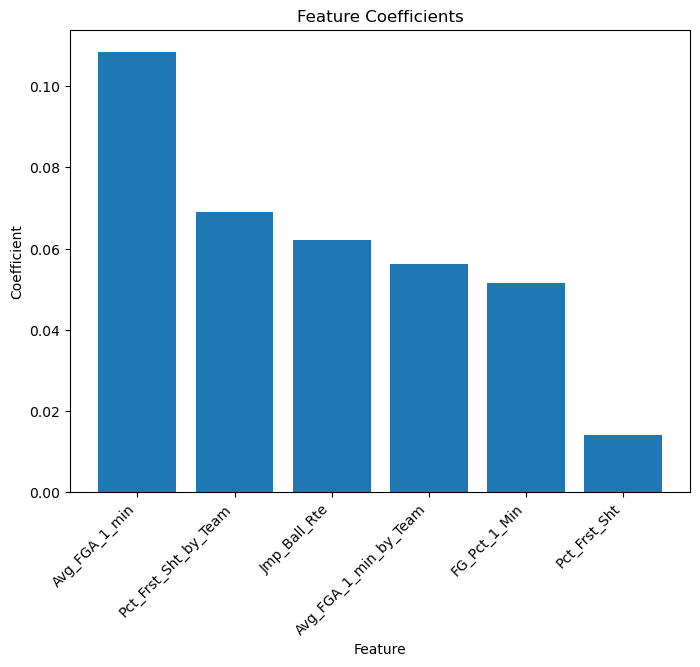

AIC: 4760.2505832683855
BIC: 4801.6897567739525


In [603]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Standardize features (optional but often recommended)
scaler_for_fb = StandardScaler()
X_train = scaler_for_fb.fit_transform(X_train)
X_test = scaler_for_fb.transform(X_test)

# Initialize the model
first_basket_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

# Train the model
first_basket_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = first_basket_model.predict(X_test)
y_probabilities = first_basket_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Assuming X_test and y_test are NumPy arrays
X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Assuming X is a Pandas DataFrame
y_test_df = pd.DataFrame({'Made_First_Basket': y_test})
y_test_df = y_test_df.reset_index(drop=True)

# Concatenate X_test and y_test DataFrames along columns
# Merge X_test_df and y_test_df on their index
merged_test_df = pd.merge(X_test_df, y_test_df, left_index=True, right_index=True)

merged_test_df['probabilities'] = y_probabilities

merged_test_df['prob_diff'] = np.abs(merged_test_df['Made_First_Basket'] - merged_test_df['probabilities'])

prob_diff_sum = merged_test_df['prob_diff'].sum()

print(f'The sum of the probability difference is: {prob_diff_sum}')

# Get feature coefficients
feature_coefficients = first_basket_model.coef_[0]

# Create a DataFrame to display feature coefficients
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': feature_coefficients})

# Sort the DataFrame by coefficient magnitude
coefficients_df['AbsoluteCoefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='AbsoluteCoefficient', ascending=False)

# Display the feature coefficients
print(coefficients_df)

# Plot the feature coefficients
plt.figure(figsize=(8, 6))
plt.bar(coefficients_df['Feature'], coefficients_df['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Coefficients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Number of parameters (features)
k = X_train.shape[1]

# Number of samples
n = X_test.shape[0]

# Log-likelihood for binary classification
log_likelihood = np.sum(y_test * np.log(y_probabilities) + (1 - y_test) * np.log(1 - y_probabilities))

# AIC calculation
AIC = 2 * k - 2 * log_likelihood
print(f'AIC: {AIC}')

# BIC calculation
BIC = np.log(n) * k - 2 * log_likelihood
print(f'BIC: {BIC}')

# Train the model on LightGBM

[LightGBM] [Info] Number of positive: 2951, number of negative: 26567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 29518, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099973 -> initscore=-2.197526
[LightGBM] [Info] Start training from score -2.197526
The sum of the probability difference is: 1168.4589963902858
         Feature  Importance
2   Jmp_Ball_Rte       10766
0   Pct_Frst_Sht        9648
1  Avg_FGA_1_min        9586


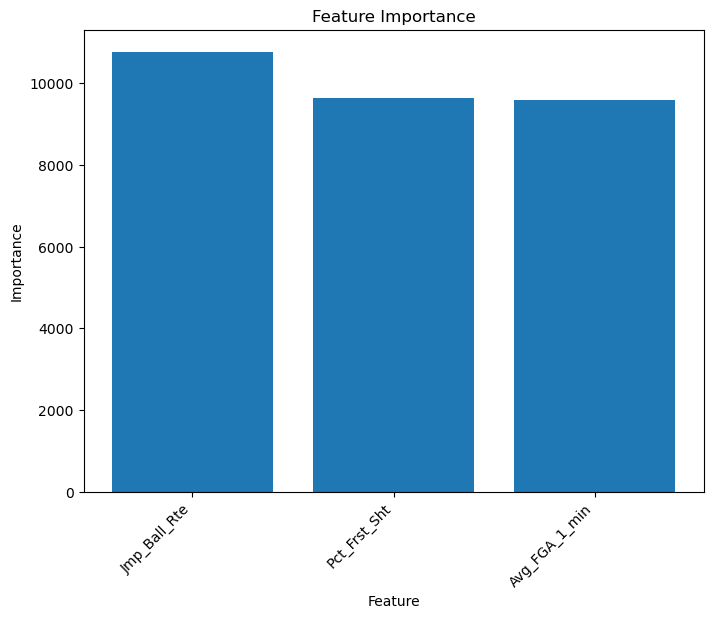

AIC: 4273.366744930557
BIC: 4294.08633168334


In [591]:
#import lightgbm as lgb
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#from sklearn.preprocessing import StandardScaler

# Standardize features (optional but recommended for non-tree models)
#scaler_for_fb = StandardScaler()
#X_train = scaler_for_fb.fit_transform(X_train)
#X_test = scaler_for_fb.transform(X_test)

# Initialize the LightGBM model
#lgb_model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, random_state=42)

# Train the LightGBM model
#lgb_model.fit(X_train, y_train)

# Make predictions on the test set
#y_pred = lgb_model.predict(X_test)
#y_probabilities = lgb_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Assuming X_test and y_test are NumPy arrays
#X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Assuming X is a Pandas DataFrame
#y_test_df = pd.DataFrame({'Made_First_Basket': y_test})
#y_test_df = y_test_df.reset_index(drop=True)

# Concatenate X_test and y_test DataFrames along columns
# Merge X_test_df and y_test_df on their index
#merged_test_df = pd.merge(X_test_df, y_test_df, left_index=True, right_index=True)

#merged_test_df['probabilities'] = y_probabilities

#merged_test_df['prob_diff'] = np.abs(merged_test_df['Made_First_Basket'] - merged_test_df['probabilities'])

#prob_diff_sum = merged_test_df['prob_diff'].sum()

#print(f'The sum of the probability difference is: {prob_diff_sum}')

# Feature importance from LightGBM
#feature_importances = lgb_model.feature_importances_
#coefficients_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by feature importance
#coefficients_df = coefficients_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
#print(coefficients_df)

# Plot the feature importance
#plt.figure(figsize=(8, 6))
#plt.bar(coefficients_df['Feature'], coefficients_df['Importance'])
#plt.xlabel('Feature')
#plt.ylabel('Importance')
#plt.title('Feature Importance')
#plt.xticks(rotation=45, ha='right')
#plt.show()

# Number of parameters (features)
#k = X_train.shape[1]

# Number of samples
#n = X_test.shape[0]

# Log-likelihood for binary classification
#log_likelihood = np.sum(y_test * np.log(y_probabilities) + (1 - y_test) * np.log(1 - y_probabilities))

# AIC calculation
#AIC = 2 * k - 2 * log_likelihood
#print(f'AIC: {AIC}')

# BIC calculation
#BIC = np.log(n) * k - 2 * log_likelihood
#print(f'BIC: {BIC}')

# Combine the last 2 years data

In [ ]:
pos_scored_23_25 = combine_positions_scored_first_data(pos_scored_on_teams_23_24, pos_scored_on_teams_24_25)

fb_23_25 = combine_fb_data_2_seasons(first_basket_rates_23_24, first_basket_rates_24_25, 10)

fs_23_25 = combine_fs_data_2_seasons(first_shot_rates_23_24, first_shot_rates_24_25, 10)

jump_ball_23_25 = combine_jump_ball_2_seasons(jump_ball_23_24, jump_ball_24_25, 10)

fst_1min_23_25 = combine_first_1_min_data_2_seasons(first_1_min_23_24, first_1_min_24_25, 10)

lineup_fb_data_23_25 = combine_lineup_fb_data_2_seasons(lineup_fb_data_23_24, lineup_fb_data_24_25, 10)

lineup_fs_data_23_25 = combine_lineup_fs_data_2_seasons(lineup_fs_data_23_24, lineup_fs_data_24_25, 10)

fs_23_25_by_team = combine_fs_by_player_by_team_data_2_seasons(first_shot_rates_by_player_by_team_23_24, first_shot_rates_by_player_by_team_24_25, 10)

fst_1min_23_25_by_team_combined = combine_first_1_min_data_2_seasons_by_player_by_team(first_1_min_23_24_by_player_by_team, first_1_min_24_25_by_player_by_team, 10)


# Run the function to find value picks from all books

In [607]:
#Create an instance of the NBAScraper class
nba_scraper = NBAScraper()

# Scrape NBA prop bets
first_basket_odds_data = nba_scraper.nba_props_dk()
print(first_basket_odds_data)

#first_basket_odds_data = pd.read_csv(r'files_for_testing.csv')

value_picks_draftkings = predict_single_game_first_basket(first_basket_odds_data, first_basket_model, 5000, first_q_data_24_25, '2024-25', player_position_data_24_25, pos_scored_23_25, fb_23_25, fs_23_25, jump_ball_23_25, lineup_fb_data_23_25, lineup_fs_data_23_25, fst_1min_23_25, fs_23_25_by_team, fst_1min_23_25_by_team_combined, scaler_for_fb)


SSLError: HTTPSConnectionPool(host='sportsbook.draftkings.com', port=443): Max retries exceeded with url: //sites/US-NJ-SB/api/v5/eventgroups/42648/categories/1157?format=json (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))

## 

In [ ]:
first_basket_odds_data_mgm = get_betmgm_lines()
print(first_basket_odds_data_mgm)

#first_basket_odds_data_mgm = pd.read_csv(r'files_for_testing_BetMGM.csv')

value_picks_betmgm = predict_single_game_first_basket_betmgm(first_basket_odds_data_mgm, first_basket_model, 5000, first_q_data_24_25, '2024-25', player_position_data_24_25, pos_scored_23_25, fb_23_25, fs_23_25, jump_ball_23_25, lineup_fb_data_23_25, lineup_fs_data_23_25, fst_1min_23_25, fs_23_25_by_team, fst_1min_23_25_by_team_combined)


In [ ]:
first_basket_odds_data_betrivers = get_betrivers_lines()
print(first_basket_odds_data_betrivers)

#first_basket_odds_data_betrivers = pd.read_csv(r'files_for_testing_BetRivers.csv')

value_picks_betrivers = predict_single_game_first_basket_betrivers(first_basket_odds_data_betrivers, first_basket_model, 5000, first_q_data_24_25, '2024-25', player_position_data_24_25, pos_scored_23_25, fb_23_25, fs_23_25, jump_ball_23_25, lineup_fb_data_23_25, lineup_fs_data_23_25, fst_1min_23_25, fs_23_25_by_team, fst_1min_23_25_by_team_combined)


In [ ]:
first_basket_odds_data_barstool = get_barstool_lines()
print(first_basket_odds_data_barstool)

#first_basket_odds_data_betrivers = pd.read_csv(r'files_for_testing_BetRivers.csv')

value_picks_barstool = predict_single_game_first_basket_barstool(first_basket_odds_data_barstool, first_basket_model, 5000, first_q_data_24_25, '2024-25', player_position_data_24_25, pos_scored_23_25, fb_23_25, fs_23_25, jump_ball_23_25, lineup_fb_data_23_25, lineup_fs_data_23_25, fst_1min_23_25, fs_23_25_by_team, fst_1min_23_25_by_team_combined)


In [ ]:
first_basket_odds_data_fanduel = get_fanduel_lines()
print(first_basket_odds_data_fanduel)

#first_basket_odds_data_betrivers = pd.read_csv(r'files_for_testing_BetRivers.csv')

value_picks_fanduel = predict_single_game_first_basket_fanduel(first_basket_odds_data_fanduel, first_basket_model, 5000, first_q_data_24_25, '2024-25', player_position_data_24_25, pos_scored_23_25, fb_23_25, fs_23_25, jump_ball_23_25, lineup_fb_data_23_25, lineup_fs_data_23_25, fst_1min_23_25, fs_23_25_by_team, fst_1min_23_25_by_team_combined)


In [ ]:
first_basket_odds_data_caesers = get_caesers_lines()
print(first_basket_odds_data_caesers)

#first_basket_odds_data_betrivers = pd.read_csv(r'files_for_testing_BetRivers.csv')

value_picks_caesers = predict_single_game_first_basket_fanduel(first_basket_odds_data_caesers, first_basket_model, 5000, first_q_data_24_25, '2024-25', player_position_data_24_25, pos_scored_23_25, fb_23_25, fs_23_25, jump_ball_23_25, lineup_fb_data_23_25, lineup_fs_data_23_25, fst_1min_23_25, fs_23_25_by_team, fst_1min_23_25_by_team_combined)


In [ ]:
first_basket_odds_data_pinnacle = get_pinnacle_lines()
print(first_basket_odds_data_pinnacle)

#first_basket_odds_data_betrivers = pd.read_csv(r'files_for_testing_BetRivers.csv')

value_picks_pinnacle = predict_single_game_first_basket_fanduel(first_basket_odds_data_pinnacle, first_basket_model, 5000, first_q_data_24_25, '2024-25', player_position_data_24_25, pos_scored_23_25, fb_23_25, fs_23_25, jump_ball_23_25, lineup_fb_data_23_25, lineup_fs_data_23_25, fst_1min_23_25, fs_23_25_by_team, fst_1min_23_25_by_team_combined)


# Run functions to consolidate bets into best bets

In [ ]:
def remove_duplicates_keep_highest_odds(df):
    # Sort by Player_Name and Odds in descending order
    df_sorted = df.sort_values(by=['Player_Name', 'Odds'], ascending=[True, False])
    
    # Drop duplicates, keeping the first occurrence (which will have the highest Odds)
    df_unique = df_sorted.drop_duplicates(subset='Player_Name', keep='first')
    
    # Return the result
    return df_unique


def remove_players_with_less_than_10_gs(picks_df, fst_1_min_df, bankroll):

    fst_1_min_df_cleaned = fst_1_min_df[['personId', 'Games_Started']]

    # Assuming your DataFrames are already defined as picks_df and fst_1_min_df
    merged_df = pd.merge(picks_df, fst_1_min_df_cleaned, left_on='PLAYER_ID', right_on='personId', how='left')

    merged_df_without_some_picks = merged_df[merged_df['Games_Started'] >= 10]

    merged_df_without_some_picks_cleaned = merged_df_without_some_picks[['Player_Name', 'Sportsbook', 'Odds', 'How much to bet? BM']]

    merged_df_without_some_picks_cleaned.rename(columns={'How much to bet? BM': 'How much to bet?'}, inplace=True)

    merged_df_without_some_picks_cleaned['Bankroll'] = bankroll
    
    return merged_df_without_some_picks_cleaned

    

In [ ]:
fst_1min_22_24_1_game_min = combine_first_1_min_data_2_seasons(first_1_min_22_23, first_1_min_23_24, 1)

list_of_books = [value_picks_draftkings, value_picks_betmgm, value_picks_betrivers, value_picks_fanduel, value_picks_caesers, value_picks_barstool, value_picks_pinnacle]

combined_df = pd.concat(list_of_books, ignore_index=True)


In [ ]:
# Apply the function to your dataframe
cleaned_picks_df = remove_duplicates_keep_highest_odds(combined_df)

newest_picks_df = remove_players_with_less_than_10_gs(cleaned_picks_df, fst_1min_22_24_1_game_min, 5000)

print(newest_picks_df)

# Code for testing

In [487]:
pos_scored_22_24 = combine_positions_scored_first_data(pos_scored_on_teams_22_23, pos_scored_on_teams_23_24)

fb_22_24 = combine_fb_data_2_seasons(first_basket_rates_22_23, first_basket_rates_23_24, 10)

fs_22_24 = combine_fs_data_2_seasons(first_shot_rates_22_23, first_shot_rates_23_24, 10)

jump_ball_22_24 = combine_jump_ball_2_seasons(jump_ball_22_23, jump_ball_23_24, 10)

fst_1min_22_24 = combine_first_1_min_data_2_seasons(first_1_min_22_23, first_1_min_23_24, 10)

lineup_fb_data_22_24 = combine_lineup_fb_data_2_seasons(lineup_fb_data_22_23, lineup_fb_data_23_24, 10)

lineup_fs_data_22_24 = combine_lineup_fs_data_2_seasons(lineup_fs_data_22_23, lineup_fs_data_23_24, 10)

fs_22_24_by_team = combine_fs_by_player_by_team_data_2_seasons(first_shot_rates_by_player_by_team_22_23, first_shot_rates_by_player_by_team_23_24, 10)

fst_1min_22_24_by_team_combined = combine_first_1_min_data_2_seasons_by_player_by_team(first_1_min_by_player_by_team_22_23, first_1_min_23_24_by_player_by_team, 10)


In [705]:
#Create an instance of the NBAScraper class
#nba_scraper = NBAScraper()

# Scrape NBA prop bets
#first_basket_odds_data = nba_scraper.nba_props_dk()
#print(first_basket_odds_data)

first_basket_odds_data = pd.read_csv(r'games_for_testing.csv')

value_picks_draftkings = predict_single_game_first_basket(first_basket_odds_data, first_basket_model, 5000, first_q_data_23_24, '2023-24', player_position_data_23_24, pos_scored_22_24, fb_22_24, fs_22_24, jump_ball_22_24, lineup_fb_data_22_24, lineup_fs_data_22_24, fst_1min_22_24, fs_22_24_by_team, fst_1min_22_24_by_team_combined, scaler_for_fb)


What date is it?:  2 25


Not Matched Correctly
luka-doncic
luka-dončić
Not Matched Correctly
jusuf-nurkic
jusuf-nurkić
Not Matched Correctly
nikola-jokic
nikola-jokić


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\116582676.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'DraftKings'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\116582676.py:298: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)


Not Matched Correctly
bogdan-bogdanovic
bogdan-bogdanović
Not Matched Correctly
jonas-valanciunas
jonas-valančiūnas
nikola-vucevic
nikola-vučević


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\116582676.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'DraftKings'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\116582676.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'DraftKings'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\116582676.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [707]:
#first_basket_odds_data_mgm = get_betmgm_lines()
#print(first_basket_odds_data_mgm)

first_basket_odds_data_mgm = pd.read_csv(r'games_for_testing_betmgm.csv')

value_picks_betmgm = predict_single_game_first_basket_betmgm(first_basket_odds_data_mgm, first_basket_model, 5000, first_q_data_23_24, '2023-24', player_position_data_23_24, pos_scored_22_24, fb_22_24, fs_22_24, jump_ball_22_24, lineup_fb_data_22_24, lineup_fs_data_22_24, fst_1min_22_24, fs_22_24_by_team, fst_1min_22_24_by_team_combined, scaler_for_fb)


What date is it?:  2 25


Not Matched Correctly
jusuf-nurkic
jusuf-nurkić
Not Matched Correctly
luka-doncic
luka-dončić


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\3403419455.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'BetMGM'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\3403419455.py:297: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\3403419455.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Not Matched Correctly
nikola-vucevic
nikola-vučević
jonas-valanciunas
jonas-valančiūnas
Not Matched Correctly
nikola-jokic
nikola-jokić
Not Matched Correctly
bogdan-bogdanovic
bogdan-bogdanović


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\3403419455.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'BetMGM'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\3403419455.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'BetMGM'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\3403419455.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

What are the odds for Andrew Nembhard:  1050
What are the odds for Max Strus:  950
What are the odds for Andrew Wiggins:  900
What are the odds for Caleb Houstan:  1400
What are the odds for Gary Harris:  1200
What are the odds for Julian Champagnie:  1250
What are the odds for Kris Murray:  1150


In [709]:
#first_basket_odds_data_betrivers = get_betrivers_lines()
#print(first_basket_odds_data_betrivers)

first_basket_odds_data_betrivers = pd.read_csv(r'games_for_testing_betrivers.csv')

value_picks_betrivers = predict_single_game_first_basket_betrivers(first_basket_odds_data_betrivers, first_basket_model, 5000, first_q_data_23_24, '2023-24', player_position_data_23_24, pos_scored_22_24, fb_22_24, fs_22_24, jump_ball_22_24, lineup_fb_data_22_24, lineup_fs_data_22_24, fst_1min_22_24, fs_22_24_by_team, fst_1min_22_24_by_team_combined, scaler_for_fb)



What date is it?:  2 25


Not Matched Correctly
jusuf-nurkic
jusuf-nurkić
Not Matched Correctly
luka-doncic
luka-dončić


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\307727132.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'BetRivers'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\307727132.py:298: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  value_picks_dataframe = pd.concat([value_picks_dataframe, value_picks_subset], ignore_index=True)
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\307727132.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Not Matched Correctly
nikola-vucevic
nikola-vučević
jonas-valanciunas
jonas-valančiūnas
Not Matched Correctly
nikola-jokic
nikola-jokić


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\307727132.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'BetRivers'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\307727132.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'BetRivers'


Not Matched Correctly
bogdan-bogdanovic
bogdan-bogdanović


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\307727132.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'BetRivers'
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\307727132.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_picks['Sportsbook'] = 'BetRivers'


What are the odds for Austin Reaves:  1200
What are the odds for D'Angelo Russell:  1050
What are the odds for Andrew Nembhard:  1300
What are the odds for Andrew Wiggins:  850
What are the odds for Gary Harris:  1100
What are the odds for Jalen Suggs:  850
What are the odds for Julian Champagnie:  1100
What are the odds for Kris Murray:  1050
What are the odds for Cody Martin:  1200


In [711]:
fst_1min_22_24_1_game_min = combine_first_1_min_data_2_seasons(first_1_min_22_23, first_1_min_23_24, 1)

combined_df = pd.concat([value_picks_draftkings, value_picks_betmgm, value_picks_betrivers], ignore_index=True)


In [731]:
def remove_duplicates_keep_highest_odds(df):
    # Sort by Player_Name and Odds in descending order
    df_sorted = df.sort_values(by=['Player_Name', 'Odds'], ascending=[True, False])
    
    # Drop duplicates, keeping the first occurrence (which will have the highest Odds)
    df_unique = df_sorted.drop_duplicates(subset='Player_Name', keep='first')
    
    # Return the result
    return df_unique


def remove_players_with_less_than_10_gs(picks_df, fst_1_min_df, bankroll):

    fst_1_min_df_cleaned = fst_1_min_df[['personId', 'Games_Started']]

    # Assuming your DataFrames are already defined as picks_df and fst_1_min_df
    merged_df = pd.merge(picks_df, fst_1_min_df_cleaned, left_on='PLAYER_ID', right_on='personId', how='left')

    merged_df_without_some_picks = merged_df[merged_df['Games_Started'] >= 10]

    merged_df_without_some_picks_cleaned = merged_df_without_some_picks[['Player_Name', 'Sportsbook', 'Odds', 'How much to bet? BM']]

    merged_df_without_some_picks_cleaned.rename(columns={'How much to bet? BM': 'How much to bet?'}, inplace=True)

    merged_df_without_some_picks_cleaned['Bankroll'] = bankroll
    
    return merged_df_without_some_picks_cleaned

    

In [733]:
# Apply the function to your dataframe
cleaned_picks_df = remove_duplicates_keep_highest_odds(combined_df)

newest_picks_df = remove_players_with_less_than_10_gs(cleaned_picks_df, fst_1min_22_24_1_game_min, 5000)

print(newest_picks_df)

           Player_Name  Sportsbook    Odds  How much to bet?  Bankroll
0      Andrew Nembhard   BetRivers  1300.0              80.0      5000
1       Andrew Wiggins      BetMGM   900.0             108.0      5000
2        Austin Reaves   BetRivers  1200.0              59.0      5000
3        Caleb Houstan      BetMGM  1400.0              58.0      5000
4          Cody Martin   BetRivers  1200.0              53.0      5000
5     D'Angelo Russell   BetRivers  1050.0              51.0      5000
6          Gary Harris      BetMGM  1200.0              75.0      5000
7          Jalen Suggs  DraftKings  1100.0              92.0      5000
8    Julian Champagnie      BetMGM  1250.0              88.0      5000
9          Kris Murray      BetMGM  1150.0              82.0      5000
10           Max Strus      BetMGM   950.0              64.0      5000
11  Wendell Carter Jr.  DraftKings   800.0              53.0      5000


C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\2577235653.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_without_some_picks_cleaned.rename(columns={'How much to bet? BM': 'How much to bet?'}, inplace=True)
C:\Users\nlomnitz\AppData\Local\Temp\ipykernel_19500\2577235653.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_without_some_picks_cleaned['Bankroll'] = bankroll
